<a href="https://colab.research.google.com/github/rmunoz78/ProyectoIntegrador_MNA_Equipo23/blob/main/Proyecto_Integrador_TFL_Equipo23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de sistema de Recomendación Vehículo / Conductor / Caja Seca para TFL
#### Equipo 23:
- Ramón Ariel Iván Muñoz Corona   A01330566

In [345]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat May 25 18:20:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   39C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [346]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.4 gigabytes of available RAM

You are using a high-RAM runtime!


## Importación de Librerías

In [347]:
!pip install surprise
!pip install geopy
!pip install imblearn
!pip install pandas
!pip install plotly

In [348]:
%matplotlib inline
from geopy.distance import geodesic
import numpy as np
import pandas as pd
import plotly.express as px
import math
import json
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier
from surprise import Dataset, Reader, KNNWithMeans, accuracy
from surprise.model_selection import train_test_split as ttsplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.inspection import permutation_importance
from scipy.sparse import csr_matrix
from sklearn.svm import SVC
import warnings; warnings.simplefilter('ignore')
# to suppress scientifiv notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


________________
# Avance 1
## Importación de Datos

In [349]:
# Lectura de los datos desde el archivo CSV
raw_df = pd.read_csv('/content/drive/MyDrive/Maestria/Proyecto Integrador/Informacion_TFL.csv')
# Copia de los datos a un nuevo data frame con el fin de tener el dataframe
# original en caso de ser necesario
df = raw_df.copy()

In [350]:
# Para revisar que se importó de manera correcta el dataframe, imprimimos los
# primeros 5 renglones. Esto, a su vez, nos permite visualizar la estructura de
# la tabla
df.head()

No_de_Orden          Cliente  Latitud_Recoleccion  Longitud_Recoleccion  \
0          63  PLAYERAS_SOURCE               19.459               -99.233   
1         900            JASAK               19.499               -99.168   
2        1364          NOVELTY               19.467               -99.233   
3        1395          NOVELTY               19.467               -99.233   
4        1396          NOVELTY               19.467               -99.233   

   Latitud_Entrega  Longitud_Entrega  Dia  Mes   Ano  Dia_de_la_semana  ...  \
0           19.720           -99.192   26    4  2022                 2  ...   
1           19.680           -99.153   14    7  2021                 3  ...   
2           19.289           -98.954   11    9  2020                 5  ...   
3           19.696           -99.200    7    9  2020                 1  ...   
4           19.433           -99.133    9    9  2020                 3  ...   

  Modelo_Vehiculo_Asignado  Capacidad_Max_Vehiculo_Asignado   ID_Caja_Seca  \
0                     1991                           22.000         689VT8   
1                     1992                           12.000  Integrada_T16   
2                     1999                           22.000         852VS5   
3                     1999                           22.000         852VS5   
4                     1997                           12.000  Integrada_T02   

  Capacidad_Max_Caja_Seca   Tipo_de_carga No_de_Pallets Peso_de_la_carga  \
0                  22.000       Disfraces        20.000           20.000   
1                  12.000    Electronicos        12.000           12.000   
2                  22.000  Juegos De Mesa        20.000           20.000   
3                  22.000  Juegos De Mesa        20.000           20.000   
4                  12.000  Juegos De Mesa        10.000           10.000   

    Packaging  Precio_Viaje  Status_de_Orden  
0  Entarimado          4873       Completada  
1  Entarimado          3248       Completada  
2  Entarimado          4278       Completada  
3  Entarimado          2300       Completada  
4  Entarimado          3193       Completada  

[5 rows x 28 columns]

## Estructura de los datos

In [351]:
# Empezaremos revisando la forma de la tabla para saber con cuantas columnas
# (características de los viajes) y filas (órdenes) tenemos disponibles

df.shape

(7395, 28)

Tenemos 28 features o características de cada viaje y tenemos 7395 viajes registrados.

Con base en esto procedemos a analizar las características de cada columna.

In [352]:
# Con esta función obtenemos la información acerca de cada columna, como por
# ejemplo, tipo de dato, nombre de la columna y el total de los valores nulos
# en la tabla

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No_de_Orden                             7199 non-null   object 
 1   Cliente                                 7395 non-null   object 
 2   Latitud_Recoleccion                     7395 non-null   float64
 3   Longitud_Recoleccion                    7395 non-null   float64
 4   Latitud_Entrega                         7395 non-null   float64
 5   Longitud_Entrega                        7395 non-null   float64
 6   Dia                                     7395 non-null   int64  
 7   Mes                                     7395 non-null   int64  
 8   Ano                                     7395 non-null   int64  
 9   Dia_de_la_semana                        7395 non-null   int64  
 10  Conductor                               7395 non-null   obje

Podemos ver que la única columna que contiene datos nulos es la del Número de Orden (No_de_Orden), con un total de 196 valores nulos o faltantes.

Sin embargo, esta columna al ser únicamente un identificador, no nos provee ningún elemento estadístico, por lo que podemos removerla.

In [353]:
# Removemos la columna del Número de Orden
df.drop('No_de_Orden', axis=1, inplace=True)

Con base en esta información podemos comenzar a revisar las variables númericas y categóricas para empezar a extraer información.

## Resumen de los Datos

### Variables Numéricas
Comenzaremos con las variables numéricas. Para empezar, realizaremos un análisis estadístico para revisar que las variables cuenten con valores posibles y que podamos revisar si las variables muestran alguna tendencia relevante.

Para realizar el análisis estadístico, utilizaremos la función de "describe" para obtener los valores estadísticos (cuenta, promedio, desviación estandar, mínimo, Q25, Q50, Q75 y máximo).

In [354]:
# La función de describe muestra los valores estadísticos de cada variable
# numérica. Por otra lado, la función T, nos da la transpuesta de la matriz,
# mejorando la visualización de los datos.
df.describe().T

count     mean      std      min  \
Latitud_Recoleccion                    7395.000   19.532    0.206   19.284   
Longitud_Recoleccion                   7395.000  -99.238    0.375 -104.645   
Latitud_Entrega                        7395.000   19.782    0.824   17.983   
Longitud_Entrega                       7395.000  -99.291    0.944 -107.406   
Dia                                    7395.000   15.954    8.693    1.000   
Mes                                    7395.000    7.168    3.270    1.000   
Ano                                    7395.000 2021.824    0.956 2019.000   
Dia_de_la_semana                       7395.000    3.328    1.617    1.000   
Experiencia_Conductor                  7395.000    6.648    3.681    0.000   
Rendimiento_Promedio_Vehiculo_Asignado 7395.000    2.947    0.764    2.000   
Modelo_Vehiculo_Asignado               7395.000 1996.590    8.789 1981.000   
Capacidad_Max_Vehiculo_Asignado        7395.000   17.579    6.079    3.500   
Capacidad_Max_Caja_Seca                7395.000   17.579    6.079    3.500   
No_de_Pallets                          7395.000   13.802    5.581    1.000   
Peso_de_la_carga                       7395.000   13.800    5.603    1.000   
Precio_Viaje                           7395.000 3787.244 5197.026  147.000   

                                            25%      50%      75%       max  
Latitud_Recoleccion                      19.467   19.474   19.499    23.998  
Longitud_Recoleccion                    -99.233  -99.228  -99.168   -89.593  
Latitud_Entrega                          19.467   19.681   19.697    28.629  
Longitud_Entrega                        -99.233  -99.201  -99.153   -86.949  
Dia                                       9.000   16.000   23.000    31.000  
Mes                                       4.000    8.000   10.000    12.000  
Ano                                    2021.000 2022.000 2023.000  2023.000  
Dia_de_la_semana                          2.000    3.000    5.000     7.000  
Experiencia_Conductor                     4.000    8.000   10.000    11.000  
Rendimiento_Promedio_Vehiculo_Asignado    2.000    3.300    3.300     5.100  
Modelo_Vehiculo_Asignado               1992.000 1997.000 2005.000  2015.000  
Capacidad_Max_Vehiculo_Asignado          12.000   22.000   22.000    25.000  
Capacidad_Max_Caja_Seca                  12.000   22.000   22.000    25.000  
No_de_Pallets                            10.000   12.000   20.000    24.000  
Peso_de_la_carga                         10.000   12.000   20.000    24.000  
Precio_Viaje                           1850.000 3000.000 4400.000 67200.000

#### Insights:
* Coordenadas de Longitud y Latitud:
  * La latitud promedio tanto de recolección, como de entrega esta al rededor de 19.45 con una desviación estandar de aproximadamente 1.25, mostrando que la mayoría de las locaciones están agrupadas alrededor del promedio, con una dispersión muy baja.
  * La longitud promedio para la recolección y entrega está aproximadamente en -99.24, con una desviación muy baja (aproximadamente 0.655). Lo que sugiere que las locaciones están bastante juntas.
  * Si obtuvieramos una locación promedio sería a un lado del Campo Militar  1-A de SEDENA en la CDMX.
  * Con estas columnas es facil obtener el la distancia que se recorrió para el viaje.
* Información sobre las fechas:
  * El día del mes promedio es aproximadamente 16, con una desviación estandar de 8.69, mostrando que se distribuyen los viajes de manera equitativa a lo largo del mes.
  * El mes promedio es Julio (mes 7), con una desviación estandar de 3.27. Si vemos los cuantiles, podemos ver que los meses más cargados son de agosto a diciembre.
  * El año promedio es 2021. Basado en los cuantiles podemos decir que la mayoría de los datos son de entre 2019 y 2023.
  * El día promedio es el miercoles, con una desviación estandar de aproximadamente 1.6, mostrando que estan distribuiods equitativamente los viajes a lo largo de la semana.
* Información sobre Conductores y Vehículos
  * El nivel de experiencia promedio de los conductores es de 6.65 años, sin embargo su desviación estandar es bastante elevada, con 3.68 años, mostrando que los un rango bastante amplio en el nivel de experiencia. Esto nos habla de una posible falta de retención de personal.
  * El año promedio de los vehículos es 1996. Si vemos los cuantiles, podemos ver que la gran mayoría de los vehiculos son anticuados, siendo en su mayoría de entre el año 1981 y 1997.
  * El peso máximo soportado por las unidades es de 17.58 Toneladas, sin embargo tienen una desviación estandar alta, de aproximadamente 6.08 toneladas, mostrando que hay una amplia diversidad en la foltilla para diferentes capacidades.
  * El rendimiento promedio es de aproximadamente 3 km por litro, lo que nos habla de un rendimiento bajo, probablemente por el nivel de carga.
* Información del cargamento:
  * El peso promedio por viaje es de 13.8 Toneladas, con una desviación de 5.6 toneladas aproximadamente. Esto nos dice que existe una buena variedad de pesos en cada viaje.
  * Podemos ver una correlación fuerte entre el número de pellets y el peso del viaje. Con un número de pellets de aproximadamente 14, igualmente con una desviación estandar elevada de 6 pellets, mostrando una buena variedad de número de pellets por viaje.
  * El precio promedio por viaje es de \$3787.24 MXN, con una desviación estandar elevada, de \$5197.03 MXN, sugiriendo que los precios varian mucho entre clientes. Probablemente valdría la pena estandarizarlos.
  * Podemos ver que las capacidades máximos son una calca una de la otra, por lo que valdría la pena desechar una de las dos variables.

### Variables de Tipo Objeto
Una vez analizadas las variables de tipo numéricas, podemos pasar con las de tipo objeto. Para este análisis revisaremos con qué valores cuenta cada variable para revisar que no existan valores erroneos o inválidos. De igual manera nos brindará un insight sobre las variables.

In [355]:
# Esta función está diseñada para imprimir cada variable de tipo objeto y que
# a su vez se impriman los valores de cada variable, junto con el conteo de
# cada valor.

for i in df.describe(include=['object']).columns:
    print('Unique values in',i, 'are :')
    print(df[i].value_counts())
    print('*'*50)

Unique values in Cliente are :
Cliente
NOVELTY                   1939
JASAK                     1829
PLAYERAS_SOURCE           1638
JESSY                     1367
PENINSULA_ORIENTAL         357
APLIN                      122
MUEBLES_TRICK               76
MULTIBOLSAS                 60
COLECCIONES_DEPORTIVAS       7
Name: count, dtype: int64
**************************************************
Unique values in Conductor are :
Conductor
Externo                          1405
Jose Martin Regino Lopez          805
Maradonio Tirso Montano           711
Jose Luis Jimenez de la Cruz      695
Ernesto Hernandez Bernal          634
Gabriel Reyes                     614
Miguel Perez Santarosa            612
Jose Daniel Hernandez Martell     410
Edgar Arreola                     317
Nazario Cruz de la Cruz           310
Ivan Montero                      294
Angel                             174
Alan Gil Chavez                   121
Yair Gabriel Flores Lira           96
Agustin                       

#### Insights:
* Clientes
  * Los clientes con mayor número de viajes son NOVELTY (1939 viajes), JASAK (1829 viajes)y PLAYERAS_SOURCE (1638 viajes)
  * Existe una diferencia significativa entre los clientes principales y el resto de los clientes, lo que nos habla de una concentración del negocio en sus clientes más grandes.
* Conductor
  * Los viajes son mayormente realizados por Jose Martin Regino Lopez (805 Viajes), Maradonio Tirso Montaño (711 Viajes) y Jose Luis Jimenez de la Cruz (695 Viajes).
  * Existe una concentración importante de los viajes realizados por conductores externos. 1405 de 7395 Viajes (19%). Lo que nos habla de una posible falta de capacidad de la empresa. Probablemte requiera más conductores o conductores con más experiencia.
  * Existe una distribución inicuo de los viajes entre conductores. Probablemente por sus status dentro de la empresa o por sus años de experiencia.
  * 6532 de los viajes fueron realizados por choferes aún activos en la empresa y 1043 por choferes que no continuan en la empresa.
* Tipos de Servicios Solicitado:
  * El servicio más solicitado es el manejo y transporte de mercancía. Valdría la pena revisar si estos también son los más redituables.
  * Existe una gran diferencia entre los servicios solicitados para torton y trailer, que para camioneta.
  * Existe una gran similitud entre los vehículos solicitados y los vehículos asignados. Sin embargo, podemos ver la existencia de externos en los vehículos asignados. Estos son debido a que por falta de capacidad operacional, se asignan camiones de empresas hermanas para cubrir la necesidad del viaje.
  * La distribución de los ID de los vehiculos asignados y los ID de tipos de caja es identico, lo que nos dice que probablemte nunca se han cambiado las cajas de sus vehiculos.
* Información de la carga:
  * El tipo de carga más transportada son eletrónicos y juegos de mesa.
  * La mayor parte de las mercancias están empaquetadas utilizando pallets.
* Estatus de Orden:
  * El 96% de los viajes se completaron, lo que nos indica un buen nivel de servicio por parte de TFL.

Ya analizados estos datos y revisar que estén correctos, podemos proceder al análisis univariable. Pero antes, valdría la pena agregar una variable; la distancia del viaje. Esta nueva variable nos da un mayor insight sobre una posible correlación entre distancia y precio.

In [356]:
# Esta función calcula la distancia entre los puntos de recolección y entrega
# utilizando la librería de geodesic
def calculate_distance(row):
    origin = (row['Latitud_Recoleccion'], row['Longitud_Recoleccion'])
    delivery = (row['Latitud_Entrega'], row['Longitud_Entrega'])
    return geodesic(origin, delivery).kilometers

# Se aplica la función a cada fila de la tabla
df["distancia_km"] = df.apply(calculate_distance, axis=1)

Una agregada la nueva variable y terminar de revisar que los datos estén correctos, podemos proceder al análisis univariable. Esto nos va a dar un mayor nivel de insight sobre cómo se comporta cada variable y si es que existe algún patrón o comportamiento.

## Análisis Univariable
### Variables Numéricas
Para revisar las variables numéricas generaremos un histograma, junto con un diagrama de caja, resaltando su promedio y la mediana. Esto nos permitirá ver la distribución de los datos, visualizar si tenemos outliers y ver si tenemos alguna tendencia.

In [357]:
# Esta función, como se explicó, nos permite visualizar la distribución de los
# datos numéricos, si es que existen outliers y donde se encuentra su valor
# medio y su mediana

def plot_histogram_boxplot(data, col_name, figsize = (5,5), bins = None):
  feature = data[col_name]
  f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2,
                                         gridspec_kw = {"height_ratios": (.25, .75)},
                                         figsize = figsize)

  ax_box2.set_title(col_name).set_position([0.5, -3])
  sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet', orient="h")
  ax_box2.set_xlabel('')
  sns.distplot(feature, kde=False, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2,color='tab:cyan') # For histogram
  ax_hist2.axvline(np.mean(feature), color='purple', linestyle='--')
  ax_hist2.axvline(np.median(feature), color='black', linestyle='-')
  ax_hist2.set_ylabel('Total de Viajes')

# Esta función funciona con el mismo principio que plot_histogram_boxplot,
# sin embargo está diseñada para poder tener más de una gráfica en el mismo
# bloque. Visualizando de mejor manera las gráficas.
def multi_histogram_boxplot(feature, ax, ax2, bins=None):
    sns.boxplot(feature, ax=ax, showmeans=True, color='violet', orient="h")
    if bins:
        sns.distplot(feature, kde=False, ax=ax2, bins=bins, color='tab:cyan')
    else:
        sns.distplot(feature, kde=False, ax=ax2, color='tab:cyan')
    ax2.set_xlabel('')
    ax2.axvline(np.mean(feature), color='purple', linestyle='--')
    ax2.axvline(np.median(feature), color='blue', linestyle='-')

# Esta funcion crea un mapa alrededor con los data series de coordenads
def plot_location(data, lat_col, lon_col):
  fig = px.scatter_mapbox(data, lat=lat_col, lon=lon_col, hover_name="Cliente", hover_data=["Dia", "Mes", "Ano"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
  fig.update_layout(mapbox_style="open-street-map")
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.show()

# Esta función permite poner varias gráficas del mismo tipo en una matriz
# permitiendo visualizarlas todas en un sólo bloque
def create_grid_of_plots(data, cols, figsize=(15, 5), bins=None):
  full_rows = math.floor(len(cols)/3)
  last_row_elems = len(cols) % 3
  for i in range(0,full_rows*3,3):
    pltcols = cols[i:i+3]
    fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=figsize, gridspec_kw={"height_ratios": (0.25, 0.75)})
    fig.subplots_adjust(hspace=0.18)
    for j in range(3):
      col = pltcols[j]
      ax = axes[0, j%3]
      ax2 = axes[1, j%3]
      feature = df[col]
      multi_histogram_boxplot(feature, ax, ax2, bins)
      ax.set_title(col).set_position([0.5, -3])
    plt.show()
  if (last_row_elems > 0):
    pltcols = cols[len(cols)-last_row_elems:]
    if len(pltcols) == 1:
      plot_histogram_boxplot(df,pltcols[0])
    else:
      fig, axes = plt.subplots(nrows = 2, ncols = len(pltcols), figsize = (len(pltcols)*5, 5), gridspec_kw={"height_ratios": (0.25, 0.75)})
      print(axes)
      fig.subplots_adjust(hspace=0.15)
      for j in range(len(pltcols)):
        col = pltcols[j]
        ax = axes[0, j%len(pltcols)]
        ax2 = axes[1, j%len(pltcols)]
        feature = df[col]
        multi_histogram_boxplot(feature, ax, ax2, bins)
        ax.set_title(col).set_position([0.5, -3])
      plt.show()

### Puntos de Recolección

In [358]:
plot_location(df, "Latitud_Recoleccion","Longitud_Recoleccion")

- Este análisis a pesar de ser multivariable puede ser tomado como uno sólo debido a que estas dos variables nos muestran la locación de los puntos de recolección
- Podemos notar que la mayoría de las recolecciones son realizadas dentro del area metropolitana (EDOMEX y CDMX)
- Existen algunos "Outliers" de recolecciones realizdos en Querétaro, Mérida, Durango y Jalisco. Sin embargo, son viajes posibles.

### Puntos de Entrega

In [359]:
plot_location(df, "Latitud_Entrega","Longitud_Entrega")

- Estas dos variables (Latitud de Entrega y Longitud de Entrega) sufren del mismo problema que el de los puntos de recolección; pueden ser tomados como una sola variable.
- En este caso, las entregas podemos ver que están más repartidas a lo largo de toda la republica
- A pesar de verse una dispersion mayor, podemos ver que existe de cualquier manera una concentración fuerte alrededor del area metropolitana y sus estados colindantes

### Fechas de los viajes


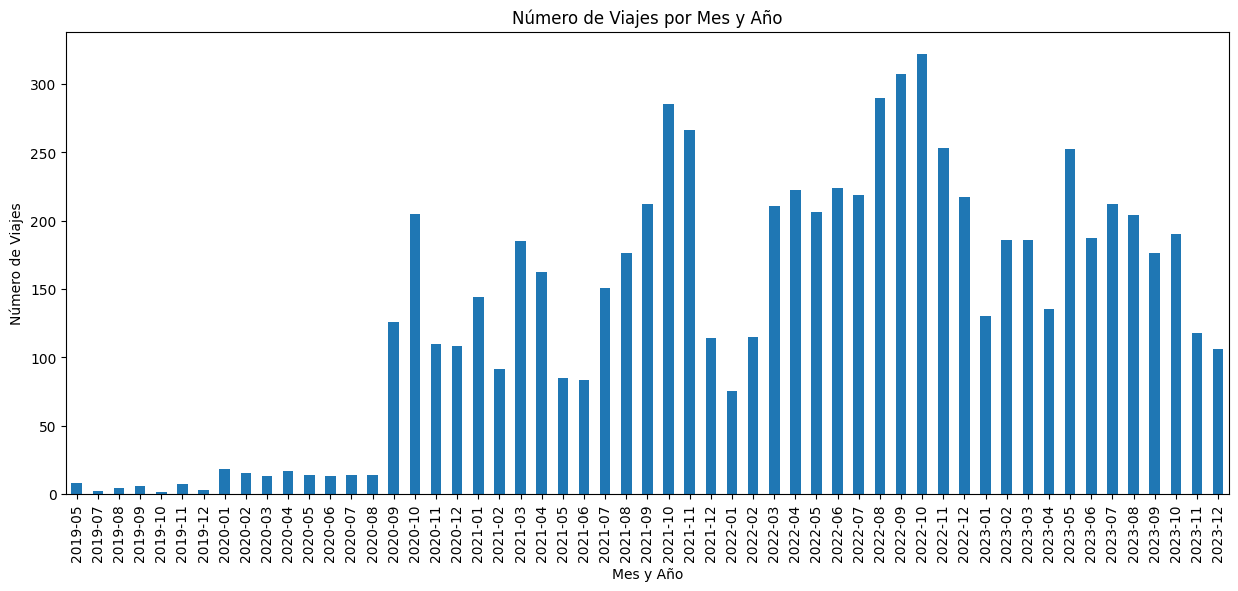

In [360]:
# Primero generamos un dataframe que contenga la variable en conjunto de Fecha
df_fechas = df[["Ano","Mes","Dia",]].copy()
df_fechas['Fecha'] = df_fechas['Ano'].astype(str) + '-' + df_fechas['Mes'].astype(str) + '-' + df_fechas['Dia'].astype(str)
df_fechas['Fecha'] = pd.to_datetime(df_fechas['Fecha'])

# Agrupamos las fechas por mes y año y contamos los viajes. Esto para facilitar
# la visualización de los datos
df_fechas['Mes y Año'] = df_fechas['Fecha'].dt.to_period('M')
conteo_viajes = df_fechas.groupby('Mes y Año').size()
conteo_viajes.head()

# Mostramos la gráfica
plt.figure(figsize=(15, 6))
conteo_viajes.plot(kind='bar')
plt.xlabel('Mes y Año')
plt.ylabel('Número de Viajes')
plt.title('Número de Viajes por Mes y Año')
plt.show()

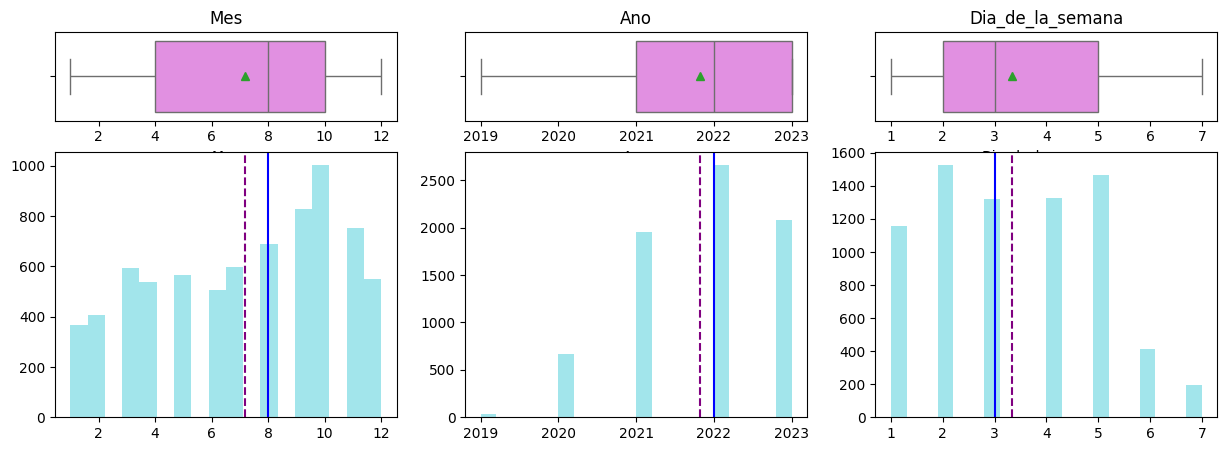

In [361]:
create_grid_of_plots(df, ["Mes","Ano","Dia_de_la_semana"])

- Con base en estas gráficas podemos ver que 2019 y 2020 tuvo una baja importante en viajes. Esto es debido a que anteriormente los registros eran en carpetas físicas, las cuales se perdieron debido a un incendio en la oficina.
- Podemos notar que entre Agosto y Noviembre, existe un patrón de una alza de viajes, lo que puede estar relacionado por la preparación de las empresas al fin de año. Esto puede significar una ventaja para TFL ya que puede prepararse para la carga de trabajo para estas fechas.
- El año con una mayor concentración de viajes fue 2022. Valdría la pena revisar las posibles causas de la baja para 2023. Ya sea por fuga de clientes o algún otro factor como alza de precios.
- Los días entre semana (lunes a viernes) son los días con mayor nivel de trabajo. Sábados y Domingos son los más bajos. El martes es el día con mayor nivel de viajes, seguido del Viernes.

#### Experiencia del Conductor

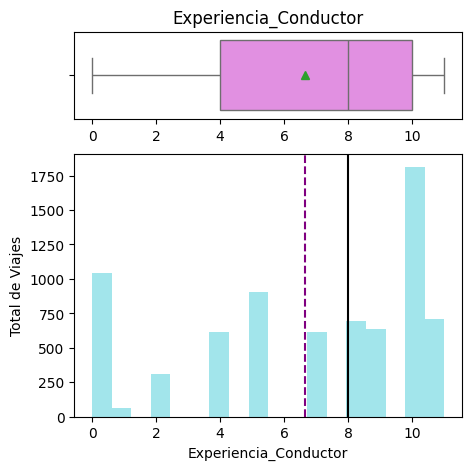

In [362]:
plot_histogram_boxplot(df, "Experiencia_Conductor")

- Existe un patrón muy particular aquí. Los choferes con una experiencia de 10 años, son los que más viajes han realizado. Pero, en segundo lugar, los choferes sin experiencia (0 años) son los segundos que hacen más viajes. Esto genera una pregunta ¿Existe algún problema con los datos de los conductores con 0 años de experiencia? Probablemente, esto se resuelva en el análisis multivariable.

## Rendimiento Promedio del Vehículo

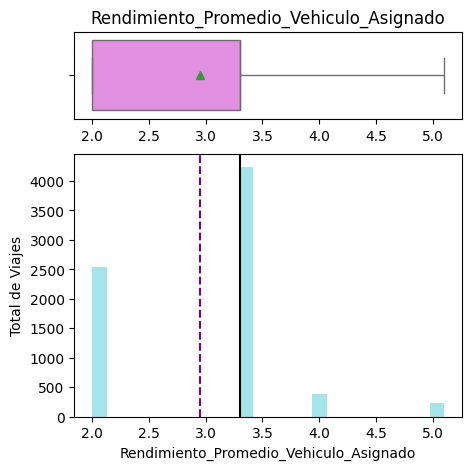

In [363]:
plot_histogram_boxplot(df, "Rendimiento_Promedio_Vehiculo_Asignado")

- Podemos ver que existe una mayor concentración de viajes con bajo y medio rendimiento (2.0 y 3.3 respectivamente). Lo que nos habla de posibles problemas, como malos hábitos de manejo, robo de diesel, falta de mantenimiento de las unidades, unidades viejas, etc.
- Valdría la pena explorar en el análisis multivariable si existe alguna correlación entre la experiencia del conductor y el rendimiento, al igual que el rendimiento y el peso de la carga, o incluso el rendimiento y el vehículo seleccionado.

## Capacidades Máximas del Vehículo y Caja

[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


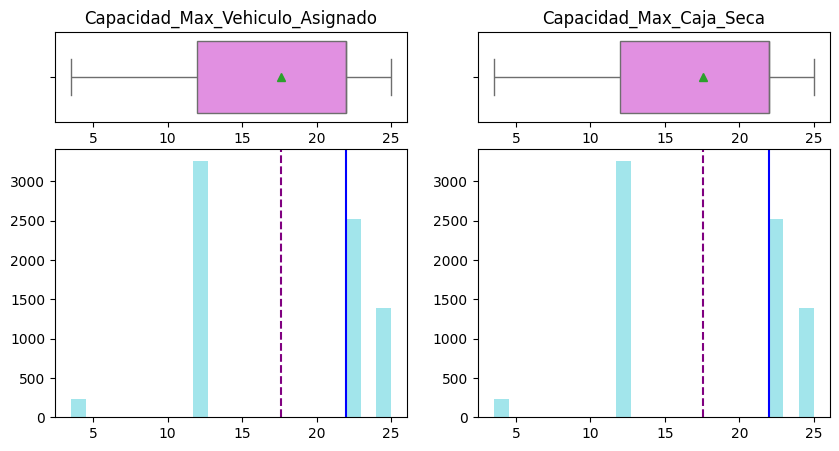

In [364]:
create_grid_of_plots(df, ["Capacidad_Max_Vehiculo_Asignado","Capacidad_Max_Caja_Seca"])

- Como podemos ver en las gráficas, son idénticas, por lo que podemos desechar una de las dos. En este caso se optó por la capacidad máxima del vehículo asignado.
- Podemos ver que la mayoría de los viajes son realizados con un vehículo que soporta un tonelaje de aproximadamente 13 Toneladas. En segundo lugar tenemos un tonelaje más alto, de aproximadamente 23 toneladas.

In [365]:
# Removemos la columna con datos identicos
df.drop('Capacidad_Max_Vehiculo_Asignado', axis=1, inplace=True)

### Número de Pellets y Peso de la Carga

[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


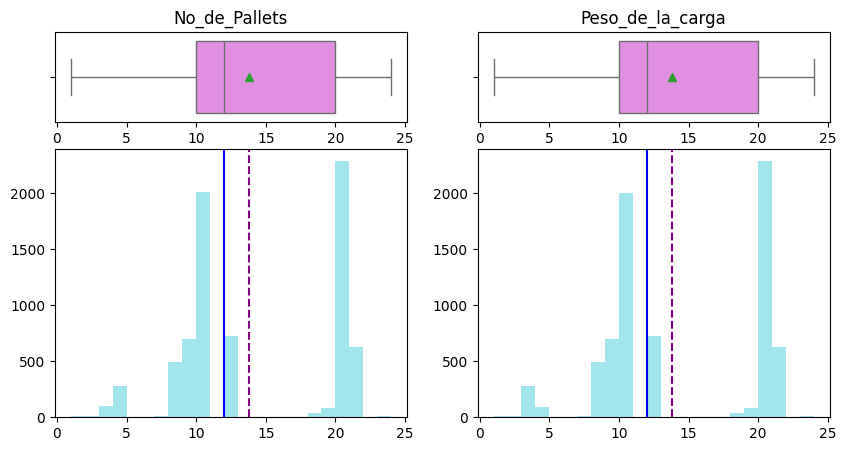

In [366]:
create_grid_of_plots(df, ["No_de_Pallets","Peso_de_la_carga"])

- Podemos ver que de igual manera, estas dos variables son prácticamente idénticas, por lo que podemos precindir de una de ellas para reducir la complejidad del modelo. En este caso desecharemos el No. de Pellets.
- Podemos ver que la mayoría de los viajes llevan cargas de 20 y 13 toneladas.
- El promedio de peso por viaje es de 13 toneladas, lo que hace match con el promedio de carga máxima soportada.

In [367]:
# Removemos la columna con datos identicos
df.drop('No_de_Pallets', axis=1, inplace=True)

### Precio del Viaje

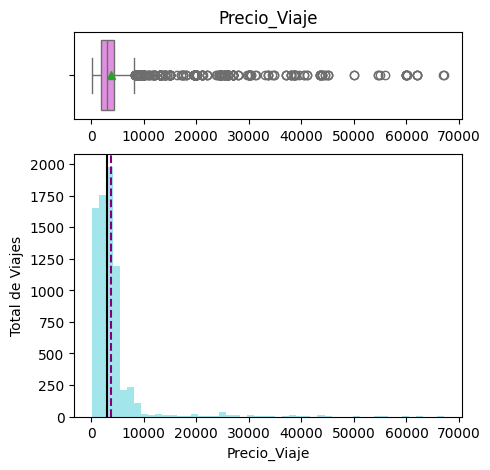

In [368]:
plot_histogram_boxplot(df, "Precio_Viaje")

- Podemos ver que la mayoría de los viajes tienen un precio máximo de \$10,000
- Muy pocos viajes son de más de \$10,000.
- Los precios parecieran no estar estandarizados, por lo que valdría la pena revisar los motivos para esto.
- El precio promedio por viaje es de aproximadamente de \$3,500

### Distancia de los viajes

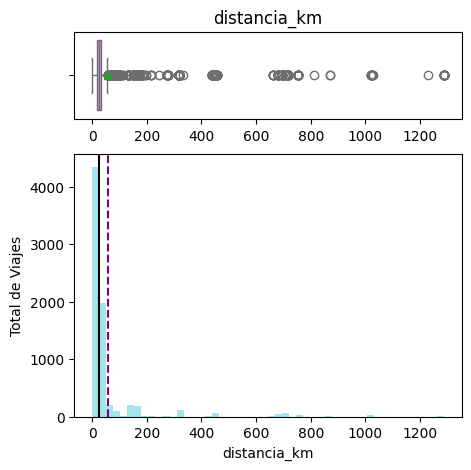

In [369]:
plot_histogram_boxplot(df, "distancia_km")

- Podemos ver que existe una forma muy similar entre la distancia viajada vs. el precio de cada viaje. Valdría la pena revisitar esto con mayor detalle en el análisis multivariable.
- La mayor parte de los viajes son de menos de 250km


Hecho este análisis, procederemos a hacer lo mismo para las variables categóricas o tipo objeto.

## Variables Tipo Objeto

In [370]:
# Esta función nos permite generar la gráfica de barras para una variable
# categórica, mostrando su porcentaje en la parte superior de la gráfica
def perc_on_bar(data,z, ax2 = None, size =(15, 6)):
    total = len(data[z])
    if ax2 == None:
      plt.figure(figsize=size)
      ax = sns.countplot(data= data, x = z,palette='Paired')
    else:
      ax = sns.countplot(data= data, x = z,ax = ax2,palette='Paired')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x()
        y = p.get_y() + p.get_height()+15
        ax.set_title(z)
        ax.set_ylabel('Total de Viajes')
        ax.annotate(percentage, (x, y), size = 10)

# Esta función genera una matriz de gráficas de barras
def create_grid_of_perc_on_bar(data, cols, figsize=(30, 10)):
    num_rows = int(np.ceil(len(cols) / 3))
    if len(cols) < 3:
      num_cols = len(cols)
    else:
      num_cols = 3

    plt.figure(figsize=figsize)
    fig, axes = plt.subplots(nrows = num_rows, ncols=num_cols, figsize=figsize)
    if num_rows == 1:
      for i, col in enumerate(cols):
        ax2 = axes[i]
        perc_on_bar(data, col, ax2)

    else:
      row = -1
      for i, col in enumerate(cols):
          if i%3==0:
            row+=1
          print(row,i%3)
          ax2 = axes[row,i%3]
          perc_on_bar(data, col, ax2)

    plt.tight_layout()
    plt.show()

### Cliente

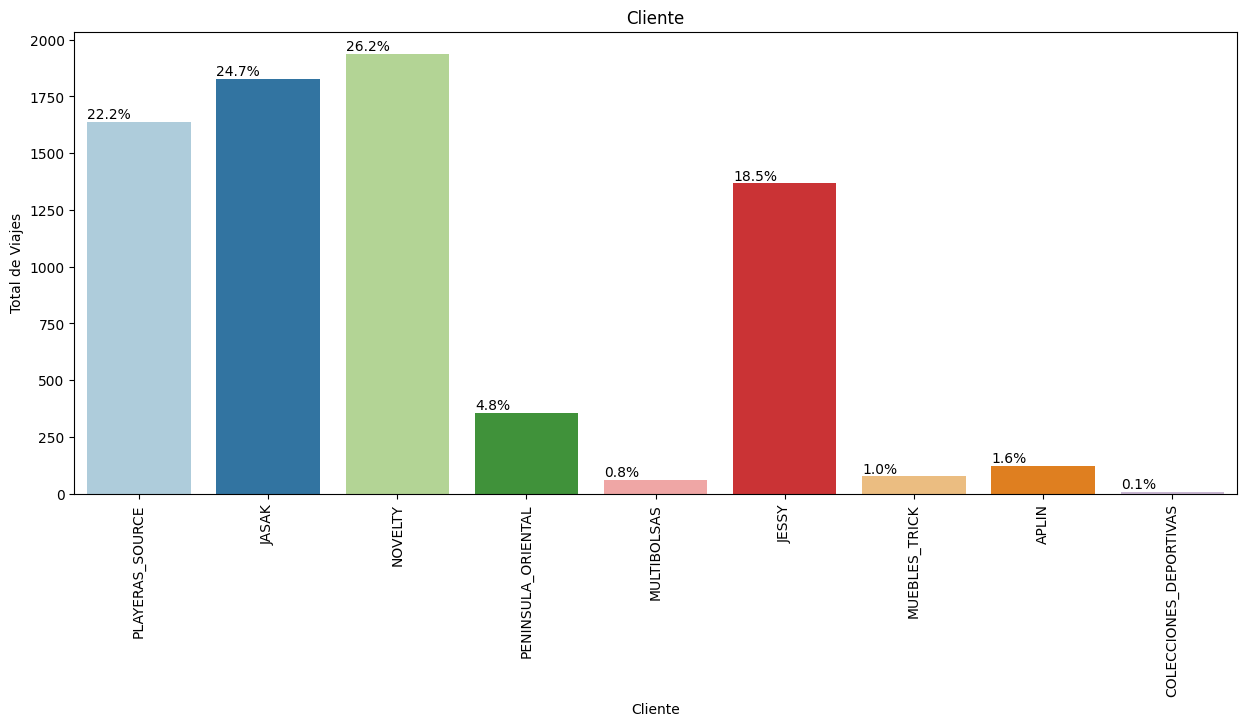

In [371]:
perc_on_bar(df, "Cliente")

- Como se mencionaba en puntos anteriores, existe una diferencia significativa en el porcentaje de viajes de los clientes prioritarios y los secundarios.
- NOVELTY cuenta con el 26.2% del total de viajes
- Su cliente con menos viajes es colecciones deportivas con el 0.1%

### Conductor

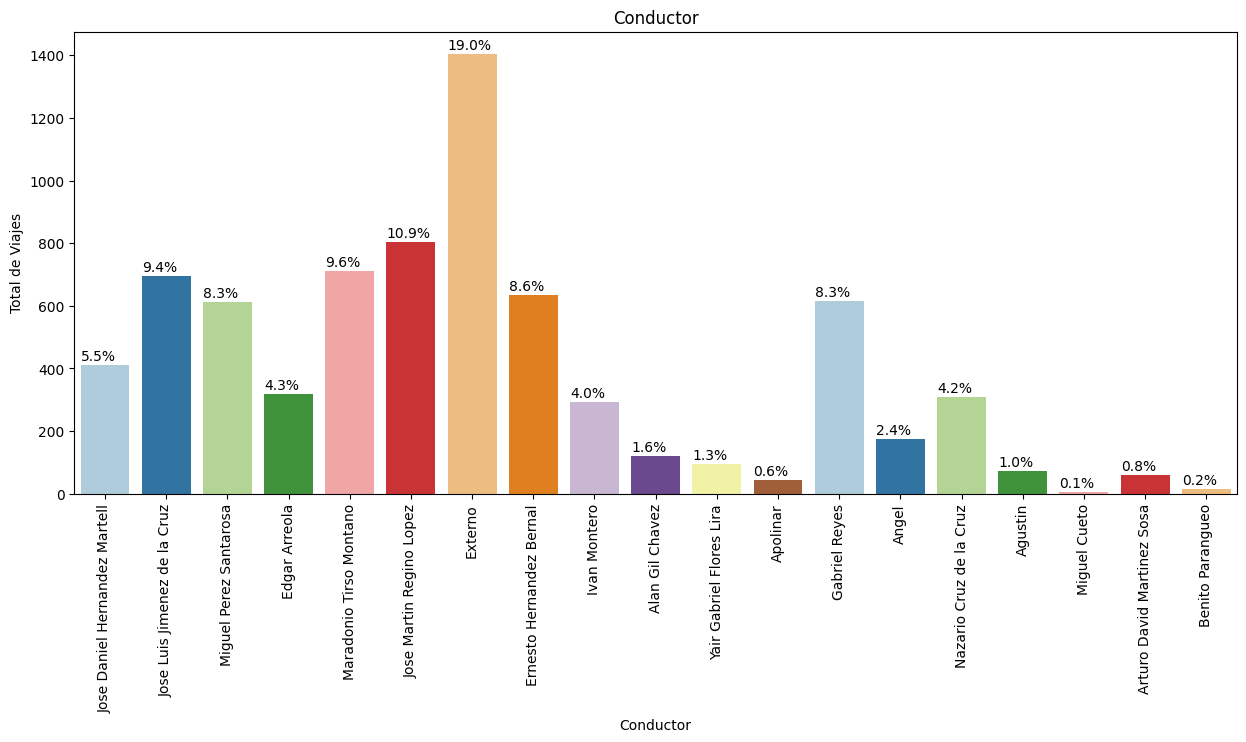

In [372]:
perc_on_bar(df, "Conductor")

- En esta gráfica podemos ver que el 19% de los viajes son realizados por conductores externos, lo que nos habla de una falta de capacidad para completar las operaciones. Esto puede ser por fuga de personal o por un crecimiento estancado de la empresa.
- El conductor con mayor porentaje de viajes es Jose Luis Jimenez de la Cruz con el 9.4%
- El conductor con menor porcentaje de viajes es Miguel Cueto con 0.1%
- Hay que revisar el status de cada conductor a ver si existe alguna correlación entre con su porcentaje de viajes.

### Status de Conductor

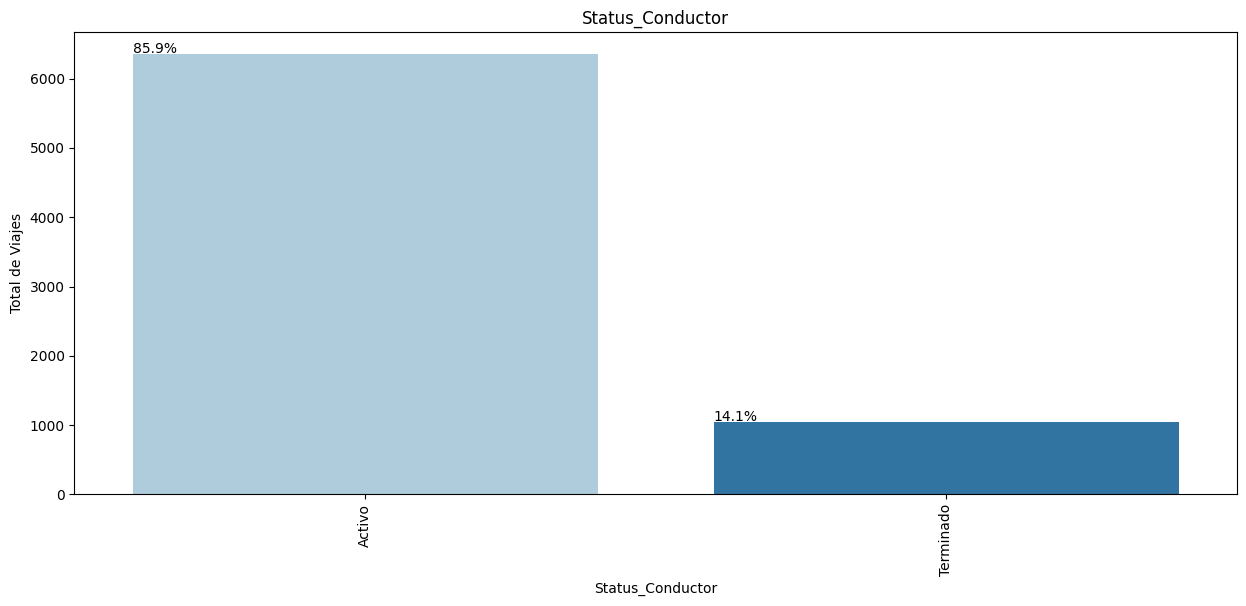

In [373]:
perc_on_bar(df, "Status_Conductor")

- El 85.9% de los viajes realizados fueron hechos por conductores aún activos
- Valdría la pena revisar si existe alguna correlación entre los conductores terminados y los viajes incompletos.

## Tipo de Servicio Solicitado

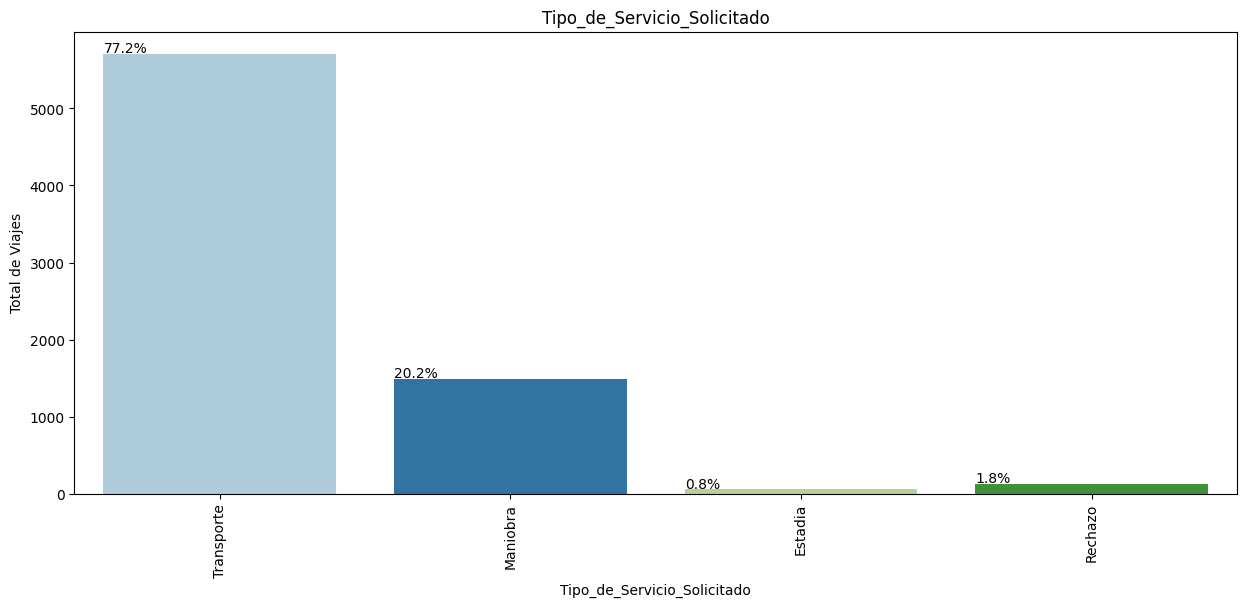

In [374]:
perc_on_bar(df, "Tipo_de_Servicio_Solicitado")

- Podemos ver que los principales servicios de TFL son el transporte de mercancías (77.2%) y las maniobras (20.2%)
- La estadía y el rechazo tienen un diferencia abismal comparado con el resto de los servicios. Esto es debido a que estos son complementos de los servicios de Transporte y Maniobra

### Tipo de Vehiculo Solicitado

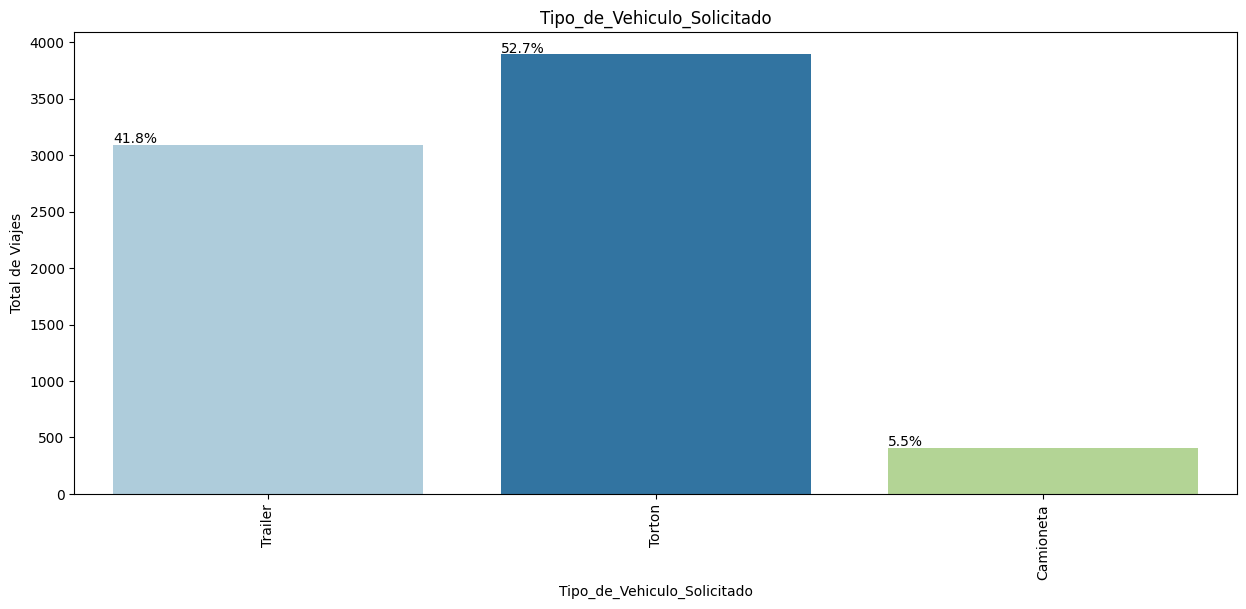

In [375]:
perc_on_bar(df, "Tipo_de_Vehiculo_Solicitado")

- El tipo de vehículo que más se solicita son los torton (52.7%) y trailer con 41.8%, esto puede ser por el tipo de cargamento y el peso de este, que manejan los clientes con mayor frecuencia.
- Esto puede ser un indicador sobre qué tipo de vehículos son los que más unidades deben existir en la flotilla
- En el caso de la camioneta, valdría la pena revisar si el bajo porcentaje de viajes puede provenir de una falta de conocimiento de la existencia del servicio por parte de los clientes o si se debe buscar otro tipo de clientes más afines a usar este tipo de vehículo.

### Tipo de Vehículo Asignado

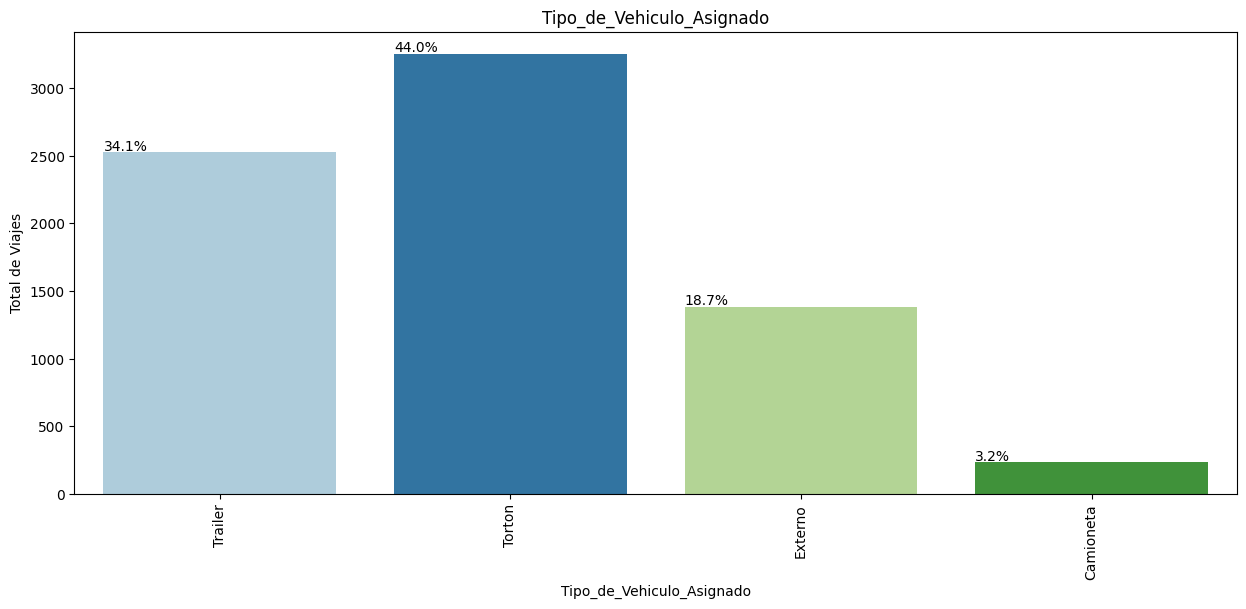

In [376]:
perc_on_bar(df, "Tipo_de_Vehiculo_Asignado")

- Podemos ver que existe una gran similitud en la forma de cada categoría, mostrando que se cubren las necesidades del cliente en la mayoría de los casos.
- La diferencia en el porcentaje de solicitados y asignados cae en la nueva categoría de "Externo", que como se explicaba en secciones anteriores, es el uso de vehículos y conductores de empresas hermanas para cubrir la necesidad del viaje, debido a una falta de capacidad en el negocio.

### ID de las cajas y de los vehículos asignados

<Figure size 3000x1000 with 0 Axes>

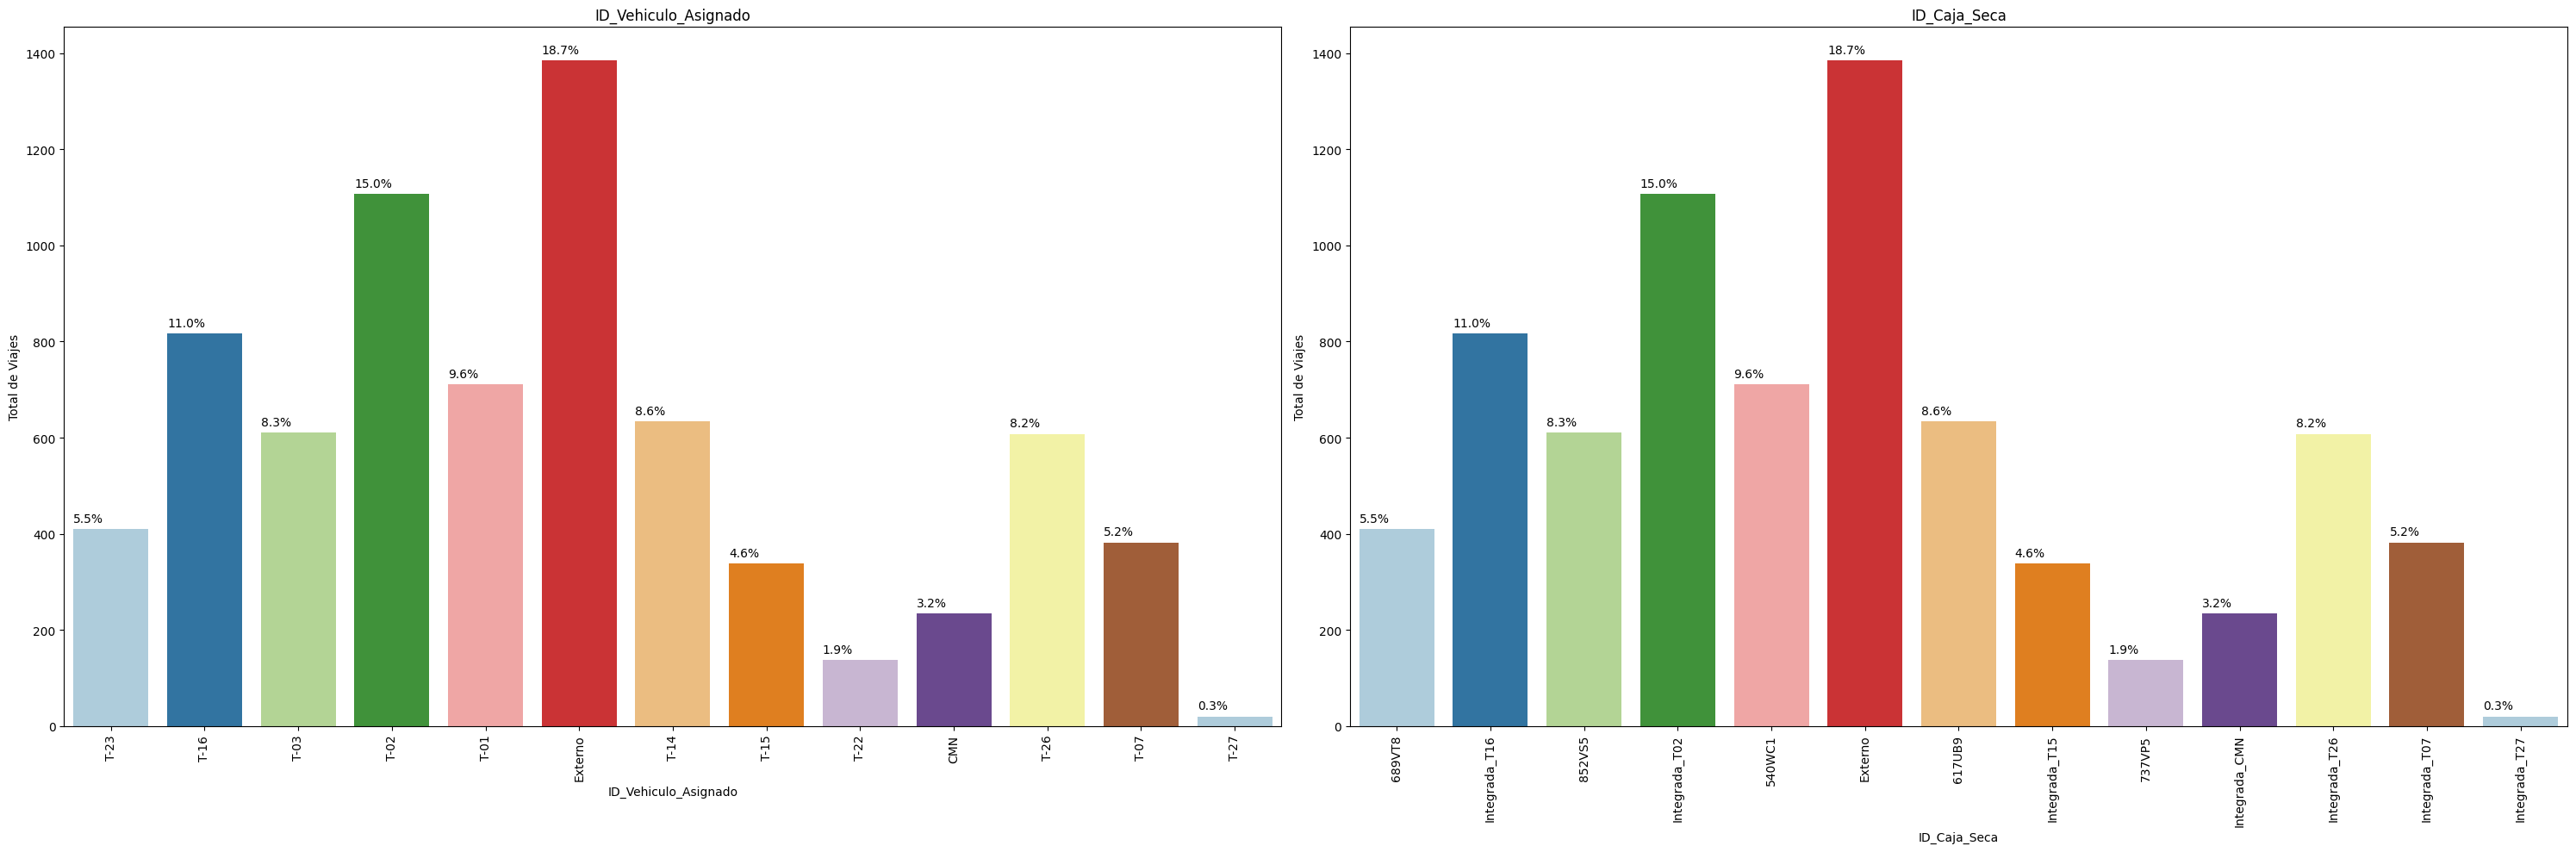

In [377]:
create_grid_of_perc_on_bar(df, ["ID_Vehiculo_Asignado", "ID_Caja_Seca"])

- Podemos ver que son prácticamente idénticos ambos features, por lo que podemos eliminar uno para evitar redundancia y reducir la complejidad del modelo. En este caso removeremos el ID de la caja seca.
- Podemos ver que el vehículo disonible más asignado es el T-02, siendo un Torton Freightliner 1997, con una capacidad de 12 Toneladas
- Igual podemos ver la tendencia de asignar vehículos externos para cubrir la demanda de los clientes

In [378]:
# Removemos la columna con datos identicos
df.drop('ID_Caja_Seca', axis=1, inplace=True)

### Tipo de Cargamento

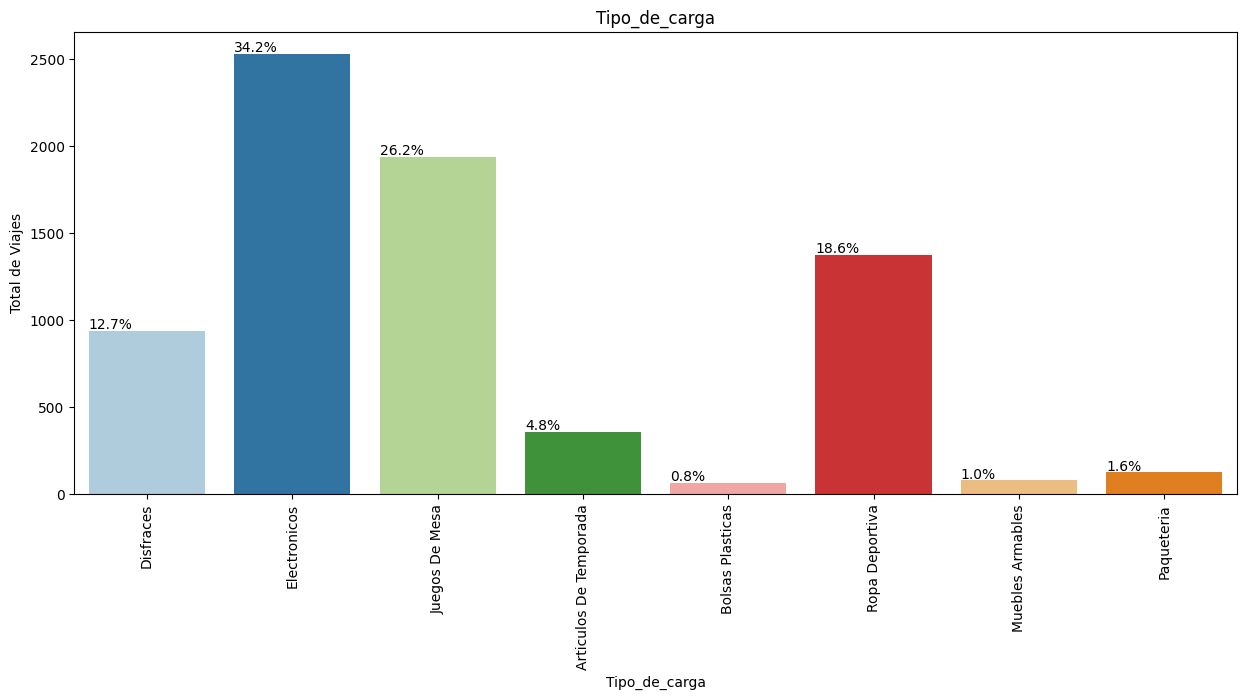

In [379]:
perc_on_bar(df, "Tipo_de_carga")

- El tipo de cargamento con mayor cantidad de viajes son Electrónicos y en segundo lugar son los juegos de mesa

### Tipo de Empaquetado de la Mercancía


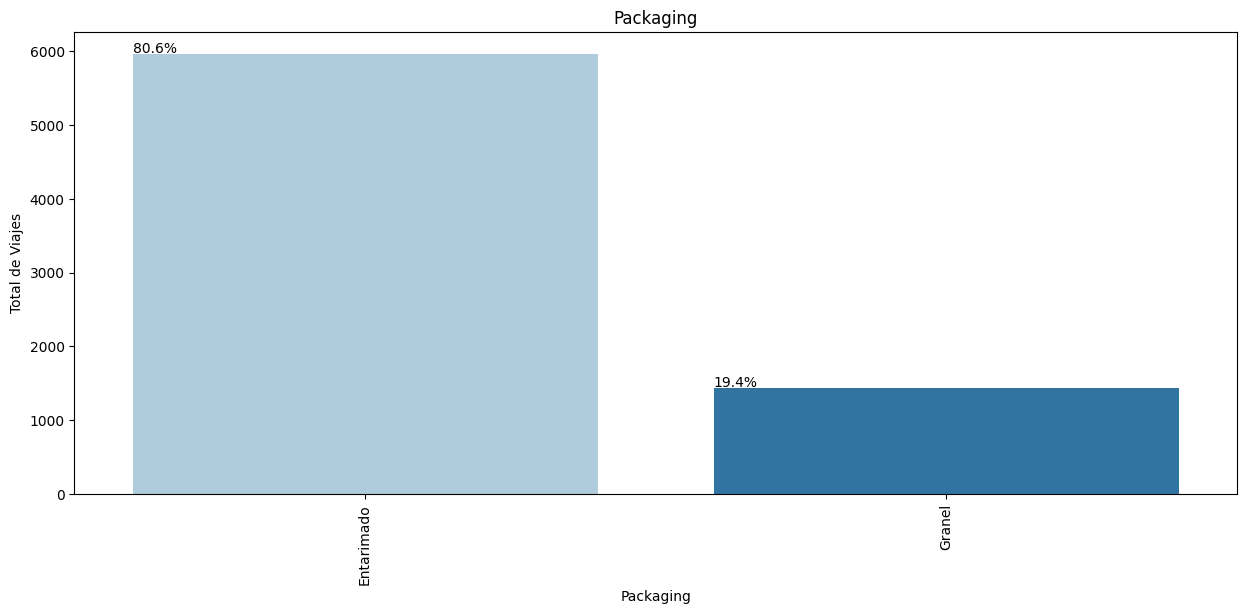

In [380]:
perc_on_bar(df, "Packaging")

- El 80% de sus mercancias son entarimadas, mientras que el 19.4% están a Granel
- Valdría la pena revisar si existe alguna correlación entre el tipo de empaquetado y el status del viaje para descartar que esto pueda ser un factor que afecte la seguridad de la carga

### Status de Orden

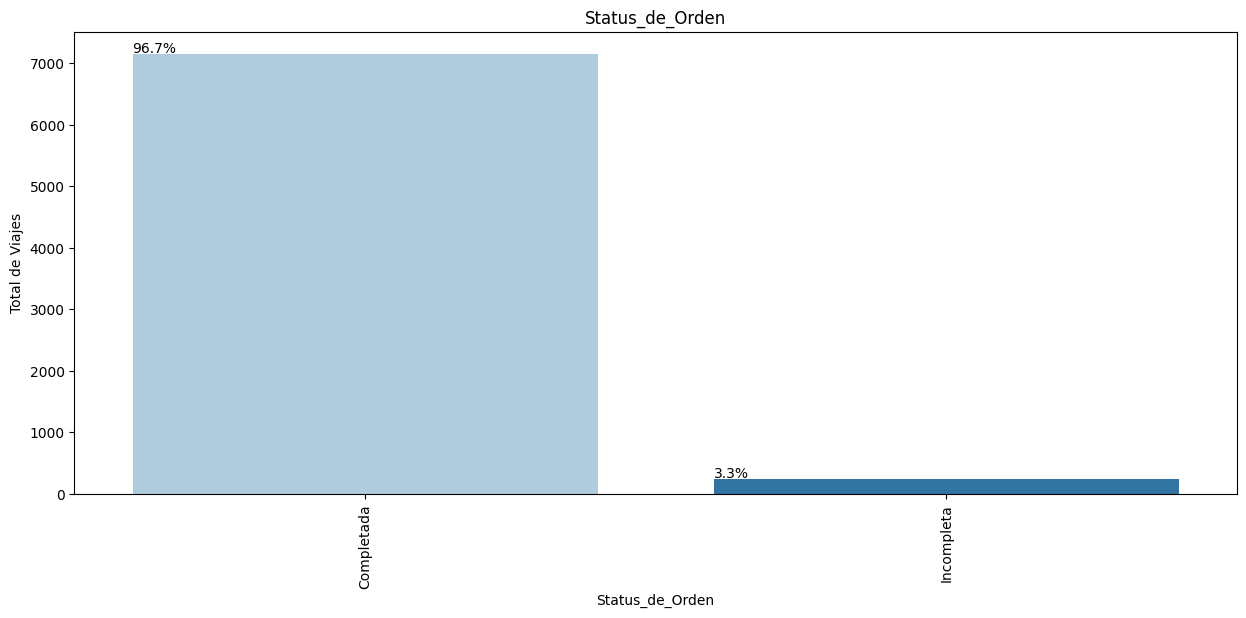

In [381]:
perc_on_bar(df, "Status_de_Orden")

- Podemos ver que TFL cumple con el 96.7% de sus viajes
- Este desbalance del feature podría causar problemas al momento de entrenar el modelo, por lo que se tendrá que balancear la clase para evitar algún sesgo


Ya terminado el análisis univariable podemos proceder al análisis multivariable. En este análisis podemos ver la correlación de los datos, patrones, etc.

## Análisis Multivariable

### Correlación de los datos numéricos

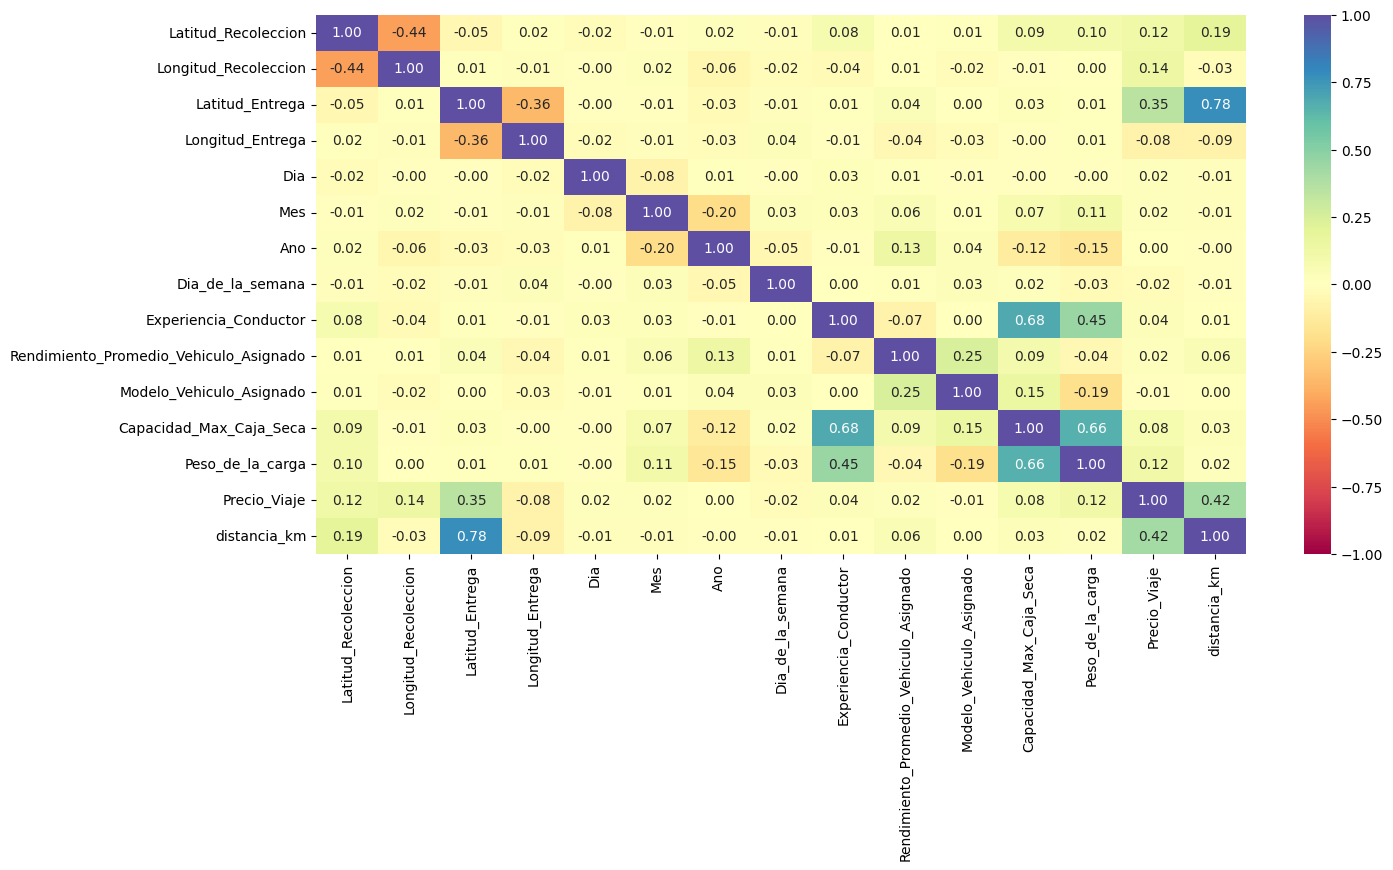

In [382]:
plt.figure(figsize=(15,7))
sns.heatmap(df.select_dtypes(include=['int', 'float']).corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='Spectral')
plt.show()

- Podemos ver que existe una correlación positiva entre el precio del viaje y la distancia en Km de este. Esto suena lógico porque a más distancia, mayor el consumo de combustible, ergo, costos mas elevados. Sin embargo, esta es medianamente fuerte, por lo que sugiere que no hay una estandarización de precios.
- Existe una correlación fuerte entre las cargas más pesadas y los conductores más experimentados. Esto parece ser correcto por la necesidad de un mejor manejo de la unidad y un mejor conocimiento del camino
- De igual manera existe una correlación fuerte entre el peso de la carga y la capacidad de máxima de la carga, lo que suena lógico debido a que dependiendo la carga, se seleccionará que vehículo puede soportar el peso.
- Existe una ligera correlación negativa entre el peso de la carga y el año del vehículo, mostrando que se le asigan los viajes más pesados a las unidades más antiguas, probablemente debido a su capacidad. Esto puede presentar un posible riesgo de fallas durante el trayecto.
- No existe una correlación relevante entre la experiencia del conductor y el rendimiento del combustible.
- Existe una ligera correlación positiva entre el año del vehículo y el rendimiento, mostrando que las unidades más nuevas tienen un rendimiento mejor.

## Análisis Multivariable

### Fecha de Viaje vs. Precio del Viaje

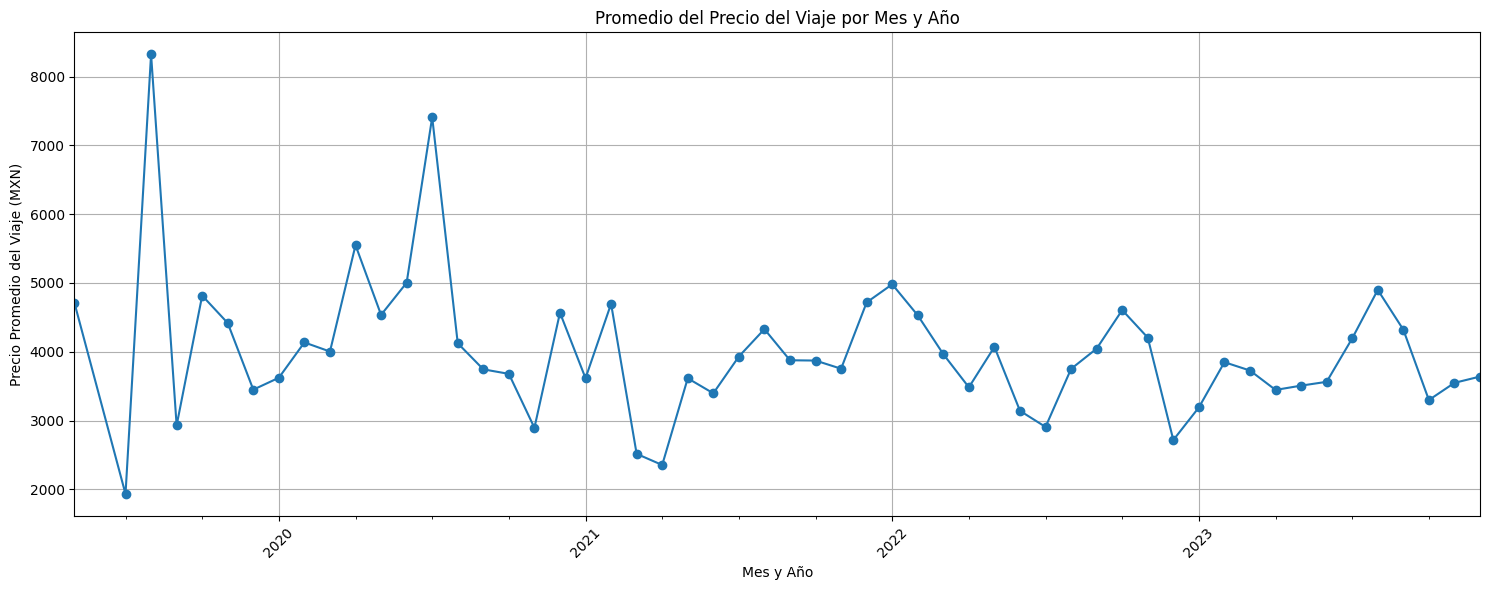

In [383]:
# Primero generamos un dataframe que contenga la variable en conjunto de Fecha
df_fechas = df[["Ano","Mes","Dia","Precio_Viaje"]].copy()
df_fechas['Fecha'] = df_fechas['Ano'].astype(str) + '-' + df_fechas['Mes'].astype(str) + '-' + df_fechas['Dia'].astype(str)
df_fechas['Fecha'] = pd.to_datetime(df_fechas['Fecha'])

# Agrupamos las fechas por mes y año y csacamos el promedio del precio del viaje
df_fechas['Mes y Año'] = df_fechas['Fecha'].dt.to_period('M')

promedio_precios = df_fechas.groupby('Mes y Año')['Precio_Viaje'].mean()

# Mostramos la gráfica
plt.figure(figsize=(15, 6))
promedio_precios.plot(kind='line', marker='o')
plt.title('Promedio del Precio del Viaje por Mes y Año')
plt.xlabel('Mes y Año')
plt.ylabel('Precio Promedio del Viaje (MXN)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

- Podemos ver que los precios más elevados se tuvieron entre el 2019 y 2020, llegando a un promedio entre \$7,500 MXN.
- En los siguientes años se estabilizó entre los \$3,000 y $5,000
- La alza de precios puede significar algún cambio dentro de la empresa o en los clientes. De igual manera la Pandemia pudo haber sido factor.

### Fecha vs. Status de Orden

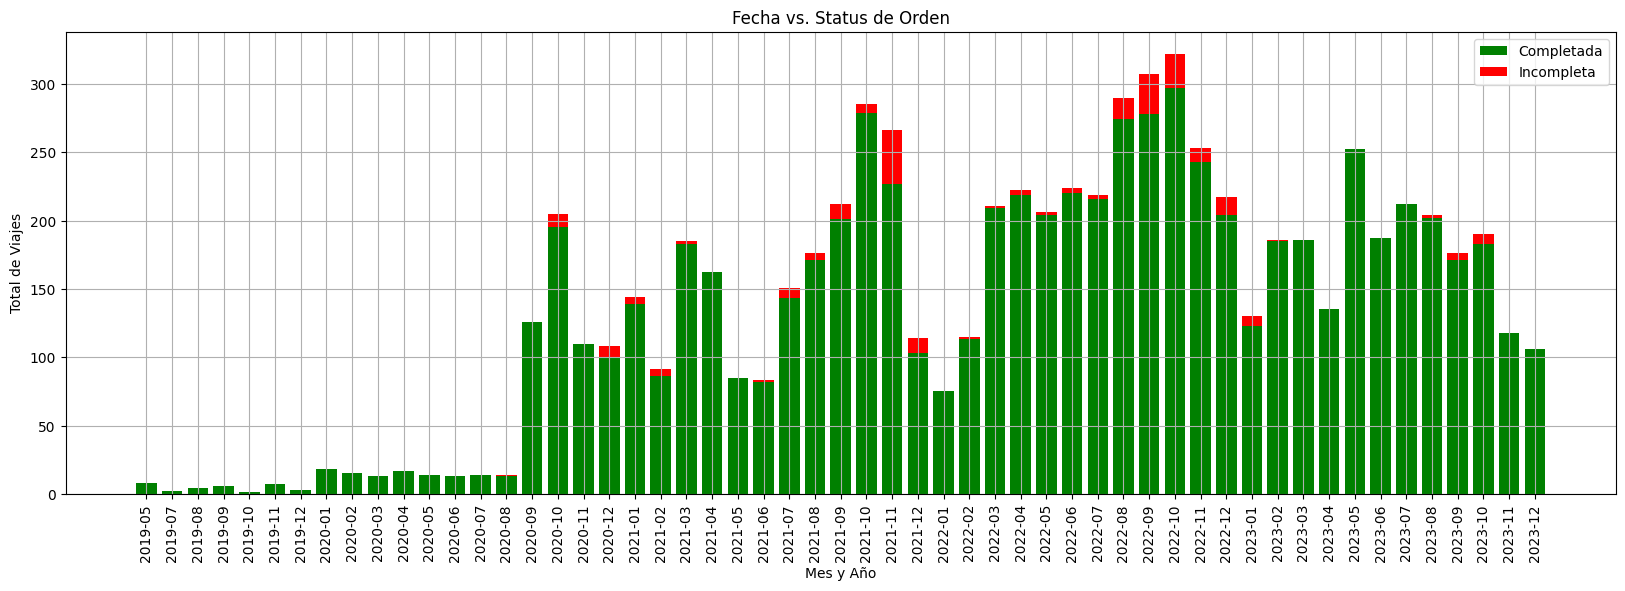

In [384]:
# Primero generamos un dataframe que contenga la variable en conjunto de Fecha
df_fechas = df[["Ano","Mes","Dia","Status_de_Orden"]].copy()
df_fechas['Fecha'] = df_fechas['Ano'].astype(str) + '-' + df_fechas['Mes'].astype(str) + '-' + df_fechas['Dia'].astype(str)
df_fechas['Fecha'] = pd.to_datetime(df_fechas['Fecha'])

# Agrupamos las fechas por mes y año y csacamos el promedio del precio del viaje
df_fechas['Mes y Año'] = df_fechas['Fecha'].dt.to_period('M')

stacked_data = df_fechas.groupby(['Mes y Año', 'Status_de_Orden']).size().unstack(fill_value=0)
stacked_data.index = stacked_data.index.astype(str)
plt.figure(figsize=(20, 6))
plt.bar(stacked_data.index, stacked_data['Completada'], color='g')
plt.bar(stacked_data.index, stacked_data['Incompleta'], bottom=stacked_data['Completada'], color='r')
plt.xlabel("Mes y Año")
plt.ylabel("Total de Viajes")
plt.legend(["Completada", "Incompleta"])
plt.title("Fecha vs. Status de Orden")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

- Existe un patrón entre el periodo agosto-noviembre y el ratio de ordenes incompletas. Probablemente esto es debido a que es temporada alta para las empresas y hay problemas de logistica.
- Noviembre de 2021 fue el mes con mayor nivel de ordenes incompletas

### Conductor vs. Status de Orden


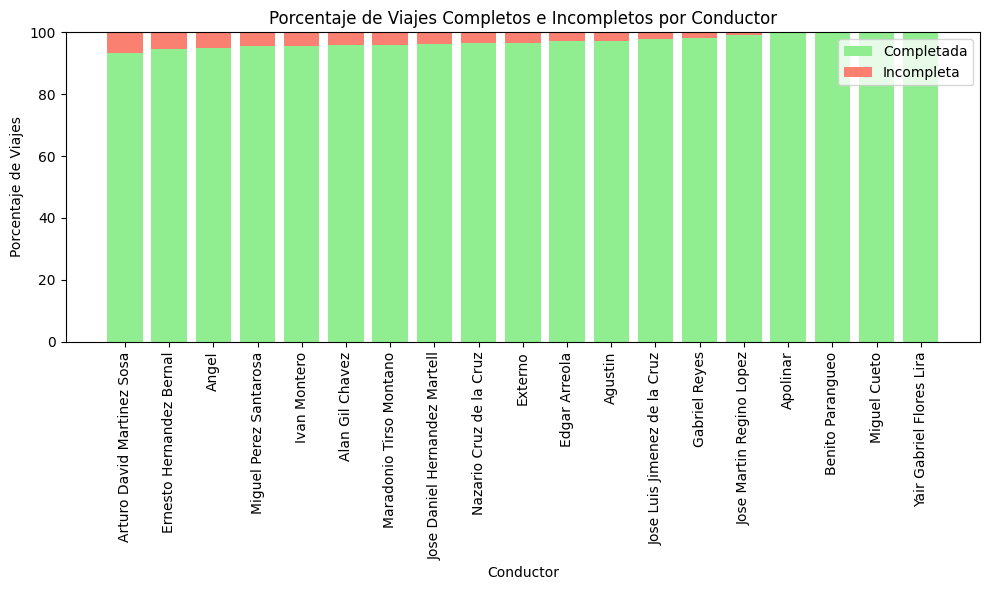

In [385]:
# Calcular el número de viajes completos e incompletos por conductor
viajes_por_conductor = df.groupby('Conductor')['Status_de_Orden'].value_counts().unstack().fillna(0)

# Calcular el porcentaje de viajes completos e incompletos por conductor
viajes_por_conductor['Total'] = viajes_por_conductor.sum(axis=1)
viajes_por_conductor['Porcentaje_Completado'] = viajes_por_conductor['Completada'] / viajes_por_conductor['Total'] * 100
viajes_por_conductor['Porcentaje_Incompleto'] = viajes_por_conductor['Incompleta'] / viajes_por_conductor['Total'] * 100
viajes_por_conductor = viajes_por_conductor.sort_values(by='Porcentaje_Incompleto', ascending=False)


# Graficar
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_conductor.index, viajes_por_conductor['Porcentaje_Completado'], label='Completada', color='lightgreen')
plt.bar(viajes_por_conductor.index, viajes_por_conductor['Porcentaje_Incompleto'], label='Incompleta', bottom=viajes_por_conductor['Porcentaje_Completado'], color='salmon')
plt.xlabel('Conductor')
plt.ylabel('Porcentaje de Viajes')
plt.title('Porcentaje de Viajes Completos e Incompletos por Conductor')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


###  Conductor vs. Experiencia vs. Status del Conductor

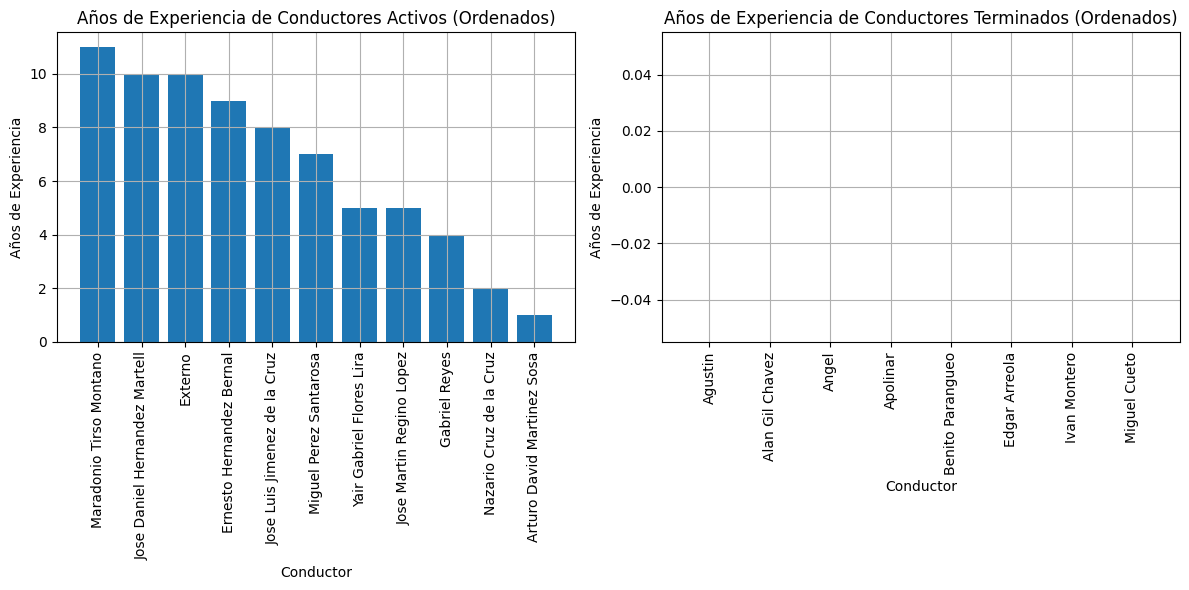

In [386]:
# Filtramos el DataFrame para conductores con estado "Activo" y "Terminado"
df_activo = df[df["Status_Conductor"] == "Activo"].copy()
df_terminado = df[df["Status_Conductor"] == "Terminado"].copy()

# Calculamos los años de experiencia para cada conductor
años_de_experiencia_activo = df_activo.groupby('Conductor')['Experiencia_Conductor'].mean()
años_de_experiencia_terminado = df_terminado.groupby('Conductor')['Experiencia_Conductor'].mean()

# Ordenamos los conductores por años de experiencia de mayor a menor
años_de_experiencia_activo = años_de_experiencia_activo.sort_values(ascending=False)
años_de_experiencia_terminado = años_de_experiencia_terminado.sort_values(ascending=False)

# Creamos una figura con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficamos para conductores "Activo"
axs[0].bar(años_de_experiencia_activo.index, años_de_experiencia_activo)
axs[0].set_xlabel('Conductor')
axs[0].set_ylabel('Años de Experiencia')
axs[0].set_title('Años de Experiencia de Conductores Activos (Ordenados)')
axs[0].tick_params(axis='x', rotation=90)
axs[0].grid(True)
# Graficamos para conductores "Terminado"
axs[1].bar(años_de_experiencia_terminado.index, años_de_experiencia_terminado)
axs[1].set_xlabel('Conductor')
axs[1].set_ylabel('Años de Experiencia')
axs[1].set_title('Años de Experiencia de Conductores Terminados (Ordenados)')
axs[1].tick_params(axis='x', rotation=90)
axs[1].grid(True)

# Ajustamos el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

- Aquí comprobamos la asunción previa de que los conductores terminados tienen 0 años de experiencia en la tabla, esto puede llegar a tomarse como datos nulos. Estos datos podrían ser rellenados tomando en cuenta el primer año que aparecen en los datos como su año de inicio y el último año disponible en sus viajes como su último año.
- Adicional a esto, podemos ver que 8 de sus 10 choferes cuentan con más de 4 años de experiencia por lo que podemos decir que tienen la mayor parte de sus conductores son experimentados.
- Sus choferes más experimentados son Maradonio Tirso y Jose Daniel Hernandez

In [387]:
# Procedemos a calcular los años de experiencia de los choferes terminados con
# base en los datos disponibles en la base de datos

# Agrupamos por conductor y calculamos la diferencia entre el año máximo y mínimo
experiencia_por_conductor = df.groupby('Conductor')['Ano'].apply(lambda x: x.max() - x.min()).reset_index()
experiencia_por_conductor.columns = ['Conductor', 'Experiencia_Calculada']

# Fusionamos el DataFrame original con la experiencia calculada
df = pd.merge(df, experiencia_por_conductor, on='Conductor', how='left')

# Sustituimos los valores de Experiencia_Conductor que son 0 por Experiencia_Calculada
df['Experiencia_Conductor'] = df.apply(lambda row: row['Experiencia_Calculada'] if row['Status_Conductor'] == "Terminado" else row['Experiencia_Conductor'], axis=1)

# Eliminamos la columna Experiencia_Calculada si ya no es necesaria
df.drop('Experiencia_Calculada', axis=1, inplace=True)

Volvemos a graficar los datos

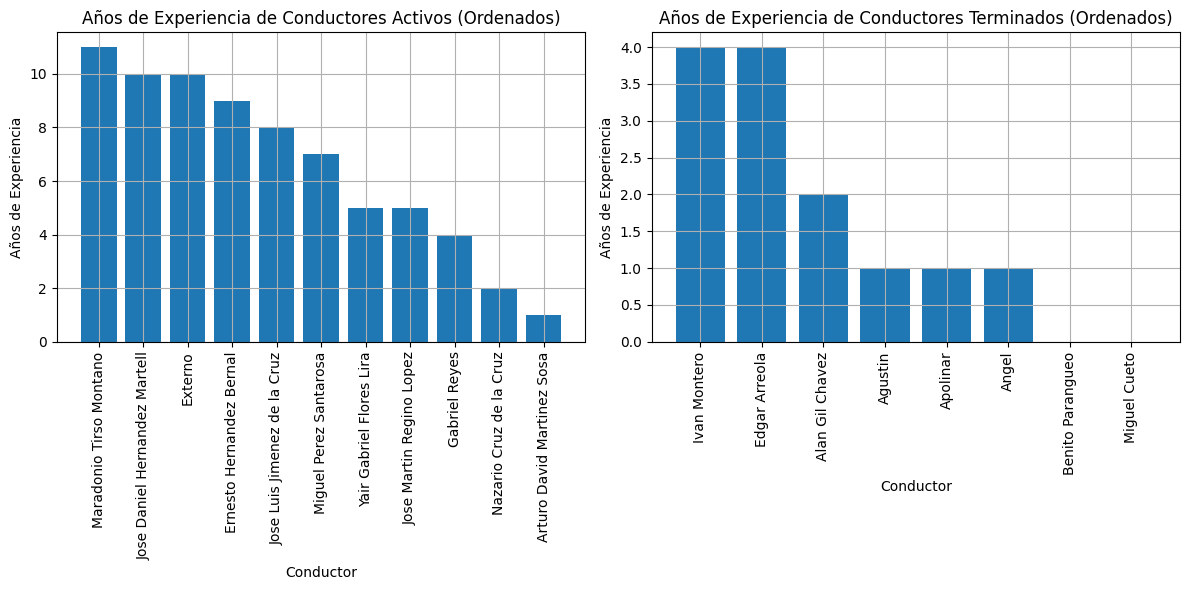

In [388]:
# Filtramos el DataFrame para conductores con estado "Activo" y "Terminado"
df_activo = df[df["Status_Conductor"] == "Activo"].copy()
df_terminado = df[df["Status_Conductor"] == "Terminado"].copy()

# Calculamos los años de experiencia para cada conductor
años_de_experiencia_activo = df_activo.groupby('Conductor')['Experiencia_Conductor'].mean()
años_de_experiencia_terminado = df_terminado.groupby('Conductor')['Experiencia_Conductor'].mean()

# Ordenamos los conductores por años de experiencia de mayor a menor
años_de_experiencia_activo = años_de_experiencia_activo.sort_values(ascending=False)
años_de_experiencia_terminado = años_de_experiencia_terminado.sort_values(ascending=False)

# Creamos una figura con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficamos para conductores "Activo"
axs[0].bar(años_de_experiencia_activo.index, años_de_experiencia_activo)
axs[0].set_xlabel('Conductor')
axs[0].set_ylabel('Años de Experiencia')
axs[0].set_title('Años de Experiencia de Conductores Activos (Ordenados)')
axs[0].tick_params(axis='x', rotation=90)
axs[0].grid(True)
# Graficamos para conductores "Terminado"
axs[1].bar(años_de_experiencia_terminado.index, años_de_experiencia_terminado)
axs[1].set_xlabel('Conductor')
axs[1].set_ylabel('Años de Experiencia')
axs[1].set_title('Años de Experiencia de Conductores Terminados (Ordenados)')
axs[1].tick_params(axis='x', rotation=90)
axs[1].grid(True)

# Ajustamos el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

- Estos datos ya hacen un poco mas de sentido. Edgar Arreola e Ivan Montero teóricamente son conductores con más experiencia que han despedido.

### Conductor vs. ID del Vehiculo Asignado

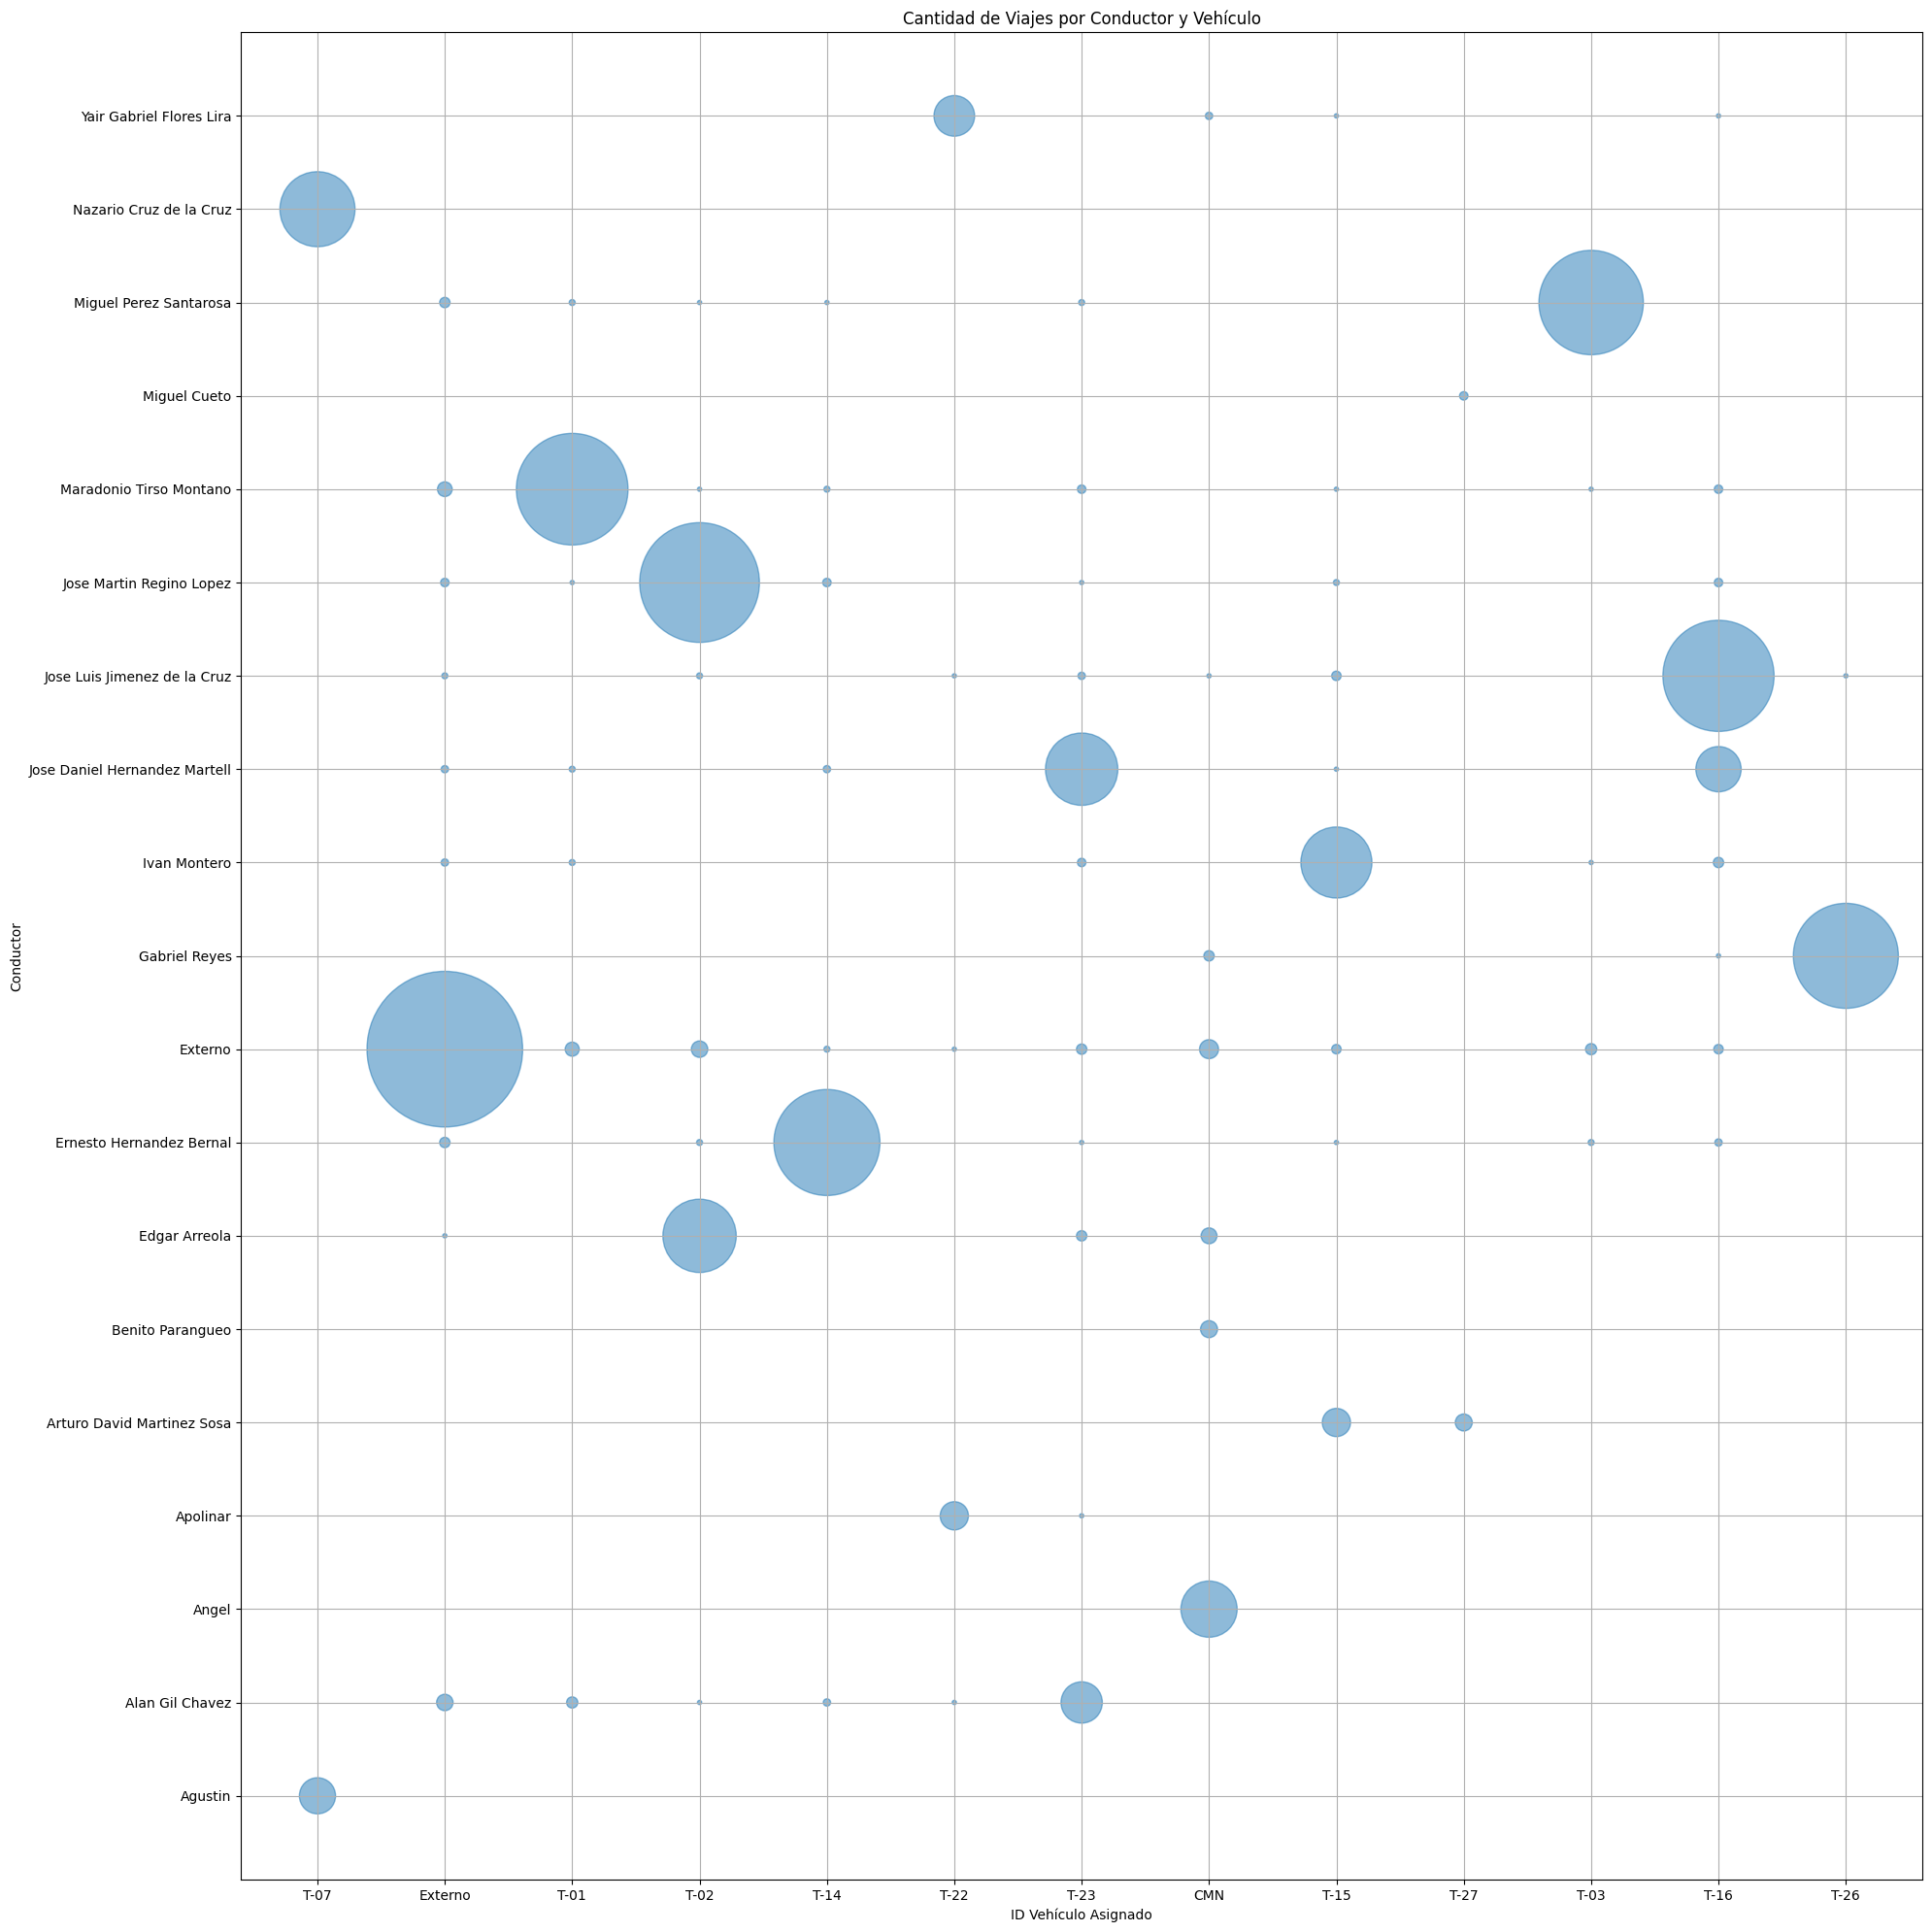

In [389]:
# Contar cuántas veces aparece cada combinación de conductor y vehículo asignado
conteo_conductor_vehiculo = df.groupby(['Conductor', 'ID_Vehiculo_Asignado']).size().reset_index(name='Count')

# Graficar
plt.figure(figsize=(20, 20))
plt.grid(True)
plt.scatter(conteo_conductor_vehiculo['ID_Vehiculo_Asignado'], conteo_conductor_vehiculo['Conductor'], s=conteo_conductor_vehiculo['Count']*10, alpha=0.5)
plt.xlabel('ID Vehículo Asignado')
plt.ylabel('Conductor')
plt.title('Cantidad de Viajes por Conductor y Vehículo')
plt.tight_layout()
plt.show()

- Esta gráfica es bastante interesante porque nos permite ver la concentración de viajes por cada combinación.
- Aquí podemos ver que incluso conductores locales han utilizado vehículos externos y viceversa, conductores externos han usado vehículos locales.
- Las combinaciones más prominentes son:
  * Jose Martin Regino Lopez con el vehículo T-02
  * Maradonio Tirso Montano con el vehículo T-01
  * Miguel Perez Santarosa con el vehículo T-03
  * Jose Luis Jimenez con el T-16
  * Gabriel Reyes con el T-26


### Conductor vs Rendimiento Promedio del Vehículo Asignado

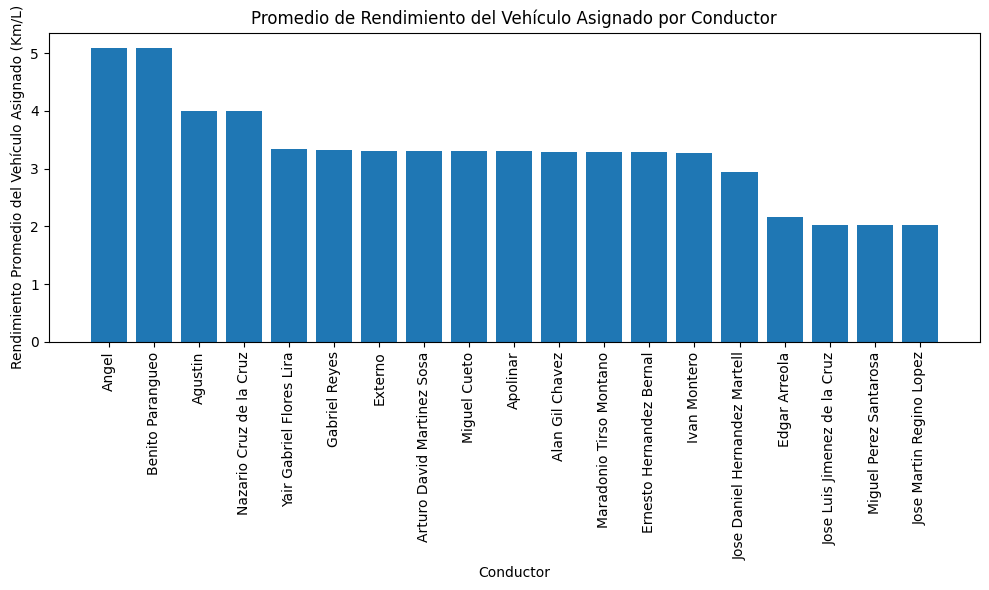

In [390]:
# Agrupar por conductor y calcular el promedio de los rendimientos promedio de los vehículos asignados
rendimiento_promedio_por_conductor = df.groupby('Conductor')['Rendimiento_Promedio_Vehiculo_Asignado'].mean()
rendimiento_promedio_por_conductor = rendimiento_promedio_por_conductor.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(rendimiento_promedio_por_conductor.index, rendimiento_promedio_por_conductor)
plt.xlabel('Conductor')
plt.ylabel('Rendimiento Promedio del Vehículo Asignado (Km/L)')
plt.title('Promedio de Rendimiento del Vehículo Asignado por Conductor')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


- Podemos ver que los conductores con mayor rendimiento son Benito Parangueo, Angel, Agustin y Nazario
-  El promedio esta alrededor de los 3Km/L
- Los conductores con menor rendimiento promedio son Jose Luis Jimenez, Miguel Perez Santarosa y Jose Martin Regino

### Conductor vs. Precio del Viaje

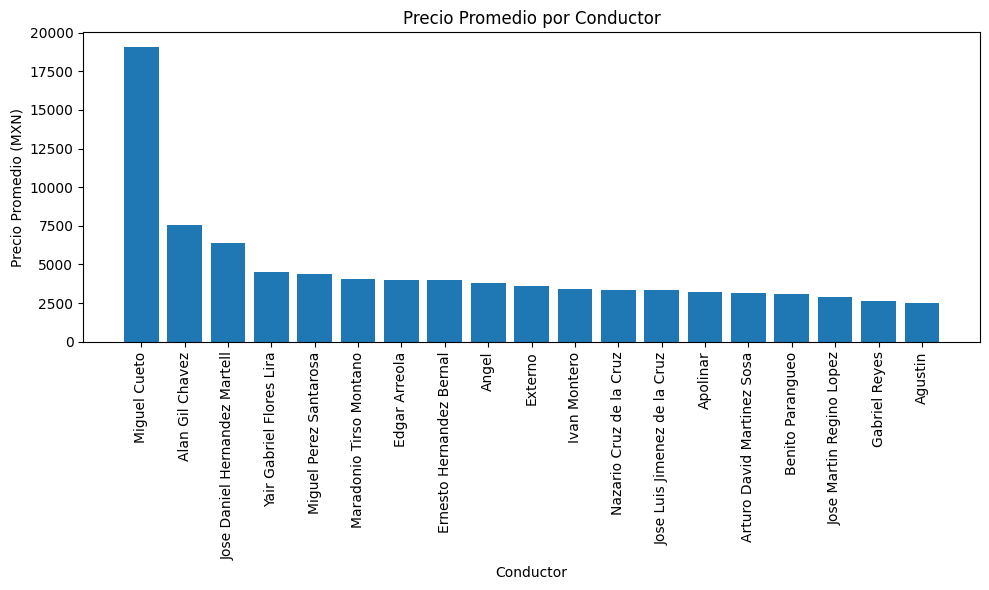

In [391]:
# Agrupar por conductor y calcular el promedio de los Precios Promedio de
# los viajes
precio_promedio_por_conductor = df.groupby('Conductor')['Precio_Viaje'].mean()
precio_promedio_por_conductor = precio_promedio_por_conductor.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(precio_promedio_por_conductor.index, precio_promedio_por_conductor)
plt.xlabel('Conductor')
plt.ylabel('Precio Promedio (MXN)')
plt.title('Precio Promedio por Conductor')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Miguel Cueto por mucho se ha llevado los viajes más caros (más de \$17,500 en promedio)
- El resto de los conductores están dentro del rango de entre \$7,500 y \$2,500 en promedio.

### Conductor vs. Peso de la Carga vs. Tipo de Vehiculo Asignado

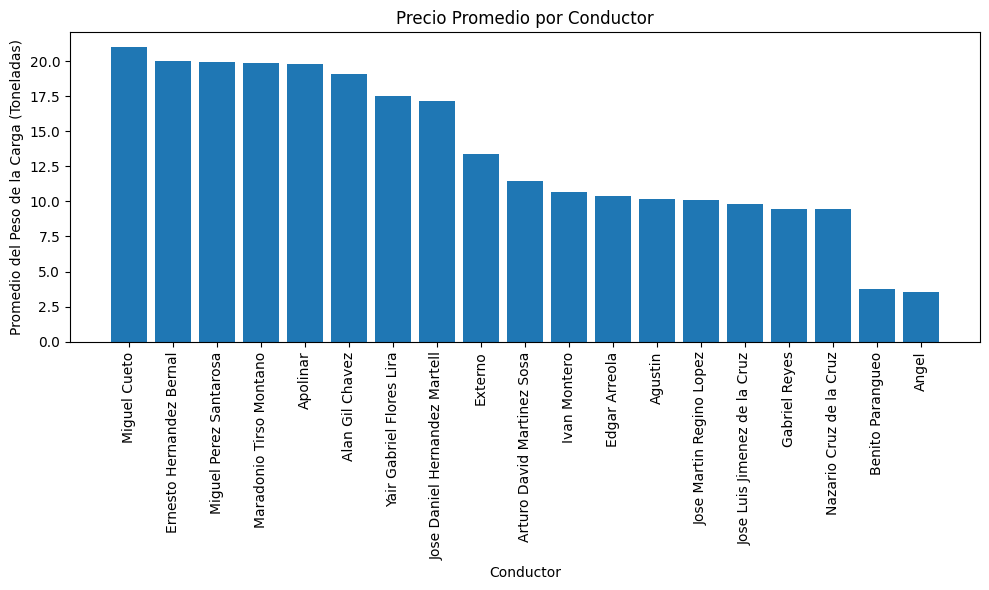

In [392]:
# Agrupar por conductor y calcular el promedio del peso de la carga
Peso_de_la_carga_por_conductor = df.groupby('Conductor')['Peso_de_la_carga'].mean()
Peso_de_la_carga_por_conductor = Peso_de_la_carga_por_conductor.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(Peso_de_la_carga_por_conductor.index, Peso_de_la_carga_por_conductor)
plt.xlabel('Conductor')
plt.ylabel('Promedio del Peso de la Carga (Toneladas)')
plt.title('Precio Promedio por Conductor')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Miguel Cueto, Ernesto Hernandez, Miguel Perez Satnarosa, Maradonio Tirso, Apolinar y Alan Gil Chavez son los coductores que mayor peso manejan en promedio en sus viajes.
- Angel y Benito Parangueo son los que menos peso cargan en sus viajes

### Cliente vs. Precio del Viaje

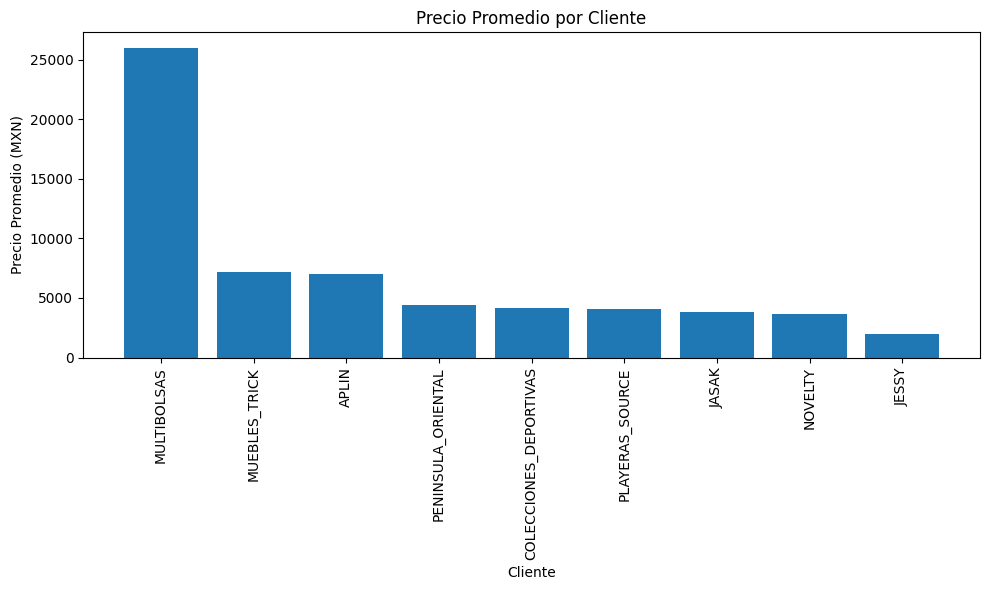

In [393]:
# Agrupar por cliente y calcular el promedio de los Precios Promedio de
# los viajes
precio_promedio_por_cliente = df.groupby('Cliente')['Precio_Viaje'].mean()
precio_promedio_por_cliente = precio_promedio_por_cliente.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(precio_promedio_por_cliente.index, precio_promedio_por_cliente)
plt.xlabel('Cliente')
plt.ylabel('Precio Promedio (MXN)')
plt.title('Precio Promedio por Cliente')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Multibolsas tiene en promedio el precio más elevado por mucha diferencia con el resto de los clientes (arriba de \$25,000)
- Jessy es el cliente con menor precio (Debajo de los \$2,500)

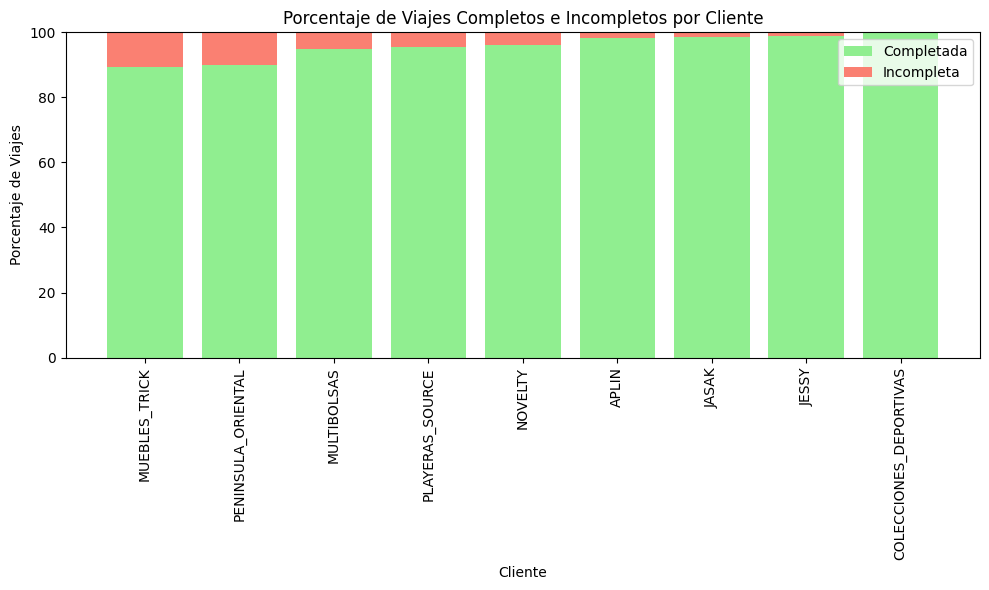

In [394]:
# Calcular el número de viajes completos e incompletos por conductor
viajes_por_cliente = df.groupby('Cliente')['Status_de_Orden'].value_counts().unstack().fillna(0)

# Calcular el porcentaje de viajes completos e incompletos por conductor
viajes_por_cliente['Total'] = viajes_por_cliente.sum(axis=1)
viajes_por_cliente['Porcentaje_Completado'] = viajes_por_cliente['Completada'] / viajes_por_cliente['Total'] * 100
viajes_por_cliente['Porcentaje_Incompleto'] = viajes_por_cliente['Incompleta'] / viajes_por_cliente['Total'] * 100
viajes_por_cliente = viajes_por_cliente.sort_values(by='Porcentaje_Incompleto', ascending=False)


# Graficar
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_cliente.index, viajes_por_cliente['Porcentaje_Completado'], label='Completada', color='lightgreen')
plt.bar(viajes_por_cliente.index, viajes_por_cliente['Porcentaje_Incompleto'], label='Incompleta', bottom=viajes_por_cliente['Porcentaje_Completado'], color='salmon')
plt.xlabel('Cliente')
plt.ylabel('Porcentaje de Viajes')
plt.title('Porcentaje de Viajes Completos e Incompletos por Cliente')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


- Muebles Trick tiene el porcentaje más bajo de entregas completadas, con un 90% de viajes completados aproximadamente. Aún así es un buen porcentaje de viajes completados.
- Colecciones deportivas es el único cliente con el 100% de sus viajes completados

### Cliente vs. Conductor

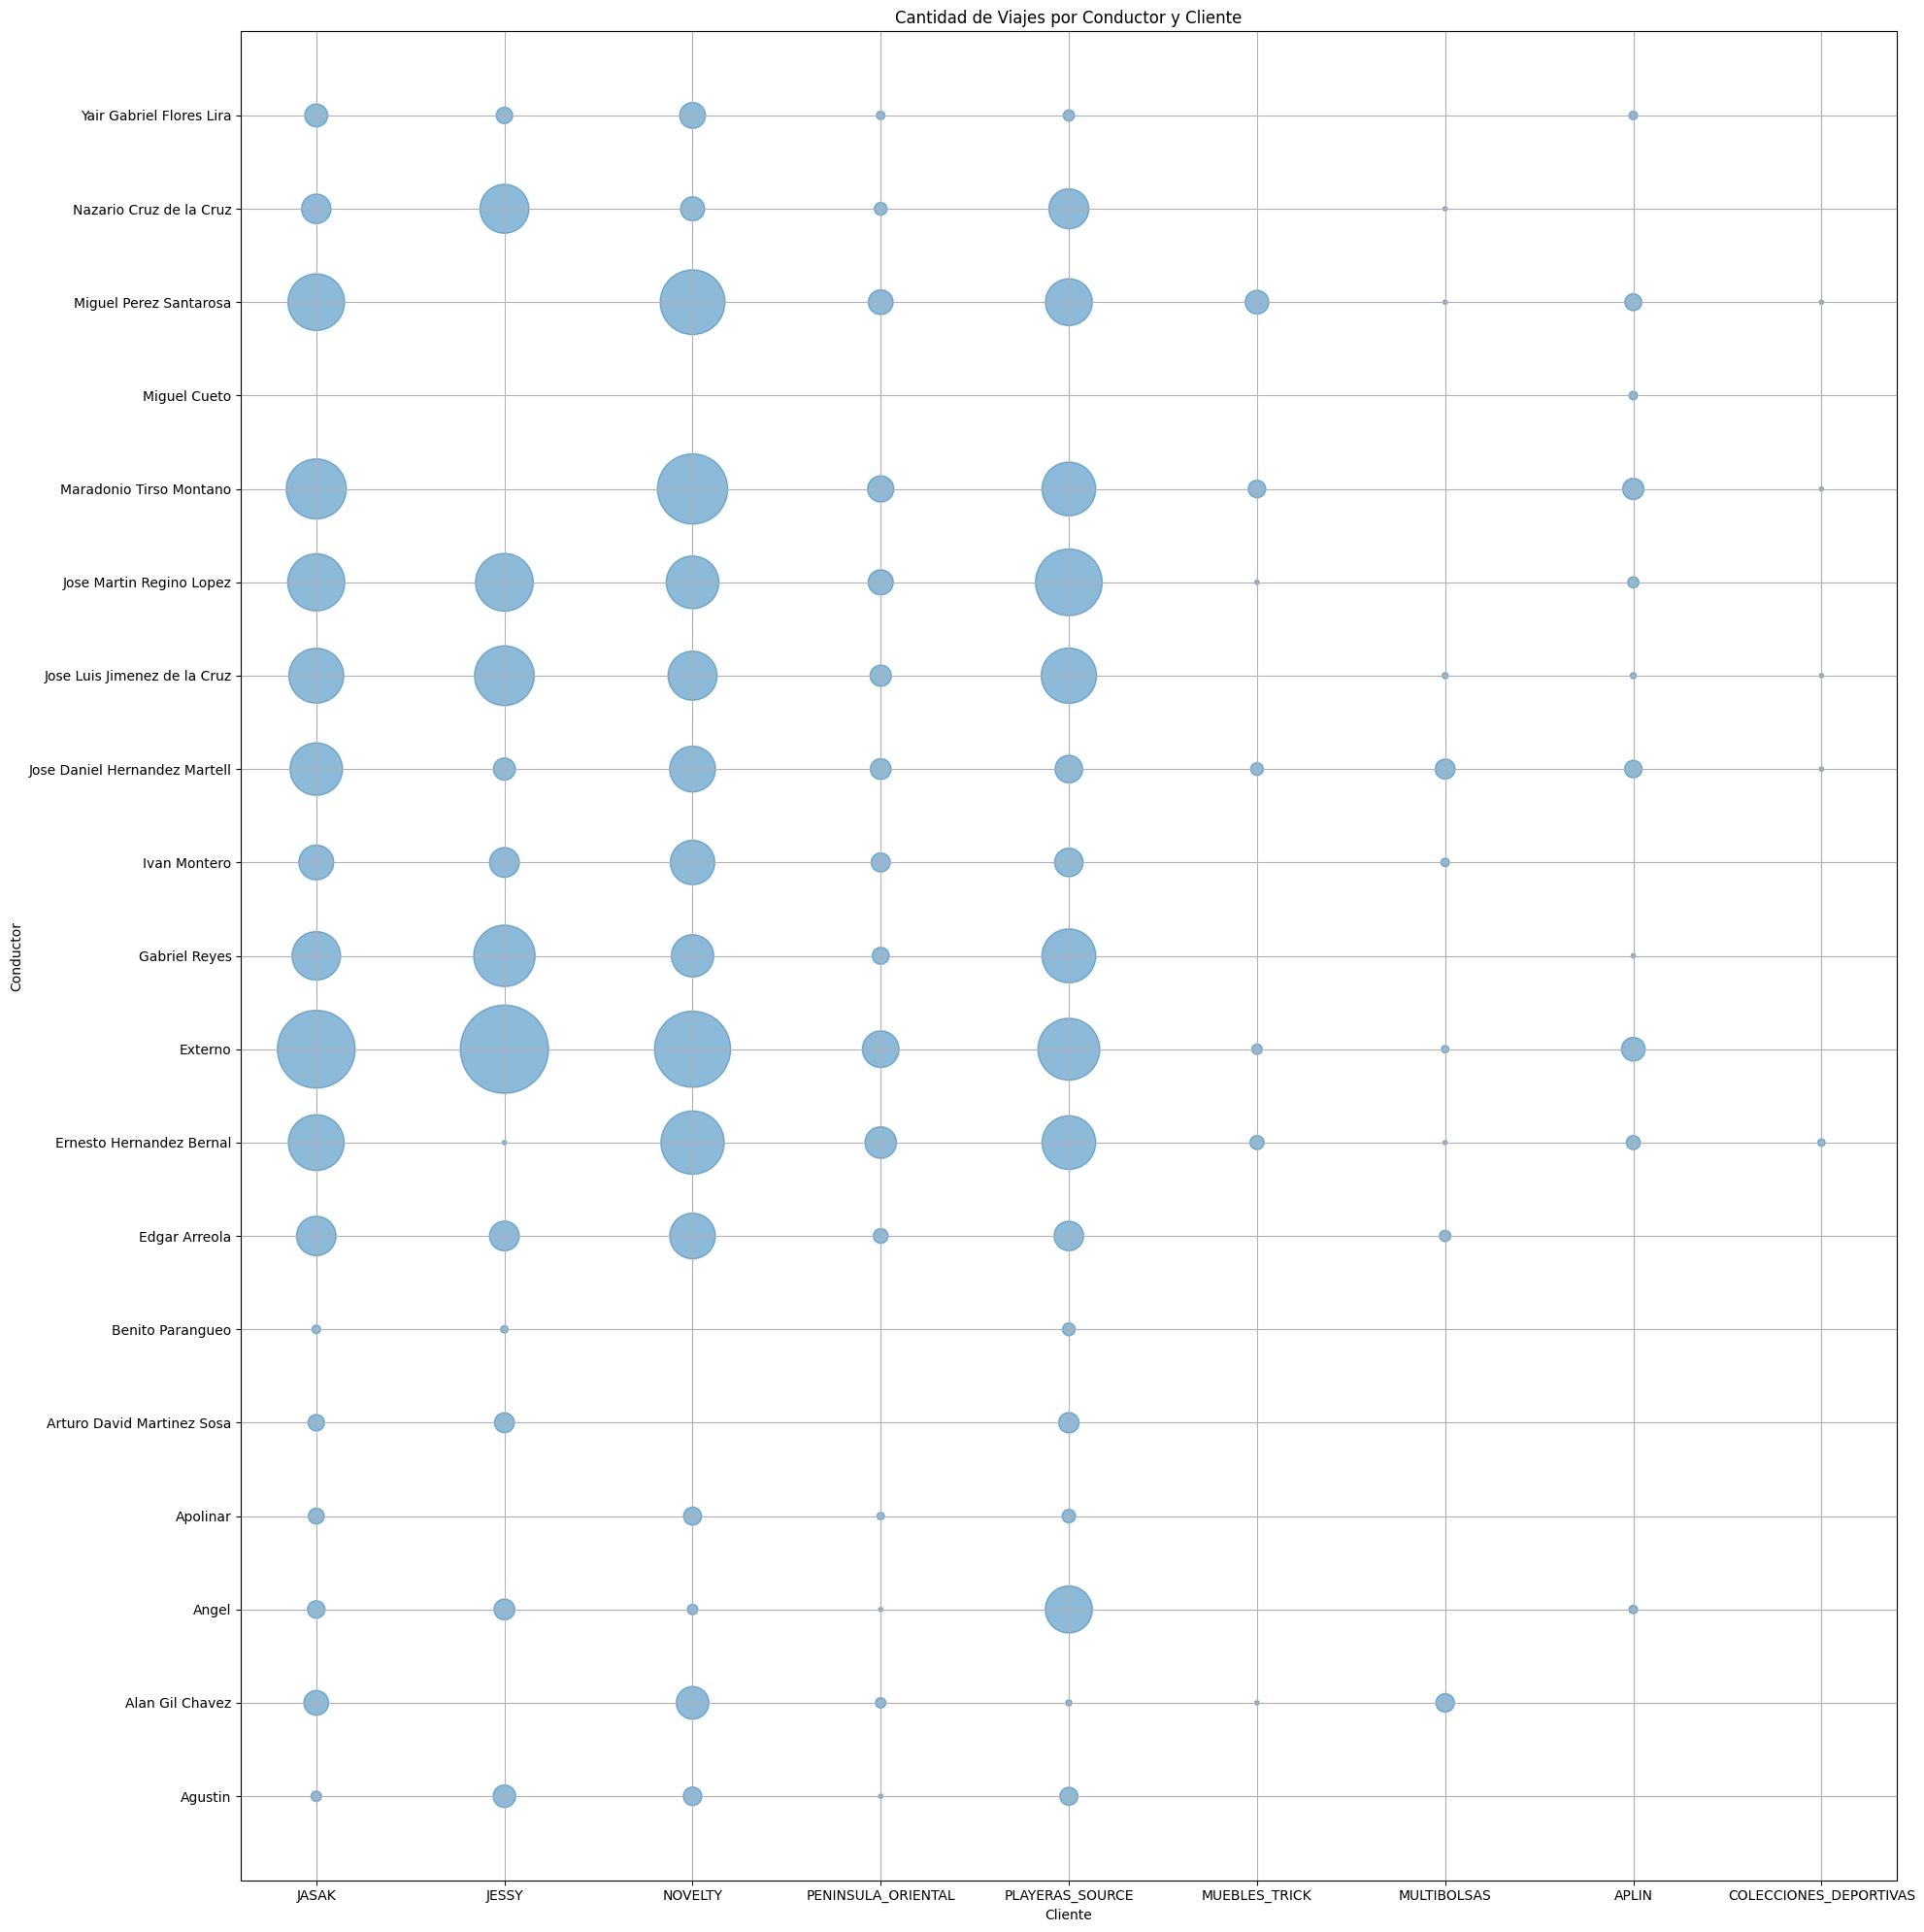

In [395]:
# Contar cuántas veces aparece cada combinación de conductor y cliente
conteo_conductor_cliente = df.groupby(['Conductor', 'Cliente']).size().reset_index(name='Count')

# Graficar
plt.figure(figsize=(20, 20))
plt.grid(True)
plt.scatter(conteo_conductor_cliente['Cliente'], conteo_conductor_cliente['Conductor'], s=conteo_conductor_cliente['Count']*10, alpha=0.5)
plt.xlabel('Cliente')
plt.ylabel('Conductor')
plt.title('Cantidad de Viajes por Conductor y Cliente')
plt.tight_layout()
plt.show()

- Podemos ver que no existe una correlación fuerte entre clientes y conductores
- La correlación más fuerte es de los conductores externos y los clientes Jessy y Novelty
- Los clientes que tienen menor concentración podría ser porque son clientes relativamente nuevos

### Vehículo Asignado vs. Cliente

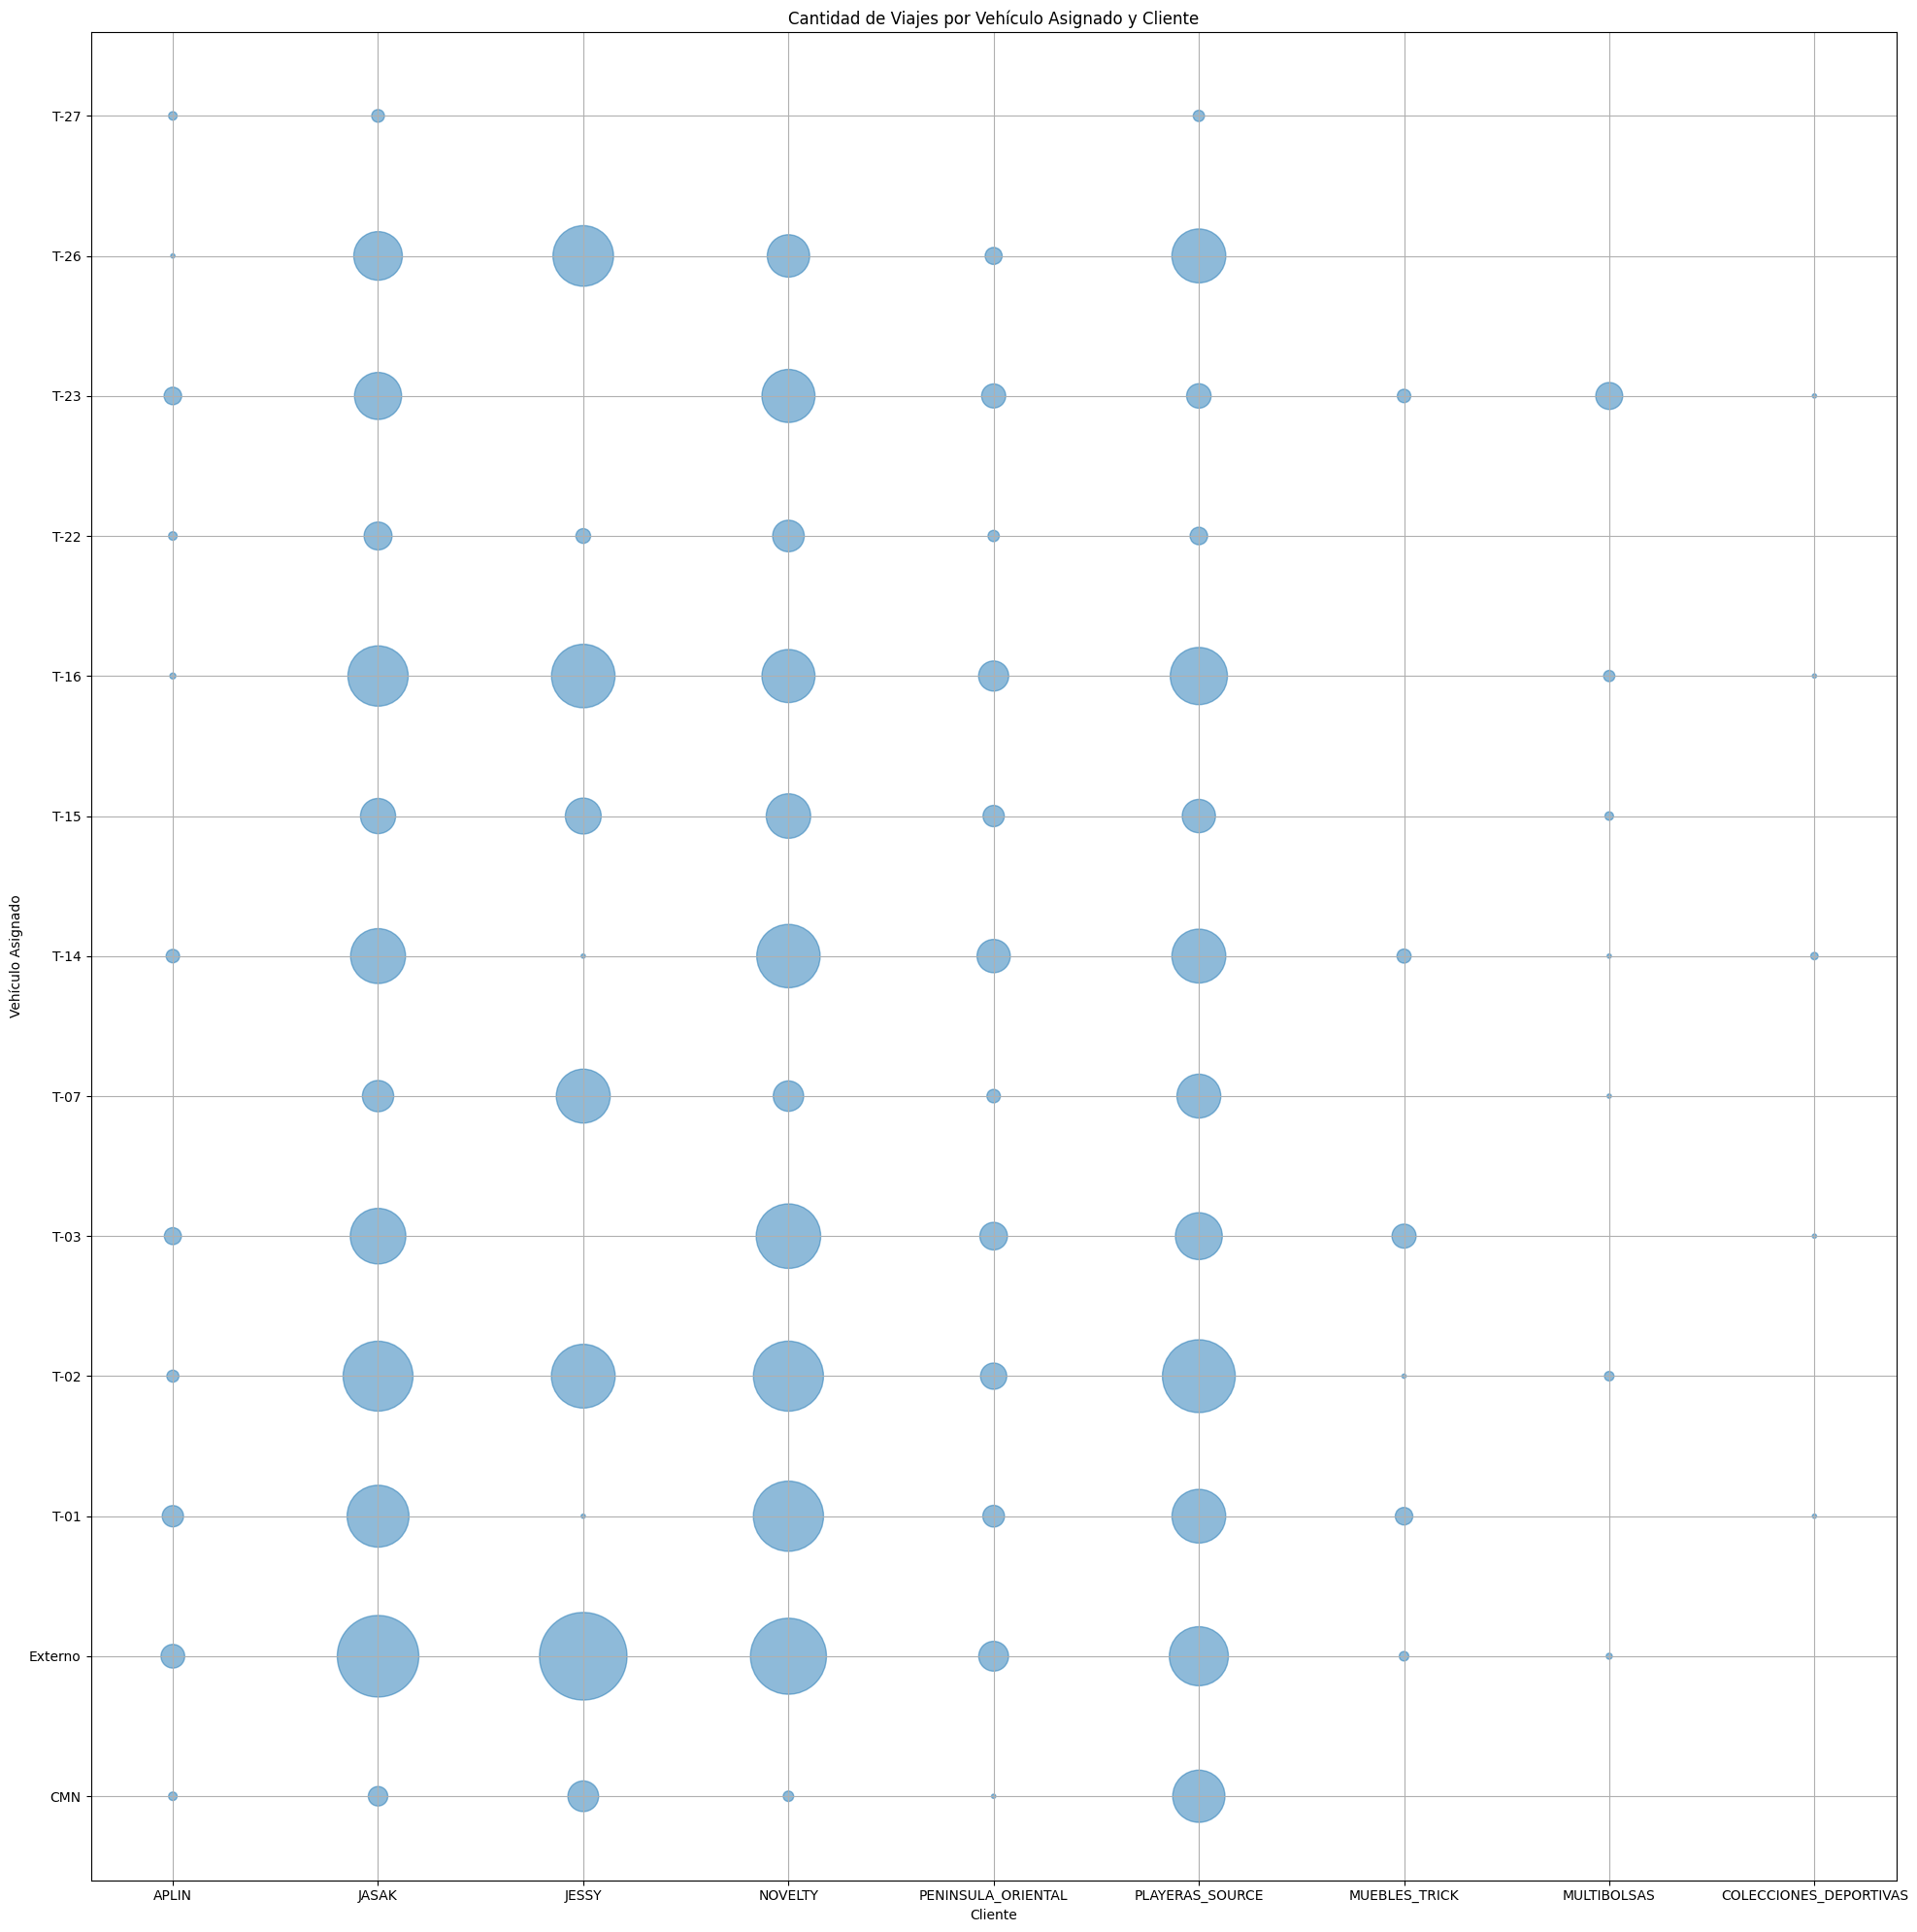

In [396]:
# Contar cuántas veces aparece cada combinación de conductor y cliente
conteo_vehiculo_cliente = df.groupby(['ID_Vehiculo_Asignado', 'Cliente']).size().reset_index(name='Count')

# Graficar
plt.figure(figsize=(20, 20))
plt.grid(True)
plt.scatter(conteo_vehiculo_cliente['Cliente'], conteo_vehiculo_cliente['ID_Vehiculo_Asignado'], s=conteo_vehiculo_cliente['Count']*10, alpha=0.5)
plt.xlabel('Cliente')
plt.ylabel('Vehículo Asignado')
plt.title('Cantidad de Viajes por Vehículo Asignado y Cliente')
plt.tight_layout()
plt.show()

- Existe una concentración de los clientes Jasak, Jessy, Novelty y Playeras Source con las unidades T-03, T-02, T-01 y Vehículos Externos

### Rendimiento Promedio por Vehículo


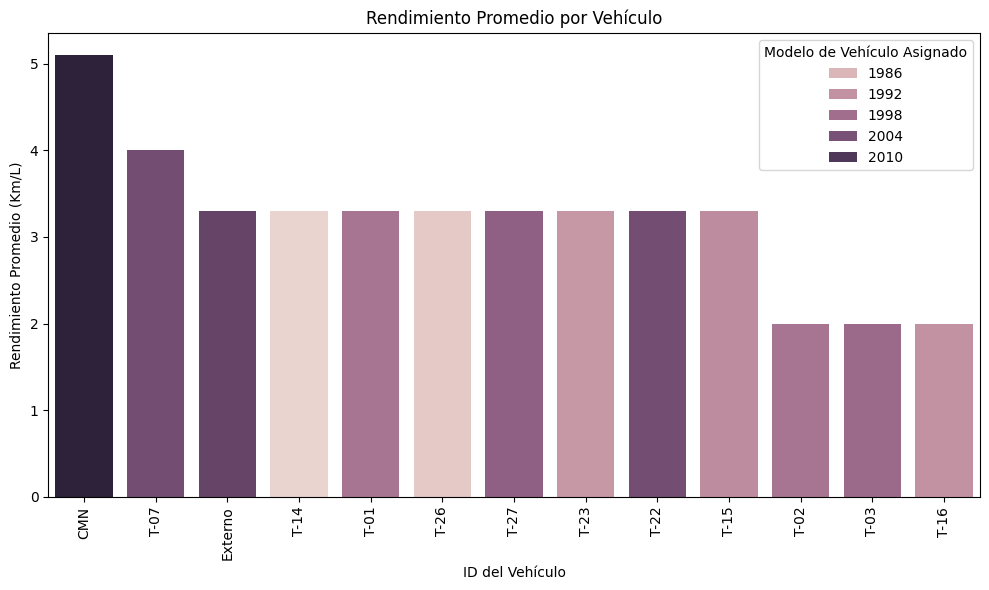

In [397]:
# Agrupar por vehículo y calcular el rendimiento promedio por vehículo
rendimiento_por_vehiculo = df.groupby('ID_Vehiculo_Asignado')['Rendimiento_Promedio_Vehiculo_Asignado'].mean()
rendimiento_por_vehiculo = rendimiento_por_vehiculo.sort_values(ascending=False)

# Fusionar los datos de rendimiento por vehículo con los datos de modelo de vehículo
df_rendimiento_modelo = pd.merge(rendimiento_por_vehiculo, df[['ID_Vehiculo_Asignado', 'Modelo_Vehiculo_Asignado']], on='ID_Vehiculo_Asignado', how='left')

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='ID_Vehiculo_Asignado', y='Rendimiento_Promedio_Vehiculo_Asignado', hue='Modelo_Vehiculo_Asignado', data=df_rendimiento_modelo)
plt.xlabel('ID del Vehículo')
plt.ylabel('Rendimiento Promedio (Km/L)')
plt.title('Rendimiento Promedio por Vehículo')
plt.xticks(rotation=90)
plt.legend(title='Modelo de Vehículo Asignado')
plt.tight_layout()
plt.show()


- La camioneta CMN es el vehículo con mayor rendimiento (5km/L), siendo el vehículo más nuevo
- El T-16 es el vehículo con menor rendimiento (2km/L), siendo uno de los vehículos más viejos de la flotilla.

### Vehículo Asignado vs. Status de Orden

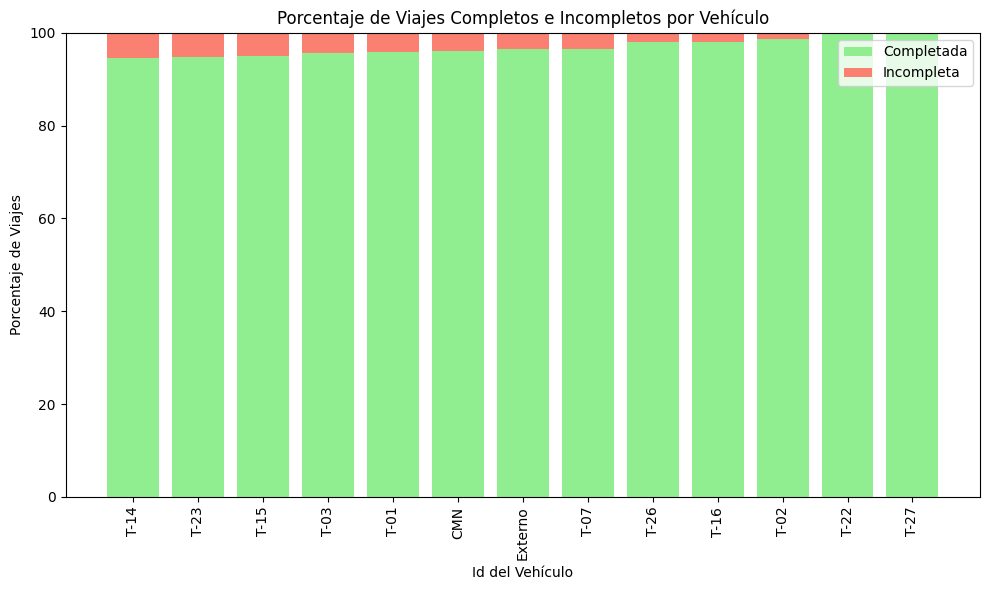

In [398]:
# Calcular el número de viajes completos e incompletos por conductor
viajes_por_vehiculo = df.groupby('ID_Vehiculo_Asignado')['Status_de_Orden'].value_counts().unstack().fillna(0)

# Calcular el porcentaje de viajes completos e incompletos por conductor
viajes_por_vehiculo['Total'] = viajes_por_vehiculo.sum(axis=1)
viajes_por_vehiculo['Porcentaje_Completado'] = viajes_por_vehiculo['Completada'] / viajes_por_vehiculo['Total'] * 100
viajes_por_vehiculo['Porcentaje_Incompleto'] = viajes_por_vehiculo['Incompleta'] / viajes_por_vehiculo['Total'] * 100
viajes_por_vehiculo = viajes_por_vehiculo.sort_values(by='Porcentaje_Incompleto', ascending=False)


# Graficar
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_vehiculo.index, viajes_por_vehiculo['Porcentaje_Completado'], label='Completada', color='lightgreen')
plt.bar(viajes_por_vehiculo.index, viajes_por_vehiculo['Porcentaje_Incompleto'], label='Incompleta', bottom=viajes_por_vehiculo['Porcentaje_Completado'], color='salmon')
plt.xlabel('Id del Vehículo')
plt.ylabel('Porcentaje de Viajes')
plt.title('Porcentaje de Viajes Completos e Incompletos por Vehículo')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

- El T-14 es el vehículo con el menor porcentaje de viajes completados. El T-14 es uno de los modelos más viejos de los vehículos de la flotilla, siendo de 1986. Podría existir una correlación entre su antigüedad y su porcentaje bajo de viajes completos.
- El T-22 y el T-27 tienen un 100% de viajes completados

### Tipo de Vehículo Solicitado vs Tipo de Vehículo Asignado

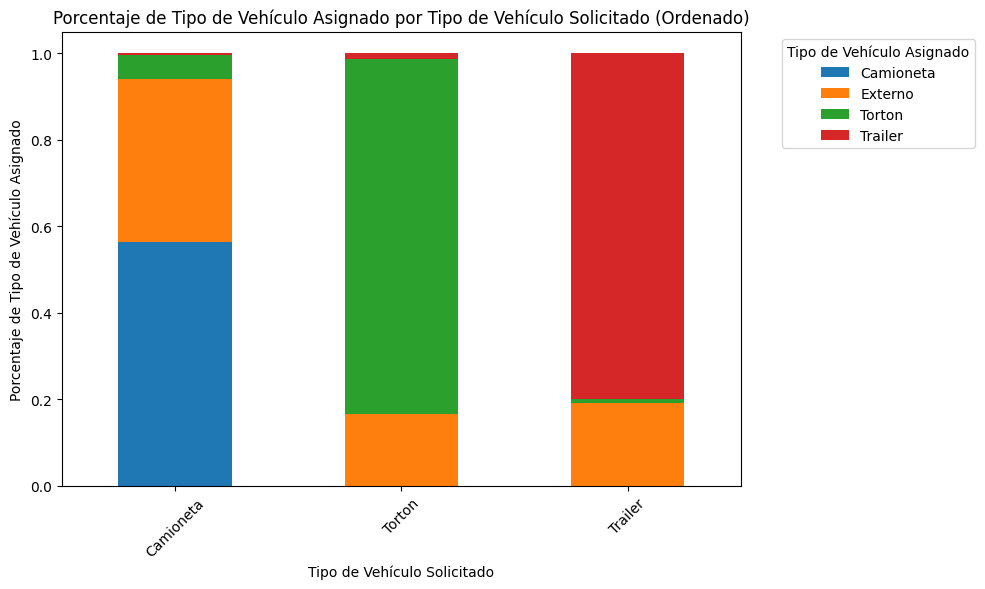

In [399]:
# Calcular el número de ocurrencias de cada combinación de tipo de vehículo solicitado y tipo de vehículo asignado
conteo_combinaciones = df.groupby(['Tipo_de_Vehiculo_Solicitado', 'Tipo_de_Vehiculo_Asignado']).size().unstack(fill_value=0)

# Calcular el porcentaje de cada tipo de vehículo asignado para cada tipo de vehículo solicitado
porcentaje_por_tipo_solicitado = conteo_combinaciones.apply(lambda row: row / row.sum(), axis=1)

# Ordenar las columnas de cada fila de mayor a menor porcentaje
porcentaje_por_tipo_solicitado = porcentaje_por_tipo_solicitado.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Graficar
porcentaje_por_tipo_solicitado.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Tipo de Vehículo Solicitado')
plt.ylabel('Porcentaje de Tipo de Vehículo Asignado')
plt.title('Porcentaje de Tipo de Vehículo Asignado por Tipo de Vehículo Solicitado (Ordenado)')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Vehículo Asignado', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- Podemos ver que el vehiculo solicitado con menor disponibilidad es la camioneta. Casi un 30% de las veces que se solicita, se manda a un externo. Sólo el 55% de las ocasiones se manda lo que se solicitó.
- Seguimos viendo un porcentaje alto de solicitudes que se mandan a vehículos externos. Esto reafirma la necesidad del negocio por crecer su flotilla o administrar diferentes sus recursos.

### Peso de la Carga vs. Precio del Viaje

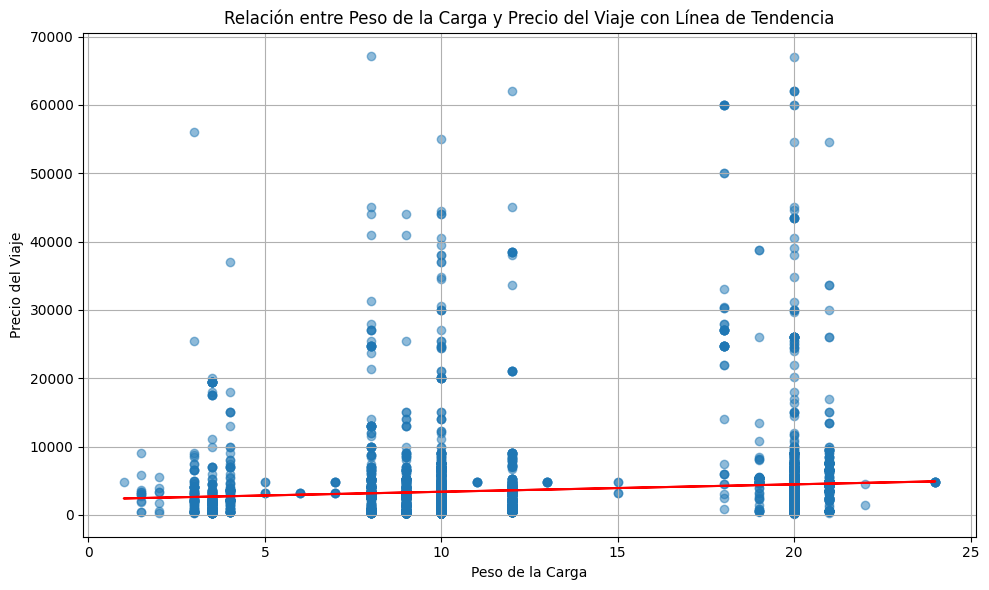

In [400]:
# Calcular la pendiente (m) e intersección (b) de la línea de tendencia
m, b = np.polyfit(df['Peso_de_la_carga'], df['Precio_Viaje'], 1)

# Graficar el diagrama de dispersión con la línea de tendencia
plt.figure(figsize=(10, 6))
plt.scatter(df['Peso_de_la_carga'], df['Precio_Viaje'], alpha=0.5)
plt.plot(df['Peso_de_la_carga'], m * df['Peso_de_la_carga'] + b, color='red')
plt.xlabel('Peso de la Carga')
plt.ylabel('Precio del Viaje')
plt.title('Relación entre Peso de la Carga y Precio del Viaje con Línea de Tendencia')
plt.grid(True)
plt.tight_layout()
plt.show()

- Casi no existe correlación entre el peso de la carga y el precio dado a los clientes. Esto no hace mucho sentido debido a que debería haber una alza dependiendo el peso del trailer, ya que esto va a afectar directamente el rendimiento del vehículo.


### Distancia del Viaje vs. Precio del Viaje

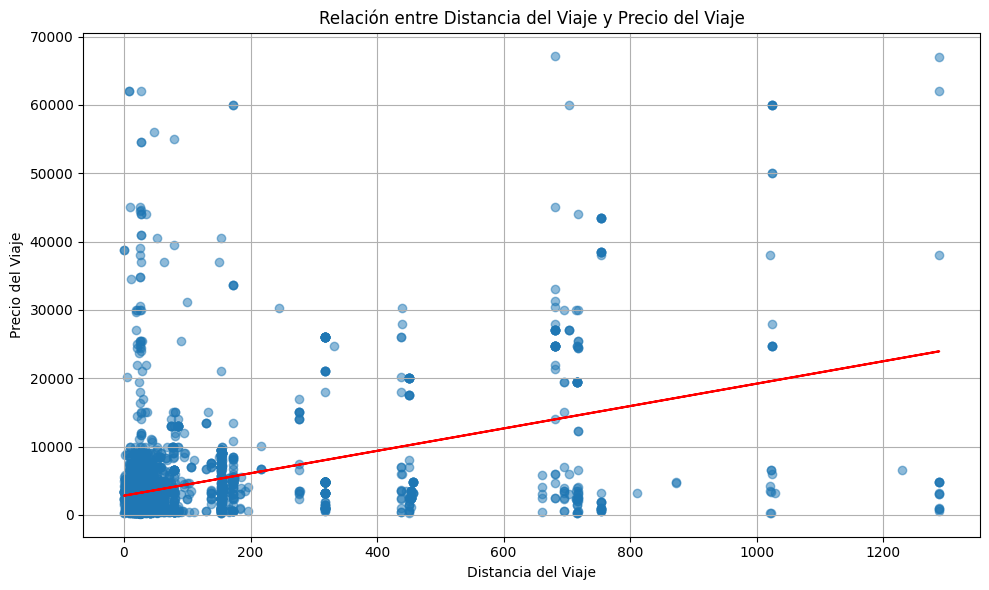

In [401]:
# Calcular la pendiente (m) e intersección (b) de la línea de tendencia
m, b = np.polyfit(df['distancia_km'], df['Precio_Viaje'], 1)

# Graficar el diagrama de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df['distancia_km'], df['Precio_Viaje'], alpha=0.5)
plt.plot(df['distancia_km'], m * df['distancia_km'] + b, color='red')
plt.xlabel('Distancia del Viaje')
plt.ylabel('Precio del Viaje')
plt.title('Relación entre Distancia del Viaje y Precio del Viaje')
plt.grid(True)
plt.tight_layout()
plt.show()

- Vemos que aquí si existe una correlación positiva entre distancia y viaje, lo cual suena correcto por el consumo de combustible


Ya terminado el Exploratory Data Analysis podemos proceder a la preparación de los datos para el modelo.

__________
# Avance 2
## Preparación de Datos
Vamos a volver a visualizar los datos que tenemos disponibles para no omitir nada

In [402]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Cliente                                 7395 non-null   object 
 1   Latitud_Recoleccion                     7395 non-null   float64
 2   Longitud_Recoleccion                    7395 non-null   float64
 3   Latitud_Entrega                         7395 non-null   float64
 4   Longitud_Entrega                        7395 non-null   float64
 5   Dia                                     7395 non-null   int64  
 6   Mes                                     7395 non-null   int64  
 7   Ano                                     7395 non-null   int64  
 8   Dia_de_la_semana                        7395 non-null   int64  
 9   Conductor                               7395 non-null   object 
 10  Experiencia_Conductor                   7395 non-null   int6

Como parte de mi preparación de datos, realizaré la división en 2 dataframes distintos, uno para predecir el vehículo (y su caja seca) y otro para predecir el conductor. Esto a pesar de ser poco intuitivo, tiene una razón de ser, la separación de datos para cada caso, preservar de manera independiente las características indispensables para cada variable; la combinación de ambas variables puede resultar en un modelo con poco entendimiento de las relaciones para cada variable.

Para la preparación de datos realizaremos distintos procesos como:
1. Construcción: Crearemos nuevas características, eliminaremos algunas otras y codificaremos las variables categóricas

2. Normalización de los datos: Escalaremos las variables para garantizar que todas tengan un impacto equitativo

3. Selección y Extracción: Se aplican métodos de filtrado y extracción alineados a los resultados.

## 1. Construcción
En esta primera parte, seleccionaremos las variables que nos son útiles para cada dataframe. Basado en información disponible para cada caso.

1. Vehículo: En el caso del vehículo reducimos de 24 features a 15.
  * Variables a Eliminar:
    - Cliente: Este no aporta ningún elemento estadístico al modelo, además de que evita que pueda escalarse el modelo en caso de añadir un nuevo cliente a la cartera.
    - Día y Año: Estos dos features son absorbidas por mes y día de la semana, ya que estas mantienen la escencia de las variables.
    - Conductor, Experiencia del Conductor, Status del Conductor: En este primer dataframe, primero buscaremos el vehículo requerido. Si dejáramos el conductor, caeríamos en una paradoja donde para escoger vehículo requerimos el conductor y para elegir conductor requerimos el vehículo.
    - Tipo de Vehículo Asignado, Capacidad_Max_Caja_Seca: Aún no sabemos que vehículo se elegirá, ergo, no sabemos el tipo del vehículo, ni el modelo, ni el rendimiento promedio.
  * Variables a Mantener:
    - Distancia y Latitud y Longitud de recolección y entrega: Es necesario saber los puntos de interés del viaje.
    - Mes y día de la semana: nos permite tomar en cuenta las temporadas con alta demanda.
    - Tipo de Servicio y Vehiculo Solicitado: Influye la decisión del cliente en la selección del vehículo.
    - Peso y Tipo de carga y packaging: Es importante conocer los requerimientos de la carga para elegir el vehículo.
    - Precio del viaje: puede darnos una idea del presupuesto del viaje
    - Status de la Orden: Lo utilizaremos más adelante para hacer un filtrado de los datos con los que entrenaremos el modelo.

2. Conductor:
  * Variables a Eliminar:
    - Cliente: Este no aporta ningún elemento estadístico al modelo, además de que evita que pueda escalarse el modelo en caso de añadir un nuevo cliente a la cartera.
    - Día y Año: Estos dos features son absorbidas por mes y día de la semana, ya que estas mantienen la escencia de las variables.
    - Experiencia del Conductor: Al no saber el conductor, es imposible saber su experiencia.
  * Variables a mantener:
    - Distancia y Latitud y Longitud de recolección y entrega: Es necesario saber los puntos de interés del viaje.
    - Mes y día de la semana: nos permite tomar en cuenta las temporadas con alta demanda.
    - Tipo de Servicio y Vehiculo Solicitado: Influye la decisión del cliente en la selección del vehículo.
    - ID Vehiculo asignado, Tipo de Vehiculo Asignado, Rendimiento Promedio, capacidad caja seca: Estos datos los obtendremos una vez que el modelo para el vehiculo estén entrenado.
    - Peso y Tipo de carga y packaging: Es importante conocer los requerimientos de la carga para elegir el vehículo.
    - Precio del viaje: puede darnos una idea del presupuesto del viaje
    - Status de Orden y Status Conductor: Estas variables las utilizaremos para filtrar los datos.
    

In [403]:
df_vehicle = df[(df["Conductor"] != "Externo") & (df["ID_Vehiculo_Asignado"] != "Externo")].copy()

# Mantenemos solo las variables deseadas en los nuevos dfs
df_vehicle = df_vehicle[["Latitud_Recoleccion",
                        "Longitud_Recoleccion",
                        "Latitud_Entrega",
                        "Longitud_Entrega",
                        "Mes",
                        "Dia_de_la_semana",
                        "Tipo_de_Servicio_Solicitado",
                        "Tipo_de_Vehiculo_Solicitado",
                        "Tipo_de_carga",
                        "Peso_de_la_carga",
                        "Packaging",
                        "Precio_Viaje",
                        "distancia_km",
                        "Status_de_Orden",
                        "ID_Vehiculo_Asignado"]]

df_driver = df[(df["Conductor"] != "Externo") & (df["ID_Vehiculo_Asignado"] != "Externo")].copy()
df_driver = df_driver[["Capacidad_Max_Caja_Seca",
                      "Conductor",
                      "Dia_de_la_semana",
                      "distancia_km",
                      "ID_Vehiculo_Asignado",
                      "Latitud_Entrega",
                      "Latitud_Recoleccion",
                      "Longitud_Entrega",
                      "Longitud_Recoleccion",
                      "Mes",
                      "Modelo_Vehiculo_Asignado",
                      "Packaging",
                      "Peso_de_la_carga",
                      "Precio_Viaje",
                      "Rendimiento_Promedio_Vehiculo_Asignado",
                      "Status_Conductor",
                      "Status_de_Orden",
                      "Tipo_de_carga",
                      "Tipo_de_Servicio_Solicitado",
                      "Tipo_de_Vehiculo_Asignado",
                      "Tipo_de_Vehiculo_Solicitado"]]

No deseamos que el modelo sea entrenado con información que no sea beneficiosa, por lo tanto necesitamos filtrar los dataframes:
1. Vehículo: Filtraremos los viajes incompletos con el fin de que no se entrene con esta información.

2. Conductor: De igual manera filtraremos los viajes incompletos y los conductores cuyo contrato ha sido terminado.

In [404]:
# Vehículo

df_vehicle = df_vehicle[df_vehicle['Status_de_Orden'] != 'Incompleta']
df_vehicle = df_vehicle.drop(columns=['Status_de_Orden'])
df_vehicle.reset_index(drop=True, inplace=True)

# Conductor
df_driver = df_driver[df_driver['Status_Conductor'] != 'Terminado']
df_driver = df_driver.drop(columns=['Status_Conductor'])
df_driver.reset_index(drop=True, inplace=True)

df_driver = df_driver[df_driver['Status_de_Orden'] != 'Incompleta']
df_driver = df_driver.drop(columns=['Status_de_Orden'])
df_driver.reset_index(drop=True, inplace=True)


Hecho esto, dividiremos los dataframes en X y Y.

In [405]:
x_driver = df_driver[["Capacidad_Max_Caja_Seca",
                      "Dia_de_la_semana",
                      "distancia_km",
                      "ID_Vehiculo_Asignado",
                      "Latitud_Entrega",
                      "Latitud_Recoleccion",
                      "Longitud_Entrega",
                      "Longitud_Recoleccion",
                      "Mes",
                      "Modelo_Vehiculo_Asignado",
                      "Packaging",
                      "Peso_de_la_carga",
                      "Precio_Viaje",
                      "Rendimiento_Promedio_Vehiculo_Asignado",
                      "Tipo_de_carga",
                      "Tipo_de_Servicio_Solicitado",
                      "Tipo_de_Vehiculo_Asignado",
                      "Tipo_de_Vehiculo_Solicitado"]]
y_driver = df_driver["Conductor"]

x_vehicle = df_vehicle[["Latitud_Recoleccion",
                        "Longitud_Recoleccion",
                        "Latitud_Entrega",
                        "Longitud_Entrega",
                        "Mes",
                        "Dia_de_la_semana",
                        "Tipo_de_Servicio_Solicitado",
                        "Tipo_de_Vehiculo_Solicitado",
                        "Tipo_de_carga",
                        "Peso_de_la_carga",
                        "Packaging",
                        "Precio_Viaje",
                        "distancia_km"]]

y_vehicle = df_vehicle["ID_Vehiculo_Asignado"]

Hecho esto, procederemos a obtener las nuevas columnas, ya que con esta información haremos el one hot encoding y más adelante el análisis PCA.

In [406]:
# Extraemos las columnas tipo objecto para las variables categoricas
cat_veh_cols = x_vehicle.select_dtypes(exclude='number').columns.tolist()
# Extraemos las columnas tipo numérico para las variables numéricos
num_veh_cols = x_vehicle.select_dtypes(include='number').columns.tolist()
print("Categorical Features for Vehicle DF:",cat_veh_cols)
print("Numerical Features for Vehicle DF:",num_veh_cols)

# Extraemos las columnas tipo objecto para las variables categoricas
cat_drv_cols = x_driver.select_dtypes(exclude='number').columns.tolist()
# Extraemos las columnas tipo numérico para las variables numéricos
num_drv_cols = x_driver.select_dtypes(include='number').columns.tolist()
print("Categorical Features for Driver DF:",cat_drv_cols)
print("Numerical Features for Driver DF:",num_drv_cols)

Categorical Features for Vehicle DF: ['Tipo_de_Servicio_Solicitado', 'Tipo_de_Vehiculo_Solicitado', 'Tipo_de_carga', 'Packaging']
Numerical Features for Vehicle DF: ['Latitud_Recoleccion', 'Longitud_Recoleccion', 'Latitud_Entrega', 'Longitud_Entrega', 'Mes', 'Dia_de_la_semana', 'Peso_de_la_carga', 'Precio_Viaje', 'distancia_km']
Categorical Features for Driver DF: ['ID_Vehiculo_Asignado', 'Packaging', 'Tipo_de_carga', 'Tipo_de_Servicio_Solicitado', 'Tipo_de_Vehiculo_Asignado', 'Tipo_de_Vehiculo_Solicitado']
Numerical Features for Driver DF: ['Capacidad_Max_Caja_Seca', 'Dia_de_la_semana', 'distancia_km', 'Latitud_Entrega', 'Latitud_Recoleccion', 'Longitud_Entrega', 'Longitud_Recoleccion', 'Mes', 'Modelo_Vehiculo_Asignado', 'Peso_de_la_carga', 'Precio_Viaje', 'Rendimiento_Promedio_Vehiculo_Asignado']


Parte de la preparación de los datos es importante convertir las variables categóricas en variables numéricas para que la información sea entendible para el modelo de machine learning. Para realizar esto, se usa la codificación. Existen diferentes técnicas, pero en este caso utilizaremos la de One-Hot Encoding. Este tipo de codificación convierte los valores de las variables categoricas en nuevos features, donde los valores serán de 1 o 0 dependiendo si corresponde este nuevo feature a su valor o no (Kristianto, 2023).

In [407]:
x_vehicle = pd.get_dummies(x_vehicle, columns=cat_veh_cols)
x_driver = pd.get_dummies(x_driver, columns=cat_drv_cols)

Podemos ver el resultado de la codificación de variables en ambos dfs.

In [408]:
x_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5746 entries, 0 to 5745
Data columns (total 26 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Latitud_Recoleccion                     5746 non-null   float64
 1   Longitud_Recoleccion                    5746 non-null   float64
 2   Latitud_Entrega                         5746 non-null   float64
 3   Longitud_Entrega                        5746 non-null   float64
 4   Mes                                     5746 non-null   int64  
 5   Dia_de_la_semana                        5746 non-null   int64  
 6   Peso_de_la_carga                        5746 non-null   float64
 7   Precio_Viaje                            5746 non-null   int64  
 8   distancia_km                            5746 non-null   float64
 9   Tipo_de_Servicio_Solicitado_Estadia     5746 non-null   bool   
 10  Tipo_de_Servicio_Solicitado_Maniobra    5746 non-null   bool

Para evitar multicolinearidad y para simplificar el modelo, removemos una de las dos columnas donde las variables originales solo contenia 2 valores. Estas son las variables a eliminar:
- Packaging a Granel: Se queda solo Packagin Entarimado

In [409]:
x_vehicle.drop(['Packaging_Granel'], axis=1, inplace=True)

In [410]:
x_driver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4760 entries, 0 to 4759
Data columns (total 44 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Capacidad_Max_Caja_Seca                 4760 non-null   float64
 1   Dia_de_la_semana                        4760 non-null   int64  
 2   distancia_km                            4760 non-null   float64
 3   Latitud_Entrega                         4760 non-null   float64
 4   Latitud_Recoleccion                     4760 non-null   float64
 5   Longitud_Entrega                        4760 non-null   float64
 6   Longitud_Recoleccion                    4760 non-null   float64
 7   Mes                                     4760 non-null   int64  
 8   Modelo_Vehiculo_Asignado                4760 non-null   int64  
 9   Peso_de_la_carga                        4760 non-null   float64
 10  Precio_Viaje                            4760 non-null   int6

In [411]:
x_driver.drop(['Packaging_Granel'], axis=1, inplace=True)

## 2. Normalización
La finalidad de escalar los datos numéricos es para evitar que exista un bias al momento de entrenar el modelo y que este piense que alguna de las variables tenga mayor peso basado en su escala (Khoong, 2023). El escalado de datos nos permite escalar los datos para que estos tengan una media de 0 y una desviación standard con valor de 1. (How to scale pandas DataFrame columns ? 2021)



In [412]:
scaler_driver = StandardScaler()
x_driver[num_drv_cols] = scaler_driver.fit_transform(x_driver[num_drv_cols])
scaler_vehicle = MinMaxScaler()
x_vehicle[num_veh_cols] = scaler_vehicle.fit_transform(x_vehicle[num_veh_cols])

Podemos ver que los datos numéricos ahora están escalados y tienen una desviación estandar de 1. Hecho esto podemos proceder al análisis de componentes principales (PCA).

In [413]:
x_driver.describe().T

count   mean   std     min    25%  \
Capacidad_Max_Caja_Seca                4760.000 -0.000 1.000  -2.620 -0.927   
Dia_de_la_semana                       4760.000  0.000 1.000  -1.397 -0.779   
distancia_km                           4760.000 -0.000 1.000  -0.457 -0.286   
Latitud_Entrega                        4760.000  0.000 1.000  -2.464 -0.402   
Latitud_Recoleccion                    4760.000 -0.000 1.000  -1.196 -0.322   
Longitud_Entrega                       4760.000  0.000 1.000  -8.639  0.051   
Longitud_Recoleccion                   4760.000  0.000 1.000 -15.525  0.025   
Mes                                    4760.000 -0.000 1.000  -1.870 -0.959   
Modelo_Vehiculo_Asignado               4760.000 -0.000 1.000  -1.641 -0.544   
Peso_de_la_carga                       4760.000 -0.000 1.000  -2.547 -0.850   
Precio_Viaje                           4760.000 -0.000 1.000  -0.740 -0.356   
Rendimiento_Promedio_Vehiculo_Asignado 4760.000  0.000 1.000  -1.063 -1.063   

                                          50%    75%    max  
Capacidad_Max_Caja_Seca                -0.927  1.064  1.064  
Dia_de_la_semana                       -0.162  1.074  2.309  
distancia_km                           -0.250 -0.186  9.920  
Latitud_Entrega                        -0.105 -0.082 12.327  
Latitud_Recoleccion                    -0.290 -0.169 21.282  
Longitud_Entrega                        0.085  0.130 13.193  
Longitud_Recoleccion                    0.038  0.213 27.723  
Mes                                     0.256  0.863  1.470  
Modelo_Vehiculo_Asignado                0.553  0.553  3.021  
Peso_de_la_carga                       -0.473  1.034  1.788  
Precio_Viaje                           -0.113  0.155 13.052  
Rendimiento_Promedio_Vehiculo_Asignado  0.757  0.757  3.277

In [414]:
x_vehicle.describe().T

count  mean   std   min   25%   50%   75%   max
Latitud_Recoleccion  5746.000 0.053 0.043 0.000 0.039 0.040 0.046 1.000
Longitud_Recoleccion 5746.000 0.359 0.026 0.000 0.360 0.360 0.364 1.000
Latitud_Entrega      5746.000 0.168 0.075 0.000 0.139 0.159 0.161 1.000
Longitud_Entrega     5746.000 0.395 0.049 0.000 0.398 0.400 0.402 1.000
Mes                  5746.000 0.555 0.298 0.000 0.273 0.636 0.818 1.000
Dia_de_la_semana     5746.000 0.380 0.270 0.000 0.167 0.333 0.667 1.000
Peso_de_la_carga     5746.000 0.558 0.236 0.000 0.391 0.478 0.826 1.000
Precio_Viaje         5746.000 0.055 0.078 0.000 0.027 0.045 0.063 1.000
distancia_km         5746.000 0.047 0.105 0.000 0.016 0.020 0.026 1.000

## 3. Selección / Extracción

Para esta sección probaremos los efectos del PCA en el dataframe con el fin de saber si el modelo se beneficiaría de aplicarlo o no.

El modelo tiene un número mediano de features numéricos, lo que a primera instancia nos dice que probablemente no vaya a hacer gran efecto el PCA, pero de cualquier manera este número de features añade complejidad al modelo. Para contrarrestar esto, utilizaremos el análisis principal de componentes o PCA por sus siglas en inglés. El objetivo principal del PCA es reducir la dimensionalidad, mantieniendo sus patrones y tendencias (Ambika, 2023). Esto se hace transformando un conjunto de variables correlacionadas en nuevo conjunto de variables no correlacionadas, llamadas componentes principales, que mantienen en mayor parte la variabilidad posible de los datos originales. Para lograr esto, se hace mediante la identificación de una serie de ejes ortogonales. Este proceso está encapsulado en la función de PCA.

Como nota, este proceso lo realizamos después del escalado para que todas las características mantengan la misma escala. Además de que sólo se puede aplicar a variables numéricas.

In [415]:
# Aquí seleccionamos en la función de PCA mantener un 95% de la varianza de los
# datos originales
pca_vehicle = PCA(n_components=0.95)

# El PCA solo se puede aplicar a variables numéricas debido a que este metodo
# esta basado en algebra lineal. Por lo que para calcular su PCA, utilizaremos
# solo las variables numéricas y posteriormente se concatenara con las variables
# categoricas
df_pca_veh = pca_vehicle.fit_transform(x_vehicle[num_veh_cols])
# Obtenemos los componentes principales
pca_componentes = pca_vehicle.components_
nombre_componentes = []
# Interpretar los componentes principales y sus coeficientes
for i, component in enumerate(pca_componentes):
    print(f"Componente Principal {i + 1}:")
    nombre_componentes.append(f"Componente Principal {i + 1}")
    for j, (feature, coef) in enumerate(zip(x_vehicle.columns, component)):
        print(f"    {feature}: {coef}")

Componente Principal 1:
    Latitud_Recoleccion: -0.0002511414379857209
    Longitud_Recoleccion: -0.0008317984345088731
    Latitud_Entrega: -0.0027550221961615213
    Longitud_Entrega: 0.0027369282700302477
    Mes: -0.981345572489449
    Dia_de_la_semana: -0.09034468400825307
    Peso_de_la_carga: -0.16956134331273426
    Precio_Viaje: -0.005588235845639909
    distancia_km: -0.0007694261534762579
Componente Principal 2:
    Latitud_Recoleccion: -0.0015026136274330537
    Longitud_Recoleccion: -0.0028357709068580705
    Latitud_Entrega: 7.386574277790864e-05
    Longitud_Entrega: 0.006617187460954106
    Mes: -0.0732872623062675
    Dia_de_la_semana: 0.991822887493004
    Peso_de_la_carga: -0.10396515154035813
    Precio_Viaje: -0.006898467700488103
    distancia_km: 0.0024296845222654497
Componente Principal 3:
    Latitud_Recoleccion: -0.02089466207589066
    Longitud_Recoleccion: -3.347090902618603e-05
    Latitud_Entrega: -0.0188223542746761
    Longitud_Entrega: -0.000787301196

In [416]:
# Convertimos df_pca en un dataframe y agregamos columnas
df_pca_veh = pd.DataFrame(df_pca_veh)
df_pca_veh.columns = nombre_componentes
# Veamos la diferencia antes y después del PCA
print("Total de columnas de variables numericas antes del PCA:   ",len(num_veh_cols))
print("Total de columnas de variables numericas después del PCA: ",len(df_pca_veh.columns))

Total de columnas de variables numericas antes del PCA:    9
Total de columnas de variables numericas después del PCA:  4


Podemos ver que la reducción no es significativa para el dataframe del vehiculo, por lo que podemos decir que no nos es de utilidad. Ahora haremos el mismo análisis para el df del conductor.

In [417]:
# Aquí seleccionamos en la función de PCA mantener un 95% de la varianza de los
# datos originales
pca_driver = PCA(n_components=0.95)

# El PCA solo se puede aplicar a variables numéricas debido a que este metodo
# esta basado en algebra lineal. Por lo que para calcular su PCA, utilizaremos
# solo las variables numéricas y posteriormente se concatenara con las variables
# categoricas
df_pca_drv = pca_driver.fit_transform(x_driver[num_drv_cols])
# Obtenemos los componentes principales
pca_componentes = pca_driver.components_
nombre_componentes = []
# Interpretar los componentes principales y sus coeficientes
for i, component in enumerate(pca_componentes):
    print(f"Componente Principal {i + 1}:")
    nombre_componentes.append(f"Componente Principal {i + 1}")
    for j, (feature, coef) in enumerate(zip(x_driver.columns, component)):
        print(f"    {feature}: {coef}")

Componente Principal 1:
    Capacidad_Max_Caja_Seca: 0.47985027033131095
    Dia_de_la_semana: -0.022391700929007007
    distancia_km: 0.407424437729084
    Latitud_Entrega: 0.39909117169692
    Latitud_Recoleccion: 0.16560615441955795
    Longitud_Entrega: -0.1559866717653935
    Longitud_Recoleccion: -0.07444889685711943
    Mes: 0.08508702082960837
    Modelo_Vehiculo_Asignado: -0.034252832208603964
    Peso_de_la_carga: 0.4661110015775302
    Precio_Viaje: 0.3270605649101417
    Rendimiento_Promedio_Vehiculo_Asignado: 0.23244973451254702
Componente Principal 2:
    Capacidad_Max_Caja_Seca: -0.44590008040992046
    Dia_de_la_semana: -0.011406316578712212
    distancia_km: 0.44075120192186895
    Latitud_Entrega: 0.493300577612712
    Latitud_Recoleccion: -0.030740390371771096
    Longitud_Entrega: -0.19733238273526763
    Longitud_Recoleccion: 0.012267735044329982
    Mes: -0.14290168204952686
    Modelo_Vehiculo_Asignado: 0.08840531188321837
    Peso_de_la_carga: -0.451369405038645

In [418]:
# Convertimos df_pca en un dataframe y agregamos columnas
df_pca_drv = pd.DataFrame(df_pca_drv)
df_pca_drv.columns = nombre_componentes
# Veamos la diferencia antes y después del PCA
print("Total de columnas de variables numericas antes del PCA:   ",len(num_drv_cols))
print("Total de columnas de variables numericas después del PCA: ",len(df_pca_drv.columns))

Total de columnas de variables numericas antes del PCA:    12
Total de columnas de variables numericas después del PCA:  10


De la misma manera, la reducción no es significativa. Por lo tanto no se utilizará esto en el preprocesamiento.

Podemos proceder a la división del df en train y test.

Ya con estos cambios realizados podemos proceder a dividir los datos en entrenamiento y pruebas. La razón por lo que lo dividimos es para que podamos evaluar el rendimiento del modelo de manera imparcial. Con esto me refiero a que el modelo va a ser ajustado con el conjunto de entrenamiento y se va a evaluar de manera imparcial su rendimiento con datos nunca antes vistos para ver cómo se comportaría en el mundo real. Si no se hiciera esto, no podríamos ver que tan bueno o malo es el modelo para generalizar sus resultados con datos del mundo real.

Se realizó la división de cada data frame, poniendo el 20% de los datos para prueba.

In [419]:
x_driver_train, x_driver_test, y_driver_train, y_driver_test = train_test_split(x_driver, y_driver, test_size=0.2, random_state=42,stratify=y_driver)

In [420]:
x_vehicle_train, x_vehicle_test, y_vehicle_train, y_vehicle_test = train_test_split(x_vehicle, y_vehicle, test_size=0.2, random_state=42, stratify=y_vehicle)

Finalmente, procedemos al balanceo de datos. La razón de hacer esto es porque, como pudimos notar en el EDA, existía un desbalance de datos la variable de salida. En otras palabras, estaban subrepresentadas algunas clases en comparación con las clases mayoritarias. Si lo dejamos así, puede que haya un mayor peso en el aprendizaje del valor de una variable, que de otra, dándonos bajo rendimiento para las clases minoritarias (Chawla et al., 2002).

En este caso realizaremos una técnica de sobre muestreo llamada Random Oversampler para balancear datasets desequilibrados. Su funcionamiento consiste en crear nuevas instancias sintéticas de las clases subrepresentadas de forma aleatoria mediante tecnicas de interpolación. (López et al., 2013).

Para demostrar su funcionamiento, primero mostraremos la distribución de los previamente:

#### Conductor

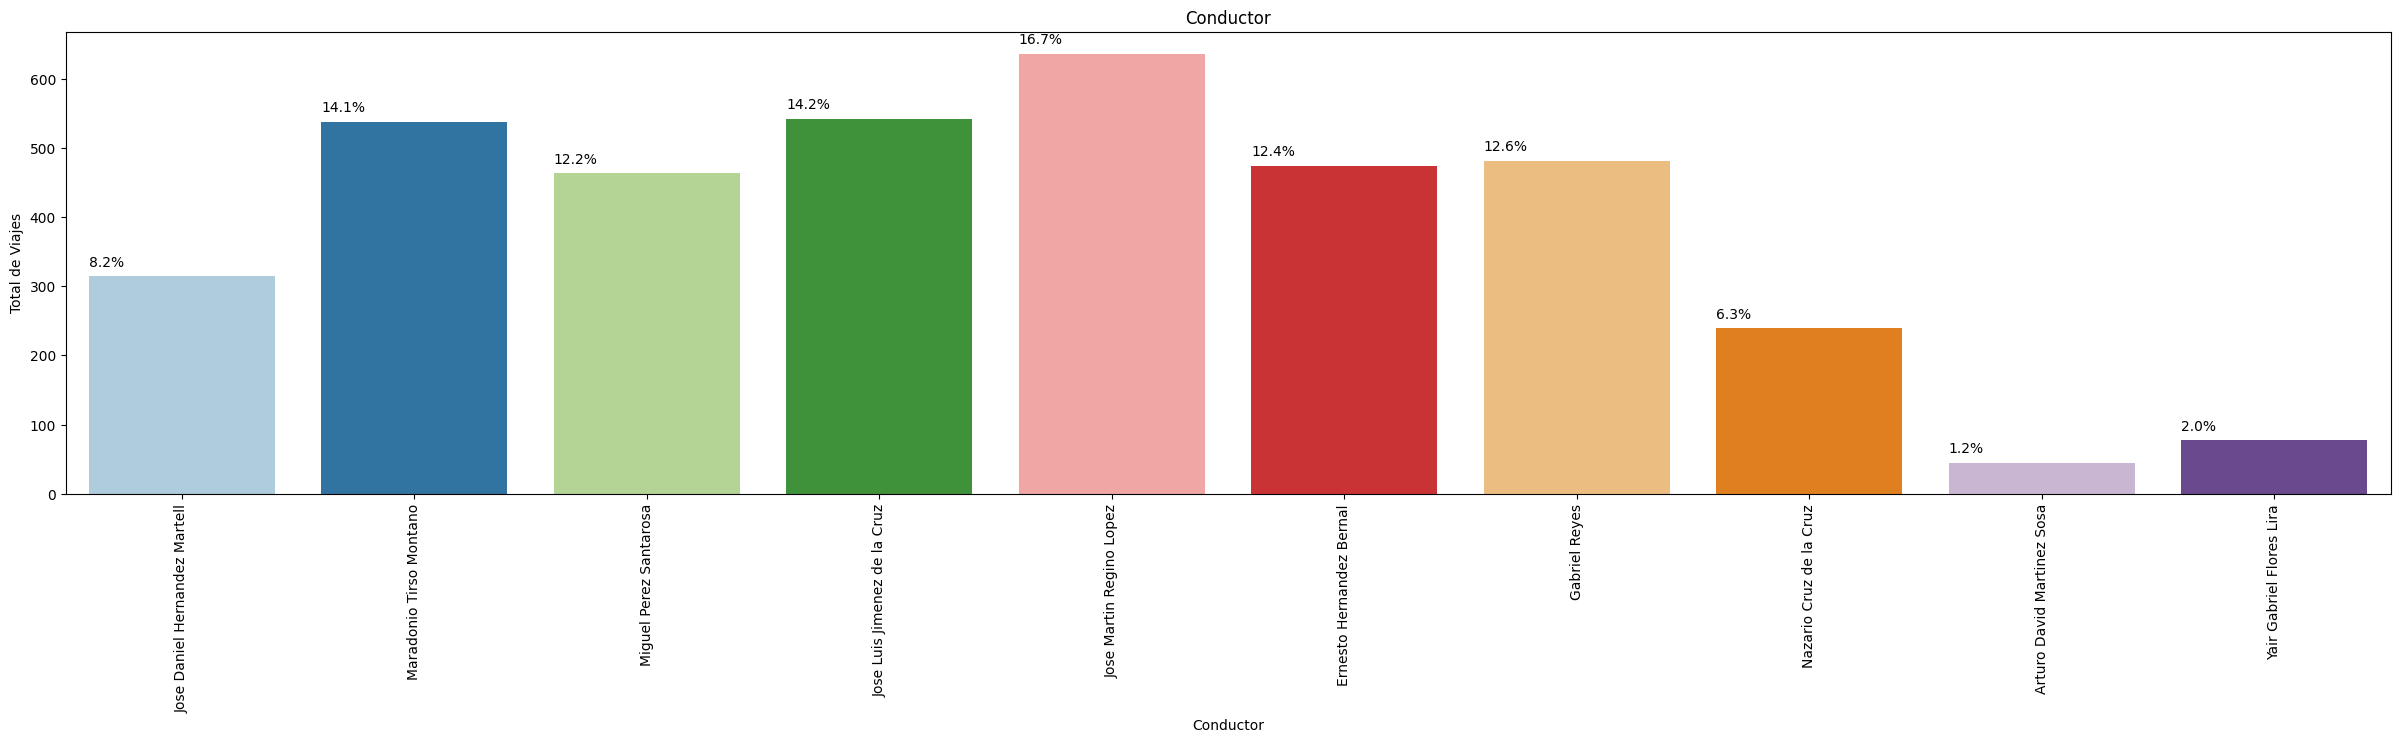

In [421]:
# Visualizamos la distribución de las variables antes del balance
perc_on_bar(pd.DataFrame(y_driver_train, columns=['Conductor']), 'Conductor', size =(30,6))

In [422]:
ros_driver = RandomOverSampler(random_state=42)
x_train_drv_res, y_train_drv_res = ros_driver.fit_resample(x_driver_train, y_driver_train)

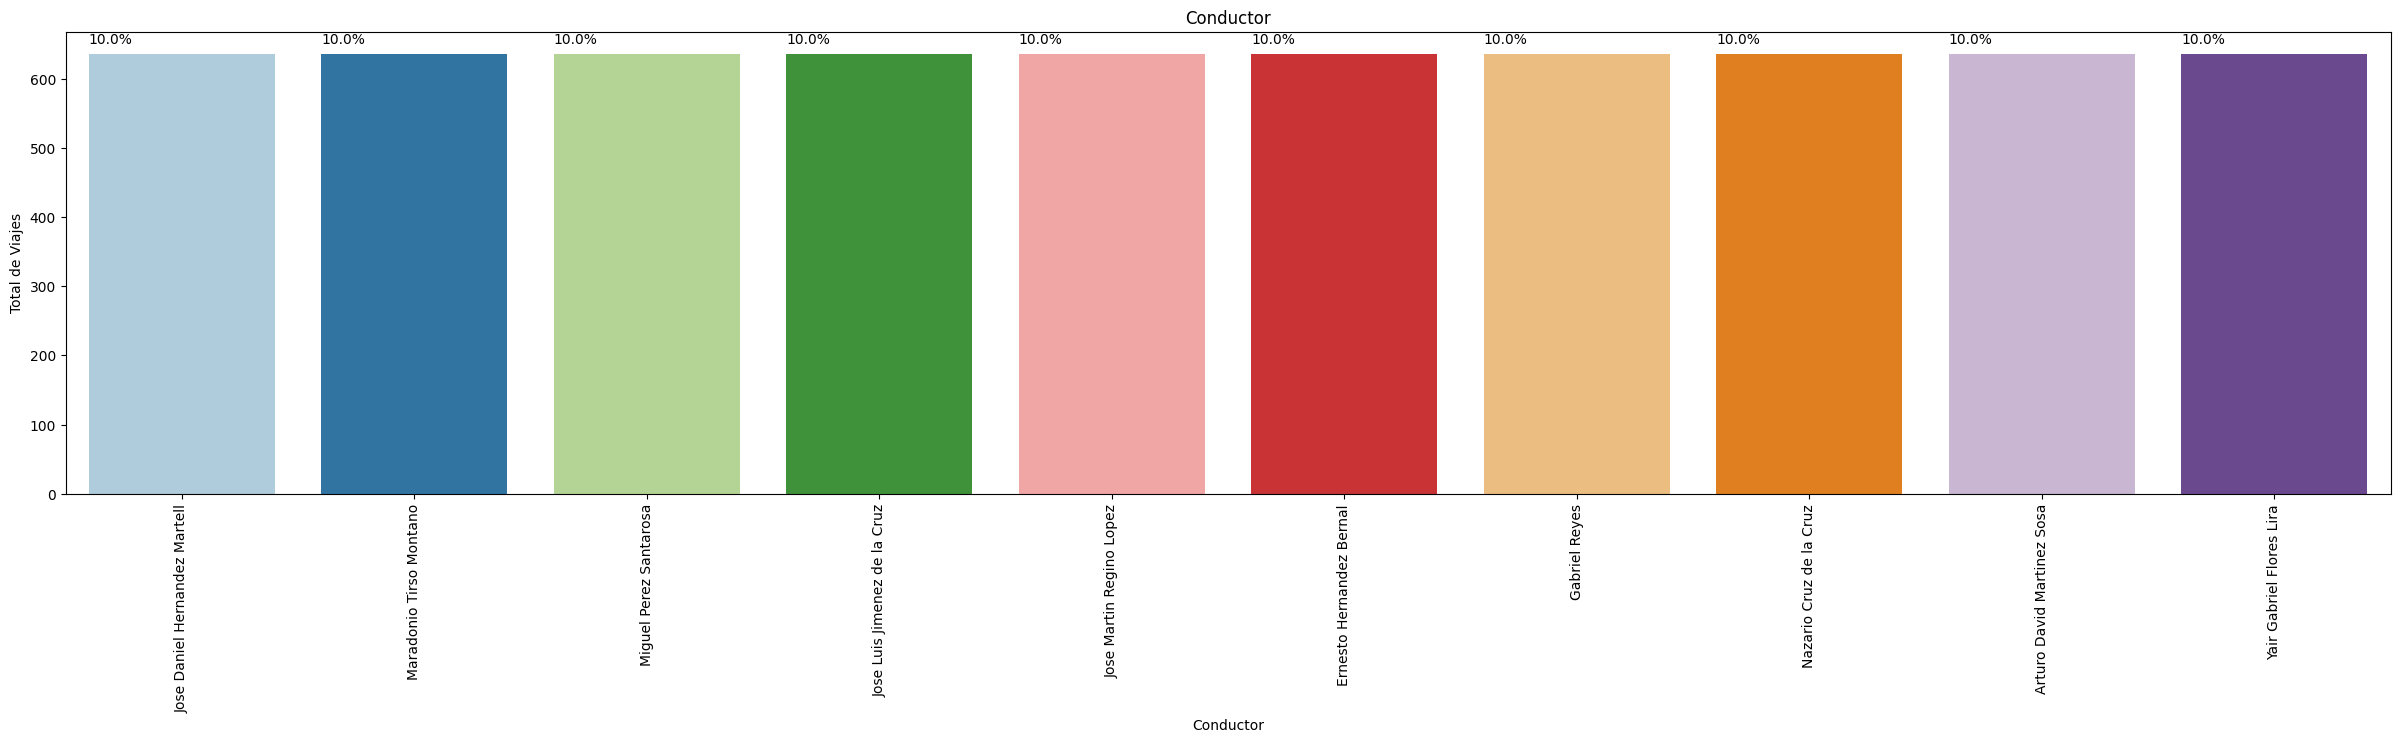

In [423]:
# Visualizamos la distribución de las variables después del balance
perc_on_bar(pd.DataFrame(y_train_drv_res, columns=['Conductor']), 'Conductor',size =(30,6))

#### Vehículo

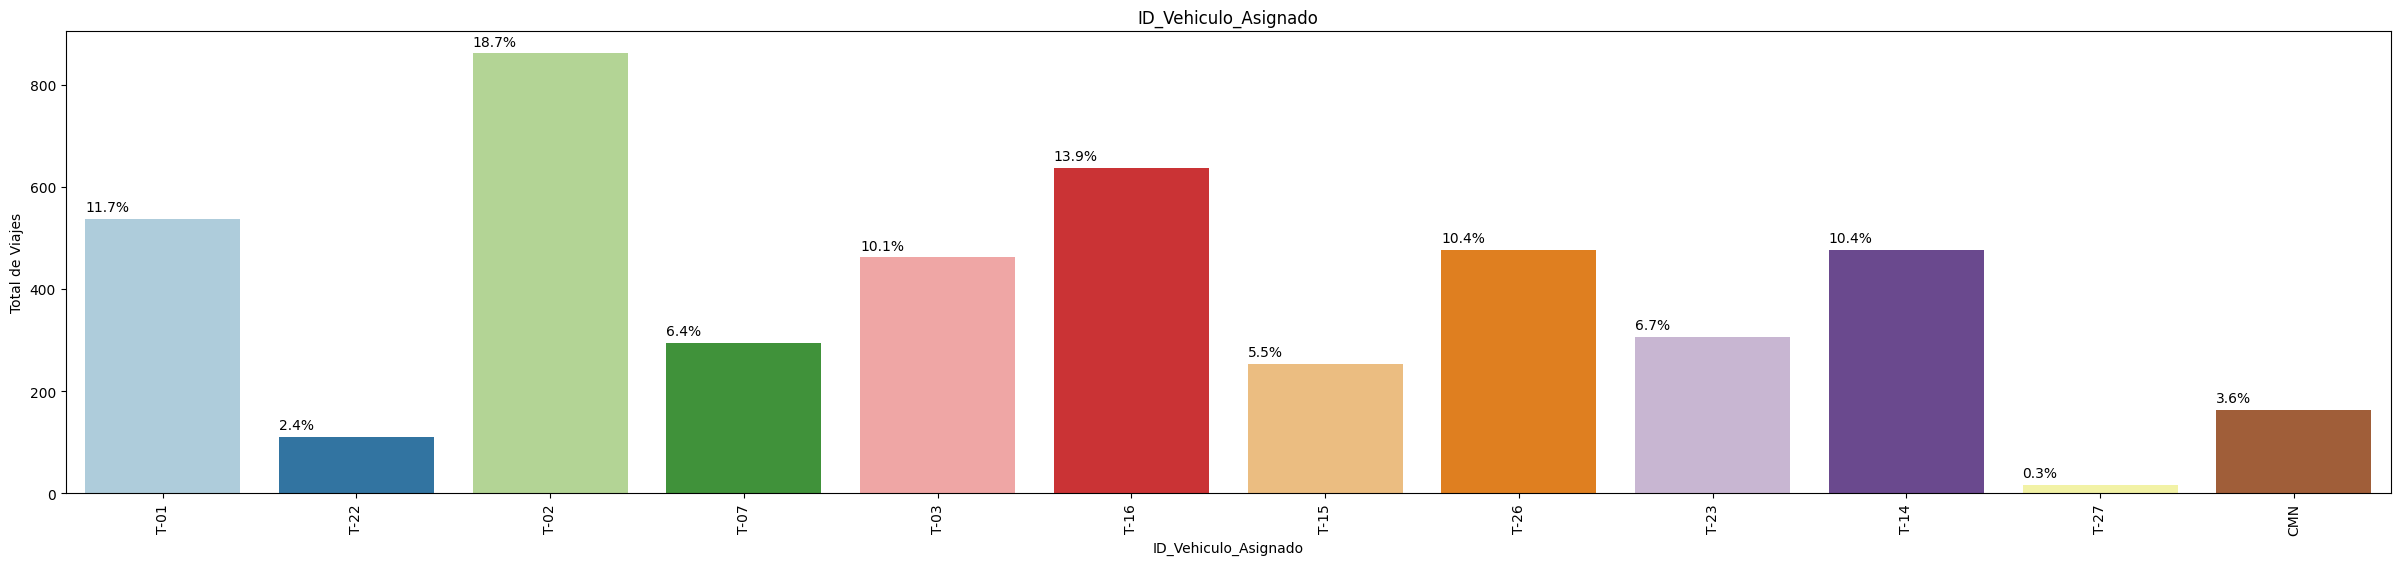

In [424]:
# Visualizamos la distribución de las variables antes del balance
perc_on_bar(pd.DataFrame(y_vehicle_train, columns=['ID_Vehiculo_Asignado']), 'ID_Vehiculo_Asignado', size =(30,6))

In [425]:
ros_vehicle = RandomOverSampler(random_state=42)
x_train_veh_res, y_train_veh_res = ros_vehicle.fit_resample(x_vehicle_train, y_vehicle_train)

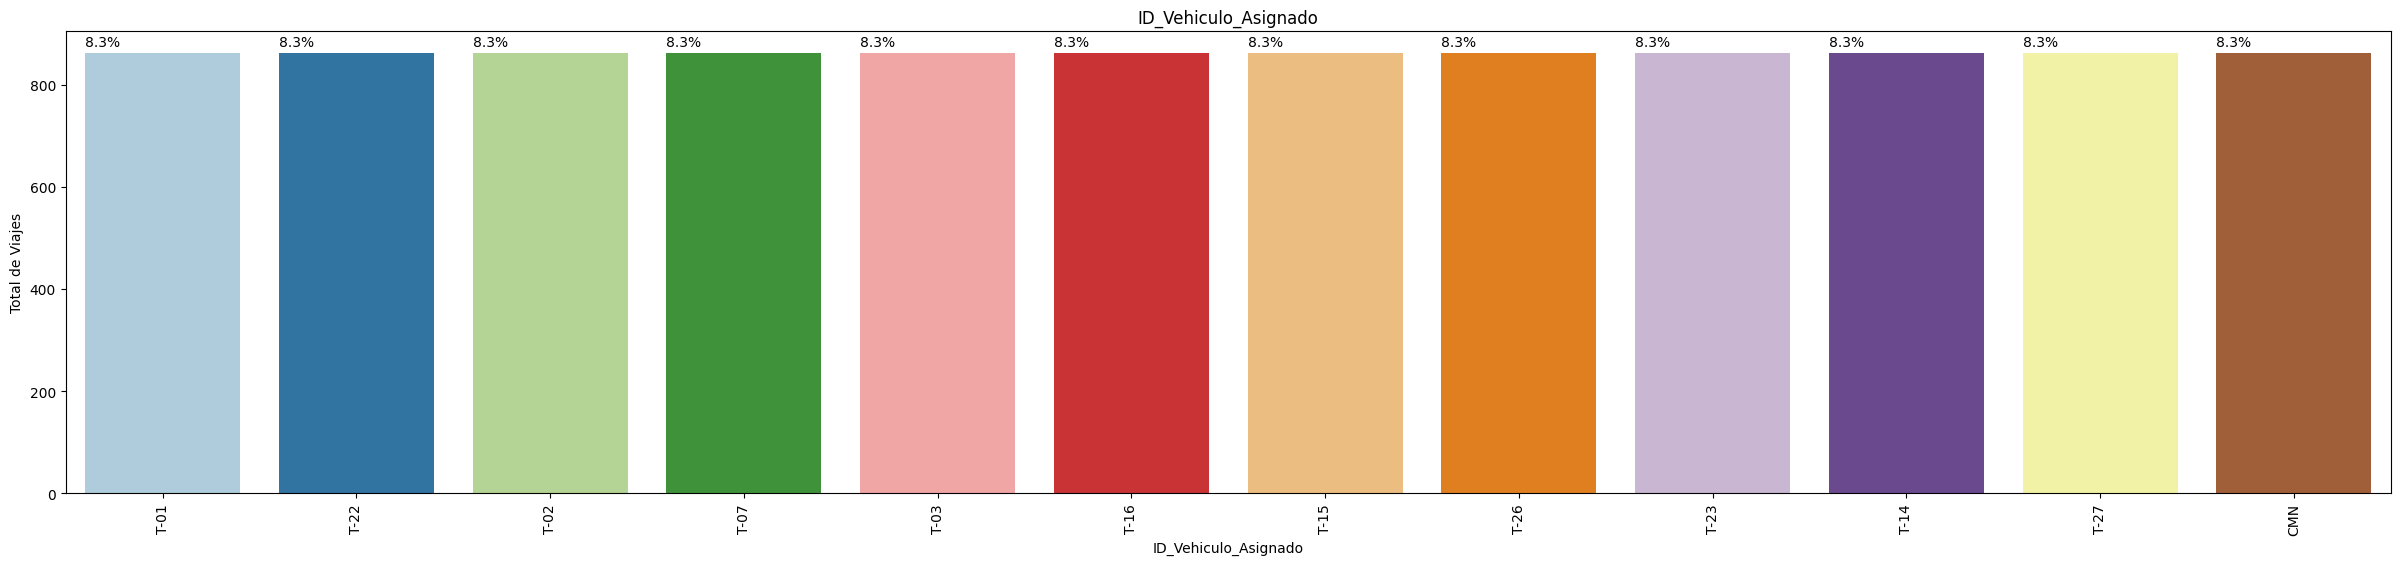

In [426]:
# Visualizamos la distribución de las variables después del balance
perc_on_bar(pd.DataFrame(y_train_veh_res, columns=['ID_Vehiculo_Asignado']), 'ID_Vehiculo_Asignado',size =(30,6))

Concluyendo esta etapa, podemos decir que completamos el preprocesamiento de datos necesario para prepararlos adecuadamente antes de entrenar el modelo, siguiendo la metodología CRISP-ML. En resumen se realizaron los siguientes pasos:

1. **Transformación One-Hot Encoding**: Se aplico la técnica de codificación one-hot a las variables categóricas, conviritendolas a variables binarias para facilitar su procesamiento por parte del modelo.

2. **Escalado de Características**: Se utilizó tandard Scaler para normalizar las variables numéricas asegurando que mantengan una media de 0 y una desviación estandar de 1. Esto es crucial para evitar que los features numércios dominen el modelo durante el entrenamiento.

3. **Balanceo de Datos:** Se implementó Random Over Sampler para abordar el desequilibrio de clases en la variable de salida, con el objetivo de mejorar la capacidad predictiva del modelo y garantizar que aprenda de manera equilibrada de cada valor de la variable objetivo.

El PCA se intentó usar para reducir la dimensionalidad del dataframe para así mejorar el rendimiento del modelo y prevenir el sobreajuste. Sin embargo, tras aplicarlo no se vió gran diferencia con respecto al data frame original, por lo que se decidió no incluir.

Estos pasos son fundamentales para asegurar la compatibilidad de los datos con los algoritmos de machine learning, mejorar el rendimiento del modelo y mitigar el riesgo de sobreajuste, contribuyendo así al éxito del proyecto de modelado.

_____
# Avance 3
## Baseline

Empezaremos con la generación de nuestro modelo base. La idea es generar un modelo híbrido, donde se unan los resultados de 2 modelos, uno para el conductor y otro para el vehículo. Esto a pesar de ser poco intuitivo, tiene una razón de ser, la separación le permite a cada modelo aprender de manera independiente las características para cada vehículo y para cada conductor; la combinación de ambas variables, obscurece las relaciones de los datos, ocultando así posibles findings que sólo aparecerían de manera independiente.

Para cada una de las variables, se planea probar de manera inicial los 2 tipos de sistemas de recomendación; de filtrado colaborativo y basado en contenido. La prueba de ambos modelos nos servirá para comparar cual de los dos tipos de modelos nos puede ayudar obtener una recomendación más robusta.

En los siguientes bloques explicaremos por qué podríamos utilizar cada uno de los sistemas de recomendación, junto con su contexto.

En fin, antes de empezar con la implementación de los modelos, quisiera entrar en detalle con respecto a las métricas disponibles para evaluar los modelos y explicar la métrica más relevante para nuestro caso.

De acuerdo a literatura, algunas de las métricas más usadas para evaluar modelos multiclase, son los siguientes:

- Precision: Esta métrica mide la proporcion de predicciones correctas. Este tipo de métrica es útil cuando los errores de clasificación tienen las mismas consecuencias.
- Recall: Esta métrica mide la proporción de casos positivos correctamente identificads. Este tipo de métrica es útil cuando los falsos negativos tienen un costo mayor que los falsos positivos.
- F1-Score: Es una métrica que proporciona un balance entre precision y recall.

Dicho esto, con base en las necesidades del problema, la métrica que más nos va a servir es F1-Score. Esto debido a que la precision es importante para asegurarnos que el vehiculo y conductor sea el adecuado. Si escogemos mal alguno de los dos, puede significar incompatibilidad, lo cual aumenta el riesgo del viaje, reduce la posibilidad de que el viaje sea exitoso e incluso puede aumentar los costos. Gracias a que el F1-Score nos da una vision más global del rendimiento del modelo, lo hace el más adecuado.

Para poder medir el rendimiento del modelo desde todos los ángulos, generaremos una función que nos permita imprimir y guardar las métricas para que más adelante las podamos comparar.



In [427]:
# Esta función evaluara el modelo
def get_metrics_score(model, train, test, train_y, test_y, flag=True):
    '''
    model : classifier to predict values of X
    train : training feature data
    test : testing feature data
    train_y : training labels
    test_y : testing labels
    flag : boolean to control print statements (default is True)
    '''
    # Defining an empty list to store train and test results
    score_list = []

    pred_train = model.predict(train)
    pred_test = model.predict(test)

    train_acc = metrics.accuracy_score(train_y, pred_train)
    test_acc = metrics.accuracy_score(test_y, pred_test)

    train_recall = metrics.recall_score(train_y, pred_train, average='weighted')
    test_recall = metrics.recall_score(test_y, pred_test, average='weighted')

    train_precision = metrics.precision_score(train_y, pred_train, average='weighted')
    test_precision = metrics.precision_score(test_y, pred_test, average='weighted')

    train_f1 = metrics.f1_score(train_y, pred_train, average='weighted')
    test_f1 = metrics.f1_score(test_y, pred_test, average='weighted')

    score_list.extend((train_acc, test_acc, train_recall, test_recall, train_precision, test_precision, train_f1, test_f1))

    # If the flag is set to True, then only the following print statements will be displayed.
    if flag:
        print("Accuracy on training set:", train_acc)
        print("Accuracy on test set:", test_acc)
        print("Recall on training set:", train_recall)
        print("Recall on test set:", test_recall)
        print("Precision on training set:", train_precision)
        print("Precision on test set:", test_precision)
        print("F1-Score on training set:", train_f1)
        print("F1-Score on test set:", test_f1)

    return score_list

Finalmente, otra función que necesitamos añadir al repertorio, es para realizar el análisis de features. Este análisis, al igual que la matriz de correlación, nos permite ver la correlación que tienen los features con la variable objetivo. De igual manera, nos permite ver que variables son irrelevantes para el modelo. Esto nos puede ayudar a refinar aún más el modelo para obtener mejores resultados.

In [428]:
def feature_importance(model, model_name, x, y, scorer, n_repeats = 10, n_jobs =-1, random_state=78):
  # Generamos la permutación de importancia con nuestro modelo y datos
  importance_ = permutation_importance(model, x, y, scoring=scorer, n_repeats=n_repeats, n_jobs=n_jobs, random_state=random_state)
  # Guardamos estos datos en un dataframe para mostrarlo
  df_importance = pd.DataFrame({"importances_mean":importance_["importances_mean"], "importances_std":importance_["importances_std"]}, index=x.columns)
  df_importance = df_importance.sort_values("importances_mean", ascending=False)
  # Mostramos el dataframe
  display(df_importance.sort_values("importances_mean", ascending=False))
  # Mostramos la importancia de manera gráfica
  plt.figure(figsize=(20, 6))
  df_importance['importances_mean'].plot(kind='bar')
  plt.xlabel('Feature')
  plt.ylabel('Importance')
  plt.title(f'Feature Importance - {model_name}')
  plt.grid(True)
  plt.show()

Generadas estas funciones podemos empezar con la generación de los modelos.

### Filtrado Colaborativo

Si hablamos de collaborative filtering (CF) o filtrado colaborativo, es un tipo de modelo que nos permite generar recomendaciones con base en las preferencias de muchos otros usuarios con gustos similares (Figueroa, 2020).

En nuestro caso más particular, CF nos permite recomendar al usuario una combinación de conductor/vehículo con base en las preferencias que se han tenido en viajes similares.

Existen distintos tipos de filtrado:
- Usuario-Usuario: Verifica la similitud entre dos usuarios basándose en el número de artículos que ambos tienen en común en su base de datos. Este tipo de filtrado es bueno en caso de que el número de usuarios sea menor al número de artículos. (Figueroa, 2020)

- Artículo-Artículo: Este se basa en la similitud que hay entre los artículos, eso quiere decir que las recomendaciones se basarán en "si te gusta este artículo, probablemente te agrade este otro artículo". Este tipo de filtrado es bueno en caso de que el número de artículos sea menor al número de usuarios. (Figueroa, 2020)

- Usuario-Artículo: En este caso es una combinación de Usuario-Usuario y Artículo-Artículo. El truco está en que se genera lo que se llama una matriz de descomposición donde existen vectores de baja dimensión para los usuarios y para los artículos. Esto nos permite revelar si a cada usuario le gusta o no un artículo. Vale la pena mencionar que este método tiene un alto costo computacional y es poco escalable en caso de necesitar añadir un nuevo artículo o un nuevo usuario. (Figueroa, 2020)

La implementación del CF implica varios pasos:
1. Preprocesamiento de datos: Esto es parte de lo que hicimos en la sección anterior, que conlleva eliminar valores ausentes, normalizar los datos y codificar las características categóricas.

2. Selección de Neighbors: Esto se basa en diferentes técnicas para calcular la distancia entre diferentes vecinos y así poder encontrar que vecinos se asemejan más para poder generar la recomendación. Las técnicas más usadas son: distancia euclidiana o similitud de coseno.

3. Cálculo de similitud: Este cálculo nos dice qué tanto se parece nuestro usuario objetivo con cada vecino.

4. Generación de recomendaciones: Se generan recomendaciones para el usuario objetivo, con base en las preferencias de usuarios vecinos y el nivel de similitud con cada vecino.

5. Evaluación: Una vez ya entrenado el modelo de CF, se debe evaluar su performance con métricas como precision, accuracy, recall y F1-Score.

A continuación empezaremos con la implementación:

### Conductor

In [429]:
# Generamos el modelo KNeighbors Classifier para el df de los conductores
knn_driver = KNeighborsClassifier(n_neighbors=5)
# Entrenamos el modelo con los datos de entrenamiento resampleados
knn_driver.fit(x_train_drv_res, y_train_drv_res)
# Obtenemos los scores con la función que acabamos de crear
scores_knn_drv = get_metrics_score(model = knn_driver,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Accuracy on training set: 0.9727987421383648
Accuracy on test set: 0.9411764705882353
Recall on training set: 0.9727987421383648
Recall on test set: 0.9411764705882353
Precision on training set: 0.9730160277111798
Precision on test set: 0.9444459000011026
F1-Score on training set: 0.9728418947254622
F1-Score on test set: 0.9424004296264004


Evaluación general:
- Alto rendimiento: el modelo muestra un muy buen rendimiento en todas las métricas tanto con los datos de training, como los de test. Las métricas tienen un valor alto, lo que indica que el modelo es bueno tanto para aprender de los datos de training como para generalizar ante datos nuevos.

- Overfitting mínimo: ya que tenemos un score relativamente alto en la parte de entrenamiento y ligeramente más alto en comparación con el conjunto de test, sugieren un pequeño overfitting.

- Generalización: el modelo generaliza bien con datos nunca antes vistos, esto lo podemos notar en la ligera caída entre las métricas del conjunto de training contra las de test.

Próximos pasos:
- Ajuste de hiperparámetros: simplemente es ajustar los hiperparámetros para mejorar potencialmente aún más el rendimiento.

- Validación cruzada: utilizar técnicas de validación cruzada para garantizar que el rendimiento del modelo sea coherente en diferentes subconjuntos de datos.

- Análisis de características: analizar las características utilizadas en el modelo para comprender su impacto en el rendimiento del clasificador. Esto puede ayudar en la ingeniería y selección de funciones para mejorar aún más el modelo.

- Comparación con otros modelos: comparar el rendimiento del modelo con otros algoritmos de clasificación como regresión logística, árboles de decisión o máquinas de vectores de soporte para garantizar que KNN sea la mejor opción para su conjunto de datos y problema específicos.

#### Análisis de Características


importances_mean  importances_std
Rendimiento_Promedio_Vehiculo_Asignado             0.225            0.004
Modelo_Vehiculo_Asignado                           0.222            0.004
Peso_de_la_carga                                   0.036            0.002
Mes                                                0.028            0.002
Dia_de_la_semana                                   0.012            0.001
Precio_Viaje                                       0.011            0.001
Latitud_Entrega                                    0.008            0.001
Longitud_Entrega                                   0.007            0.001
Latitud_Recoleccion                                0.004            0.001
distancia_km                                       0.004            0.001
ID_Vehiculo_Asignado_T-02                          0.004            0.000
ID_Vehiculo_Asignado_T-23                          0.003            0.000
ID_Vehiculo_Asignado_T-16                          0.002            0.000
Capacidad_Max_Caja_Seca                            0.002            0.000
ID_Vehiculo_Asignado_T-01                          0.002            0.000
Longitud_Recoleccion                               0.001            0.000
ID_Vehiculo_Asignado_T-14                          0.000            0.000
Tipo_de_carga_Articulos De Temporada               0.000            0.000
Tipo_de_carga_Bolsas Plasticas                     0.000            0.000
Packaging_Entarimado                               0.000            0.000
ID_Vehiculo_Asignado_T-22                          0.000            0.000
ID_Vehiculo_Asignado_T-03                          0.000            0.000
ID_Vehiculo_Asignado_CMN                           0.000            0.000
ID_Vehiculo_Asignado_T-15                          0.000            0.000
ID_Vehiculo_Asignado_T-07                          0.000            0.000
ID_Vehiculo_Asignado_T-26                          0.000            0.000
ID_Vehiculo_Asignado_T-27                          0.000            0.000
Tipo_de_Servicio_Solicitado_Estadia                0.000            0.000
Tipo_de_Vehiculo_Solicitado_Camioneta              0.000            0.000
Tipo_de_Vehiculo_Asignado_Camioneta                0.000            0.000
Tipo_de_Servicio_Solicitado_Rechazo                0.000            0.000
Tipo_de_Vehiculo_Asignado_Torton                  -0.000            0.000
Tipo_de_Vehiculo_Solicitado_Trailer               -0.000            0.000
Tipo_de_Vehiculo_Asignado_Trailer                 -0.000            0.000
Tipo_de_Vehiculo_Solicitado_Torton                -0.000            0.000
Tipo_de_carga_Ropa Deportiva                      -0.000            0.000
Tipo_de_carga_Juegos De Mesa                      -0.000            0.000
Tipo_de_carga_Muebles Armables                    -0.000            0.000
Tipo_de_carga_Paqueteria                          -0.000            0.000
Tipo_de_carga_Disfraces                           -0.001            0.000
Tipo_de_carga_Electronicos                        -0.001            0.001
Tipo_de_Servicio_Solicitado_Maniobra              -0.001            0.001
Tipo_de_Servicio_Solicitado_Transporte            -0.001            0.001

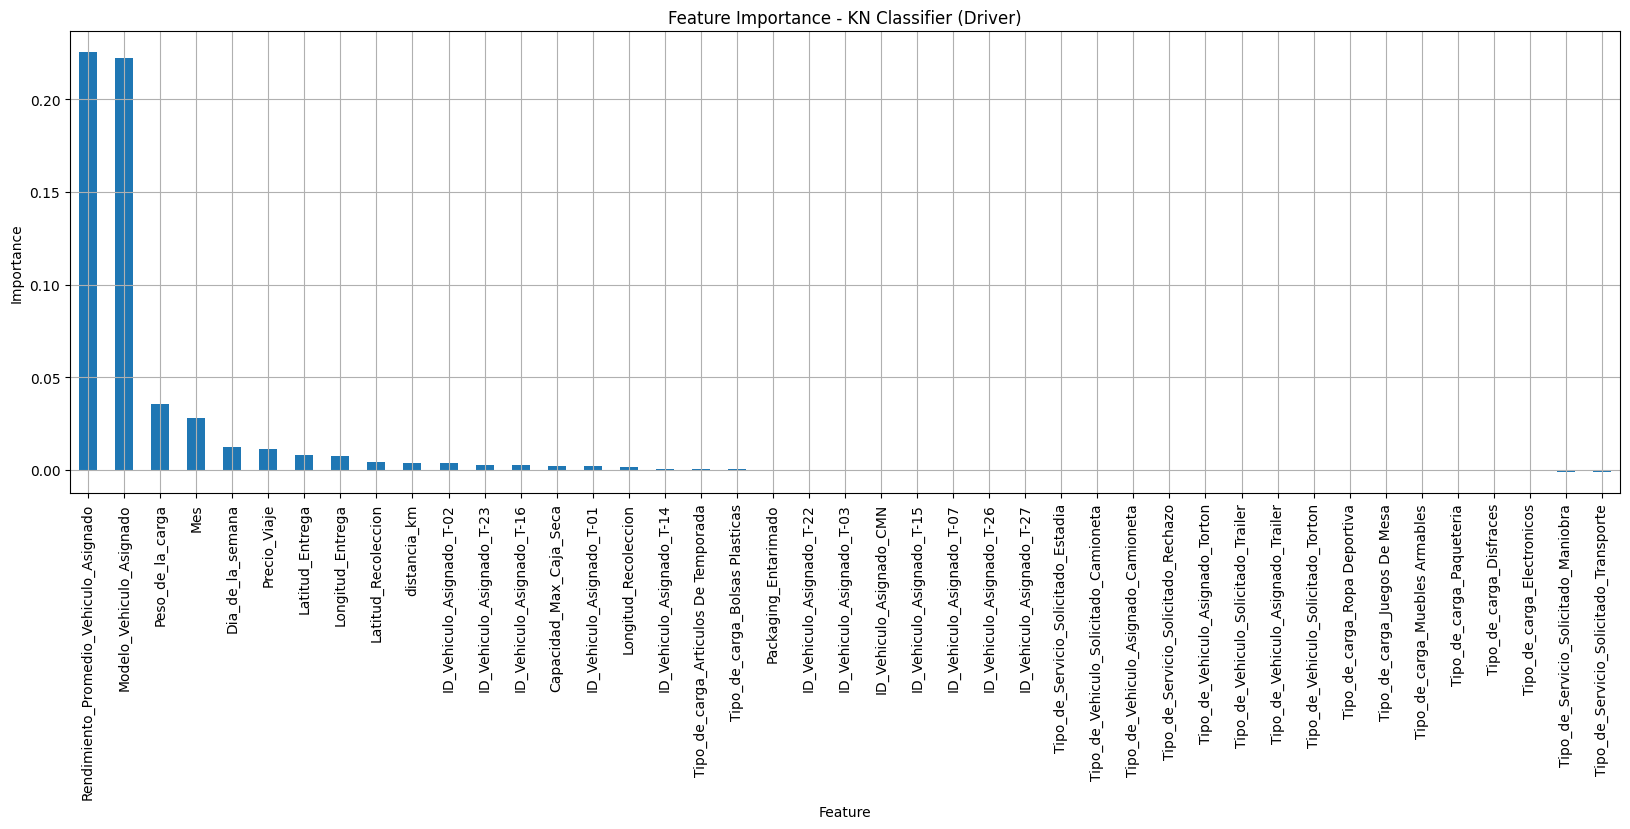

In [430]:
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
# Generamos el Feature importance
feature_importance(model = knn_driver,
                   model_name = "KN Classifier (Driver)",
                   x = x_train_drv_res,
                   y = y_train_drv_res,
                   scorer = F1_scorer)

Podemos observar que la variable con mayor peso es el del rendimiento de combustible, en seguida de el modelo del vehículo asignado, el peso de la carga, el día de la semana.

En general estos datos hacen sentido debido a que generalmente se busca conductores con mejor rendimiento para realizar los viajes, además de que de igual manera se basa en su experiencia para manejar unidades más antiguas o cargas más pesadas.

## Vehículo


In [431]:
# Generamos el modelo KNeighbors Classifier para el df de los conductores
knn_vehicle = KNeighborsClassifier(n_neighbors=5)
# Entrenamos el modelo con los datos de entrenamiento resampleados
knn_vehicle.fit(x_train_veh_res, y_train_veh_res)
# Obtenemos los scores con la función que acabamos de crear
scores_knn_veh = get_metrics_score(model = knn_vehicle,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Accuracy on training set: 0.7535811072396438
Accuracy on test set: 0.34347826086956523
Recall on training set: 0.7535811072396438
Recall on test set: 0.34347826086956523
Precision on training set: 0.7579189175695153
Precision on test set: 0.35903198128463343
F1-Score on training set: 0.7509765911306552
F1-Score on test set: 0.3424883659345136


Evaluación general:
- Overfitting: Podemos observar que el modelo funciona bien únicamente con el training set y que con el test set tiene una métrica mucho menor. Esto significa que el modelo está aprendiendo demasiado del training set, incluyendo ruido y outliers. Ergo, falla al momento de generalizar.

Próximos pasos:
- Ajuste de hiperparámetros: Mejorar la búsqueda para obtener valores óptimos.

- Validación cruzada: utilizar técnicas de validación cruzada para garantizar que el rendimiento del modelo sea coherente en diferentes subconjuntos de datos.

- Comparación con otros modelos: comparar el rendimiento del modelo con otros algoritmos de clasificación como regresión logística, árboles de decisión o máquinas de vectores de soporte para garantizar que KNN sea la mejor opción para su conjunto de datos y problema específicos.

#### Análisis de Características


importances_mean  importances_std
Mes                                                0.379            0.004
Dia_de_la_semana                                   0.311            0.003
Peso_de_la_carga                                   0.244            0.004
Precio_Viaje                                       0.083            0.003
distancia_km                                       0.048            0.001
Latitud_Entrega                                    0.045            0.001
Latitud_Recoleccion                                0.034            0.001
Longitud_Entrega                                   0.006            0.001
Tipo_de_carga_Disfraces                            0.002            0.001
Tipo_de_Vehiculo_Solicitado_Torton                 0.002            0.001
Tipo_de_carga_Articulos De Temporada               0.002            0.000
Tipo_de_Vehiculo_Solicitado_Trailer                0.002            0.001
Tipo_de_carga_Electronicos                         0.002            0.001
Tipo_de_carga_Muebles Armables                     0.001            0.000
Tipo_de_carga_Juegos De Mesa                       0.000            0.001
Tipo_de_carga_Paqueteria                           0.000            0.000
Tipo_de_carga_Ropa Deportiva                      -0.000            0.000
Tipo_de_Servicio_Solicitado_Rechazo               -0.000            0.000
Packaging_Entarimado                              -0.000            0.000
Tipo_de_carga_Bolsas Plasticas                    -0.000            0.000
Longitud_Recoleccion                              -0.000            0.000
Tipo_de_Vehiculo_Solicitado_Camioneta             -0.001            0.000
Tipo_de_Servicio_Solicitado_Estadia               -0.001            0.000
Tipo_de_Servicio_Solicitado_Maniobra              -0.010            0.001
Tipo_de_Servicio_Solicitado_Transporte            -0.011            0.001

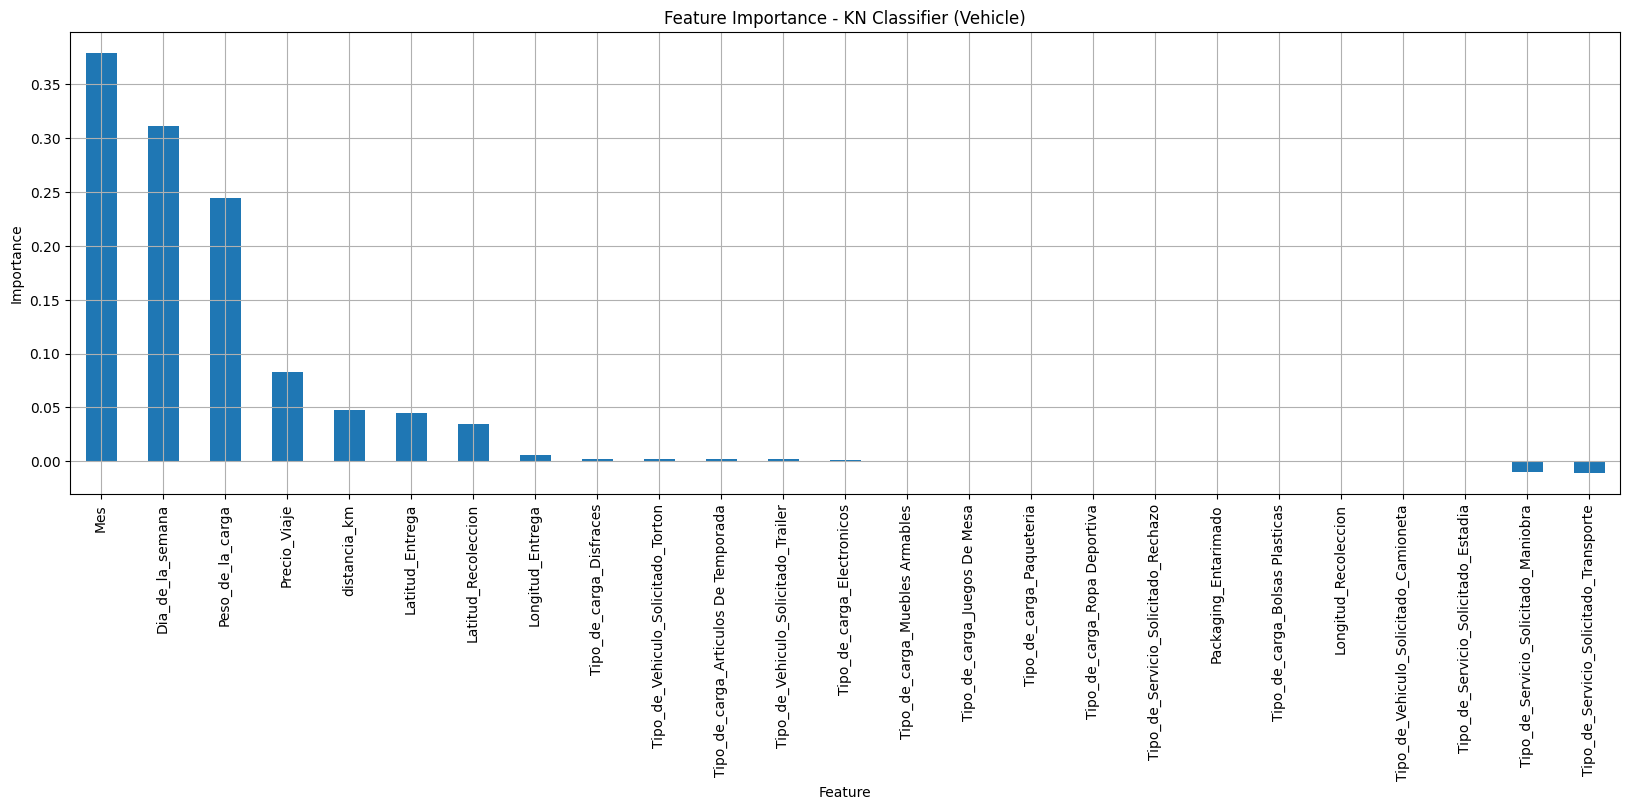

In [432]:
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
# Generamos el Feature importance
feature_importance(model = knn_vehicle,
                   model_name = "KN Classifier (Vehicle)",
                   x = x_train_veh_res,
                   y = y_train_veh_res,
                   scorer = F1_scorer)

Me parece interesante que el mes sea el featue con más peso. En el EDA, se mostró que a pesar de ser un valor importante, este no presentaba alta correlación, por lo que parece peculiar su posición. Los demás datos parecen estar en la posición correcta.

### Content-Based Filtering (CBF)
Este tipo de filtrado a diferencia del filtrado bas (CBF), este se basa prinicipalmente en la similitud de elementos para sugerir nuevos a los usuarios. En nuestro caso, la recomendación de vehículo/conductor será basado en la similitud de las características del viaje en especifico, del vehículo y del usuario, tomando en cuenta el historial de viajes.

La manera en que funcionaría sería:
1. Representación de cada artículo: Cada vehículo y viaje se debe representar como un vector que pueda capturar sus atributos relevantes.

2. Cálculo de similitud: Se calcula la similitud entre los vaijes utilizando métricas como la correlación o distancia.

3. Recomendaciones: Para cada viaje, se identifican los pares de vehículo/conductor con base en la viajes similares al viaje en cuestión.

Para la implementación del CBF utilizaremos Logistic Regression o LR como el algoritmo de clasificación para predecir la probabilidad de que un vehículo/conductor sea recomendado para un viaje en especifico.

Las razones para esto es por su simplicidad, interpretabilidad y su eficiencia.

Dicho esto, empezaremos con su implementación:

## Conductor

In [433]:
# Generamos el modelo Logistic Regression para el df de los conductores
lr_driver = LogisticRegression(random_state=42)
# Entrenamos el modelo con los datos de entrenamiento resampleados
lr_driver.fit(x_train_drv_res, y_train_drv_res)
# Obtenemos los scores con la función que acabamos de crear
scores_lr_drv = get_metrics_score(model = lr_driver,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Accuracy on training set: 0.9677672955974843
Accuracy on test set: 0.957983193277311
Recall on training set: 0.9677672955974843
Recall on test set: 0.957983193277311
Precision on training set: 0.9707003275971627
Precision on test set: 0.958313387873639
F1-Score on training set: 0.967559922386807
F1-Score on test set: 0.9571357121510697


Evaluación general:
- Alto rendimiento: el modelo muestra un muy buen rendimiento en todas las métricas tanto con los datos de training, como los de test. Las métricas tienen un valor alto, lo que indica que el modelo es bueno tanto para aprender de los datos de training como para generalizar ante datos nuevos.

- Overfitting mínimo: ya que tenemos un score relativamente alto en la parte de entrenamiento y ligeramente más alto en comparación con el conjunto de test, sugieren un pequeño overfitting.

- Generalización: el modelo generaliza bien con datos nunca antes vistos, esto lo podemos notar en la ligera caída entre las métricas del conjunto de training contra las de test.

Próximos pasos:
- Ajuste de hiperparámetros: simplemente es ajustar los hiperparámetros para mejorar potencialmente aún más el rendimiento.

- Validación cruzada: utilizar técnicas de validación cruzada para garantizar que el rendimiento del modelo sea coherente en diferentes subconjuntos de datos.

- Análisis de características: analizar las características utilizadas en el modelo para comprender su impacto en el rendimiento del clasificador. Esto puede ayudar en la ingeniería y selección de funciones para mejorar aún más el modelo.

- Comparación con otros modelos: comparar el rendimiento del modelo con otros algoritmos de clasificación como árboles de decisión o máquinas de vectores de soporte para garantizar que KNN sea la mejor opción para su conjunto de datos y problema específicos.

#### Análisis de Características


importances_mean  importances_std
Modelo_Vehiculo_Asignado                           0.122            0.003
Peso_de_la_carga                                   0.101            0.002
ID_Vehiculo_Asignado_T-23                          0.055            0.001
Rendimiento_Promedio_Vehiculo_Asignado             0.054            0.002
ID_Vehiculo_Asignado_T-02                          0.052            0.001
ID_Vehiculo_Asignado_T-16                          0.050            0.001
ID_Vehiculo_Asignado_T-01                          0.029            0.001
ID_Vehiculo_Asignado_T-27                          0.028            0.001
Capacidad_Max_Caja_Seca                            0.019            0.002
ID_Vehiculo_Asignado_T-15                          0.015            0.000
ID_Vehiculo_Asignado_T-22                          0.006            0.001
Mes                                                0.006            0.001
Tipo_de_carga_Ropa Deportiva                       0.004            0.000
Latitud_Entrega                                    0.003            0.001
ID_Vehiculo_Asignado_T-07                          0.002            0.000
Longitud_Entrega                                   0.001            0.000
ID_Vehiculo_Asignado_T-14                          0.001            0.000
Tipo_de_Vehiculo_Solicitado_Torton                 0.001            0.000
Tipo_de_Vehiculo_Solicitado_Trailer                0.001            0.000
distancia_km                                       0.001            0.000
Tipo_de_carga_Bolsas Plasticas                     0.001            0.000
Latitud_Recoleccion                                0.001            0.000
Tipo_de_Servicio_Solicitado_Transporte             0.001            0.000
Precio_Viaje                                       0.000            0.001
ID_Vehiculo_Asignado_T-26                          0.000            0.000
Tipo_de_Servicio_Solicitado_Maniobra               0.000            0.000
Tipo_de_carga_Electronicos                         0.000            0.001
Tipo_de_carga_Articulos De Temporada               0.000            0.000
Tipo_de_carga_Muebles Armables                     0.000            0.000
Tipo_de_Servicio_Solicitado_Estadia                0.000            0.000
ID_Vehiculo_Asignado_T-03                          0.000            0.000
Tipo_de_Servicio_Solicitado_Rechazo                0.000            0.000
Packaging_Entarimado                              -0.000            0.001
Tipo_de_carga_Paqueteria                          -0.000            0.000
Dia_de_la_semana                                  -0.000            0.000
Longitud_Recoleccion                              -0.000            0.000
ID_Vehiculo_Asignado_CMN                          -0.000            0.000
Tipo_de_Vehiculo_Asignado_Camioneta               -0.000            0.000
Tipo_de_Vehiculo_Solicitado_Camioneta             -0.000            0.000
Tipo_de_carga_Disfraces                           -0.000            0.000
Tipo_de_Vehiculo_Asignado_Trailer                 -0.000            0.000
Tipo_de_carga_Juegos De Mesa                      -0.001            0.000
Tipo_de_Vehiculo_Asignado_Torton                  -0.001            0.000

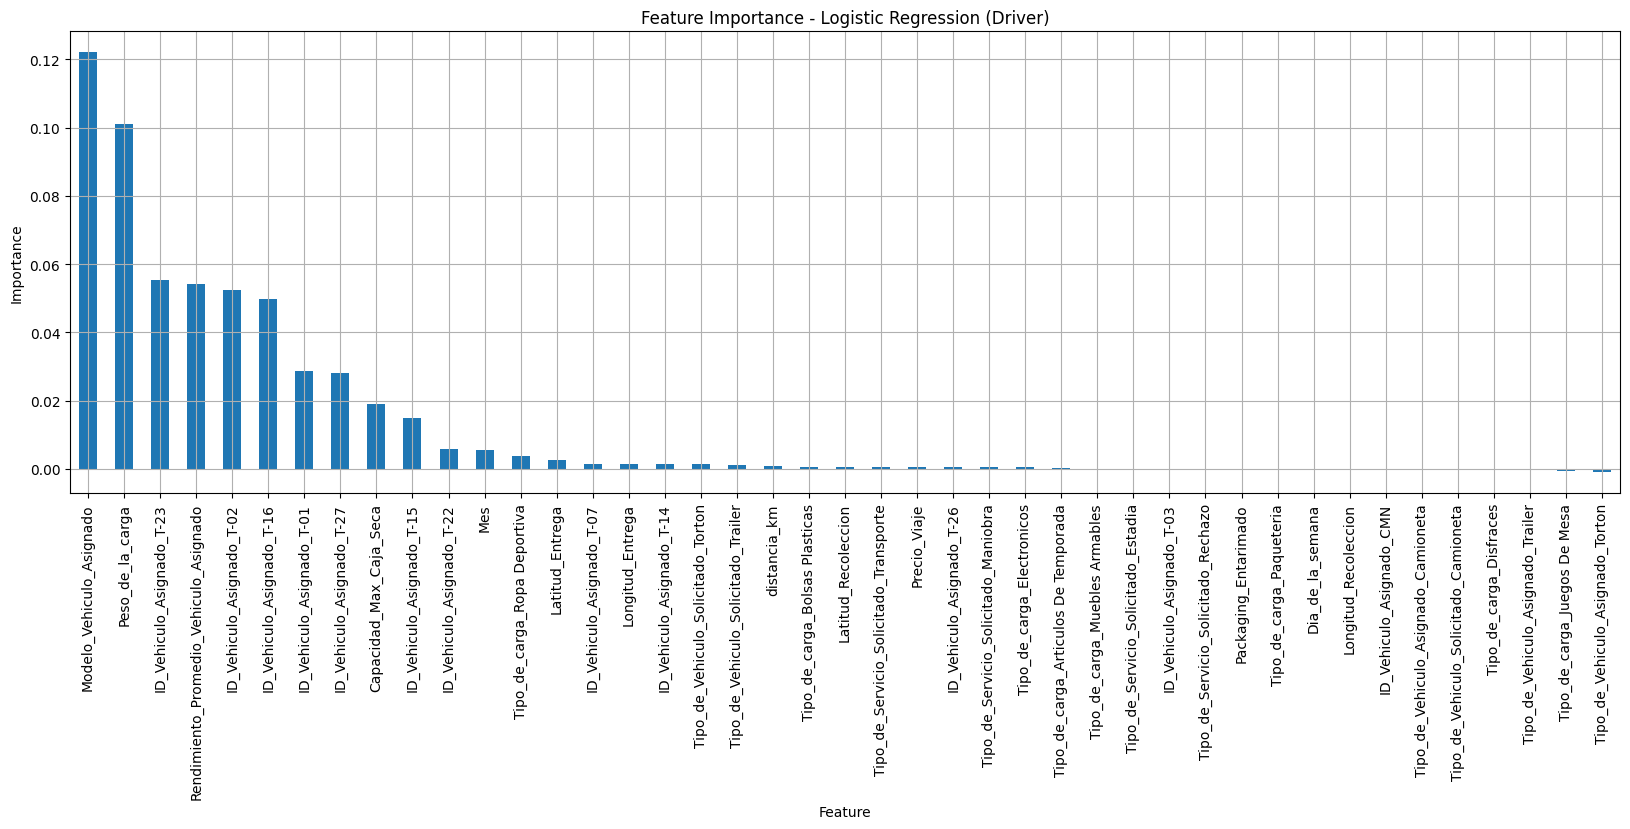

In [434]:
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
# Generamos el Feature importance
feature_importance(model = lr_driver,
                   model_name = "Logistic Regression (Driver)",
                   x = x_train_drv_res,
                   y = y_train_drv_res,
                   scorer = F1_scorer)

Me parece interesante que el año del modelo tenga un peso tan alto en la matriz de importancia. Me hace pensar que probablemente el escalamiento no esté funcionando tan bien como se desea, causando que valores más altos tengan mayor peso.

## Vehículo

In [435]:
# Generamos el modelo Logistic Regression para el df de los conductores
lr_vehicle = LogisticRegression(random_state=42)
# Entrenamos el modelo con los datos de entrenamiento resampleados
lr_vehicle.fit(x_train_veh_res, y_train_veh_res)
# Obtenemos los scores con la función que acabamos de crear
scores_lr_veh = get_metrics_score(model = lr_vehicle,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Accuracy on training set: 0.41927990708478513
Accuracy on test set: 0.29130434782608694
Recall on training set: 0.41927990708478513
Recall on test set: 0.29130434782608694
Precision on training set: 0.40296136446715025
Precision on test set: 0.3283561242770518
F1-Score on training set: 0.40514217721984663
F1-Score on test set: 0.2958005131195078


Evaluación general:
- Bajo rendimiento: el modelo muestra un bajo rendimiento en todas las métricas tanto con los datos de training, como los de test. Esto nos puede indicar que el modelo está subentrenado.

- Overfitting: tenemos un score más alto en la parte de entrenamiento y ligeramente más bajo en el conjunto de test, esto sugieren que hay overfitting.

- Generalización: El modelo parece no capturar la relación compleja de los datos, ergo, este tiene un performance bajo.

- Mala calidad de datos: Esto también podría ser causado por una mala calidad de datos, o con mucho ruido, lo que hace que no se pueda ver con claridad relaciones importantes.

Próximos pasos:
- Ajuste de hiperparámetros: simplemente es ajustar los hiperparámetros para mejorar potencialmente aún más el rendimiento.

- Validación cruzada: utilizar técnicas de validación cruzada para garantizar que el rendimiento del modelo sea coherente en diferentes subconjuntos de datos.

#### Análisis de Características


importances_mean  importances_std
Peso_de_la_carga                                   0.118            0.002
Tipo_de_Vehiculo_Solicitado_Trailer                0.056            0.002
Tipo_de_Vehiculo_Solicitado_Torton                 0.055            0.001
Tipo_de_Vehiculo_Solicitado_Camioneta              0.051            0.001
Mes                                                0.050            0.002
Tipo_de_carga_Electronicos                         0.033            0.002
Tipo_de_carga_Juegos De Mesa                       0.032            0.002
Tipo_de_carga_Ropa Deportiva                       0.025            0.002
distancia_km                                       0.024            0.001
Tipo_de_carga_Paqueteria                           0.014            0.001
Tipo_de_Servicio_Solicitado_Maniobra               0.011            0.002
Packaging_Entarimado                               0.008            0.001
Tipo_de_carga_Disfraces                            0.007            0.001
Latitud_Entrega                                    0.006            0.002
Dia_de_la_semana                                   0.006            0.002
Tipo_de_carga_Muebles Armables                     0.004            0.000
Longitud_Entrega                                   0.003            0.001
Tipo_de_Servicio_Solicitado_Estadia                0.003            0.000
Tipo_de_carga_Articulos De Temporada               0.003            0.001
Tipo_de_carga_Bolsas Plasticas                     0.002            0.000
Latitud_Recoleccion                                0.002            0.001
Tipo_de_Servicio_Solicitado_Rechazo                0.001            0.000
Tipo_de_Servicio_Solicitado_Transporte             0.000            0.001
Precio_Viaje                                       0.000            0.001
Longitud_Recoleccion                              -0.000            0.001

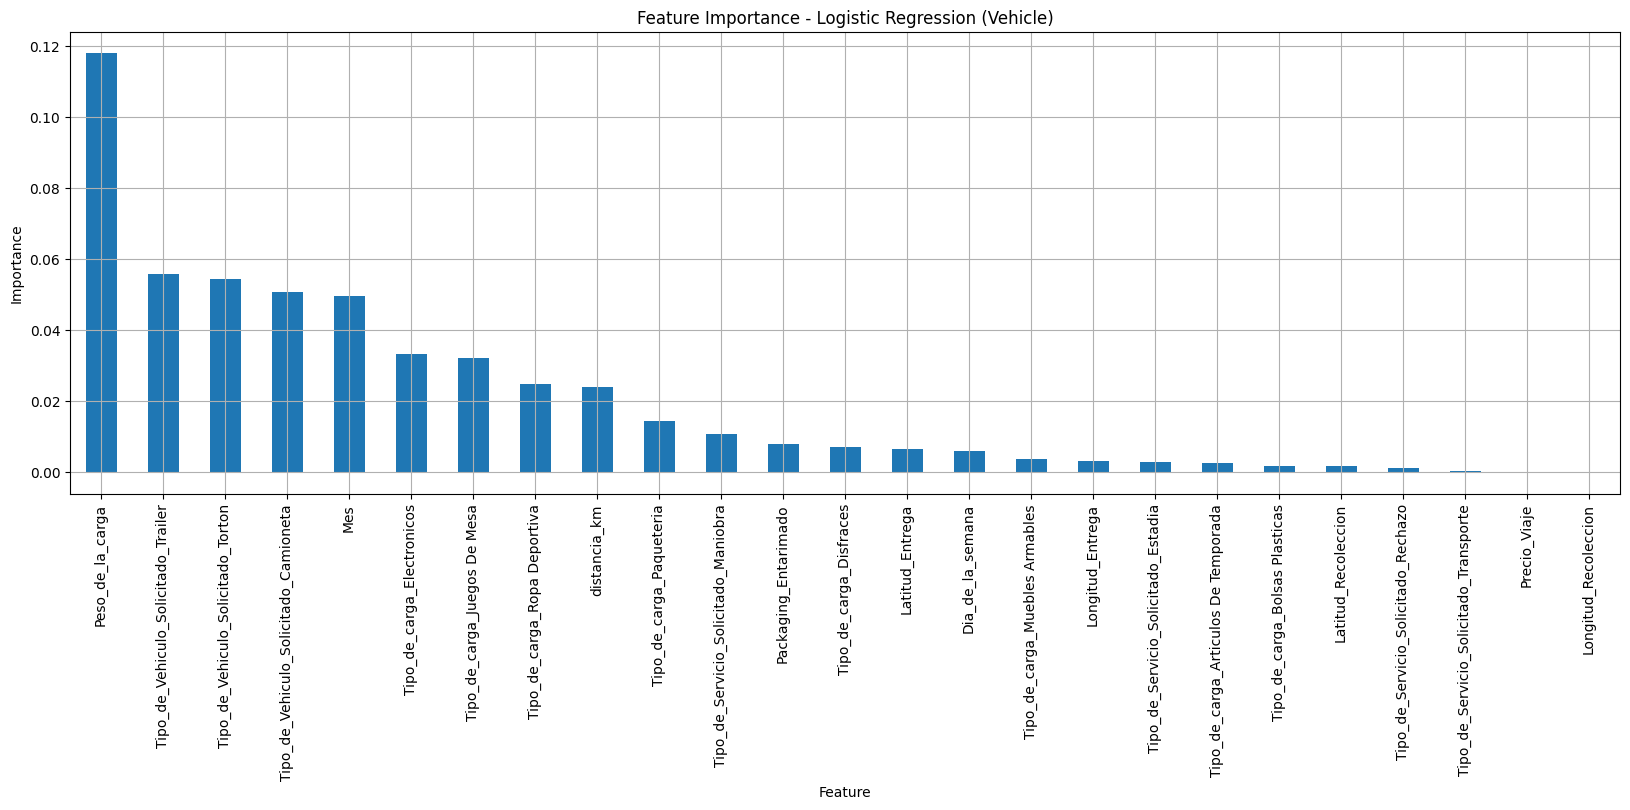

In [436]:
# Seleccionamos F1 como el scorer
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')
# Generamos el Feature importance
feature_importance(model = lr_vehicle,
                   model_name = "Logistic Regression (Vehicle)",
                   x = x_train_veh_res,
                   y = y_train_veh_res,
                   scorer = F1_scorer)

En este caso el análisis de importancia nos da un mejor resultado y con más coherencia, mostrando el peso de la carga como el feature con más peso en la selección del modelo.


## Conclusiones
Podemos observar una diferencia abismal entre los resultados de los modelos para el vehículo, como para el conductor. Esto puede significar distintas que los datos para el vehículo no nos da información relevante, ya sea porque tiene mucho ruido, nos falta obtener más información o simplemente son muy complejas las relaciones para estos modelos.

En general, por los resultados podemos ver que el modelo de Logistic Regression tiene un mejor resultado y reduce el overfitting. Haciéndolo nuestro modelo base para la implementación.

Para los siguientes pasos procederemos a probar nuevos modelos y a ajustar los ya existentes.


_________
# Avance 4 - Modelos Alternativos

Para esta sección probaremos 6 modelos distintos a los ya propuestos para hacer un benchmark de posibles soluciones. Al final se hará una comparativa para seleccionar el modelo con mejor performance para nuestra aplicación.

## Modelos alternativos junto con su búsqueda de hiperparámetros

## Modelo 1: Decision Tree
Decision Tree o árboles de decision son un algoritmo que se utiliza en distintas tareas de clasifiación gracias a su simplicidad, intepretabilidad y efectividad. Si lo vemos en general, este se construye de manera recursiva a partir de un conjunto de datos de entrenamiento. Como su nombre lo indica, este parece un árbol, cada nodo representa una prueba sobre un feature y las ramas representan posibles resultados. Al final, en los nodos finales se asignan instancias de datos a una clase predicha.

Este podría ser un buen modelo para clasificar los vehículos y conductores.
#### Parámetros de Búsqueda

Para encontrar los mejores valores, utilizamos una matriz de posibles valores para que con herramientas como GridSearch o Random Search podamos encontrar la mejor combinación. En este caso los posibles factores son los siguientes:
1. Max Depth: Controla que tan profundo puede crecer el arbol. Entre más grande el árbol puede capturar más ruido y hacer overfitting.
2. Min Samples Leaf: Nos determina el número mínimo de samples que pueden estar en el útlimo nodo. Esto ayuda a prevenir overfitting.
3. Max Leaf Nodes: Setea el número máximo de hojas que cada nodo puede tener.
4. Min Impurity Decrease: Define la mejora mínima en la métrica cualitativa del corte, requerido para crear un nuevo corte en el arbol. Ayuda a prevenir cortes que no generan mejoría en el modelo.

In [437]:
# Parameter grid to pass in RandomSearchCV
param_grid_dt = {'max_depth': np.arange(2,30),
                'min_samples_leaf': [1, 2, 5, 7, 10],
                'max_leaf_nodes' : [2, 3, 5, 10,15],
                'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
                }

F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor

In [438]:
# Inicializamos el modelo base
dt_drv = DecisionTreeClassifier(max_depth=3, random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_dt_drv = RandomizedSearchCV(estimator=dt_drv, param_distributions=param_grid_dt, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_dt_drv.fit(x_train_drv_res,y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el decision tree del conductor son {} con un score de cross validation de {}:" .format(rndm_cv_dt_drv.best_params_,rndm_cv_dt_drv.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
dt_drv_tuned = DecisionTreeClassifier(
    max_depth=rndm_cv_dt_drv.best_params_['max_depth'],
    max_leaf_nodes=rndm_cv_dt_drv.best_params_['max_leaf_nodes'],
    random_state=1,
    min_impurity_decrease=rndm_cv_dt_drv.best_params_['min_impurity_decrease'],
    min_samples_leaf=rndm_cv_dt_drv.best_params_['min_samples_leaf']
)

# Hacemos el fitting del modelo
dt_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

# Evaluamos el modelo
scores_dt_drv = get_metrics_score(model = dt_drv_tuned,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Los mejores parámetros para el decision tree del conductor son {'min_samples_leaf': 5, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 18} con un score de cross validation de 0.9670269160859147:
Accuracy on training set: 0.9688679245283018
Accuracy on test set: 0.9621848739495799
Recall on training set: 0.9688679245283018
Recall on test set: 0.9621848739495799
Precision on training set: 0.9695322788640521
Precision on test set: 0.9622291910336804
F1-Score on training set: 0.968819444451457
F1-Score on test set: 0.9616711026762303


#### Overall Insights:
Alto Desempeño y Consistencia: Los resultados muestran alto rendimiento en ambos conjuntos. Además, estos infican que el modelo ha logrado un buen balance de ajuste y buena generalización, evitando el overfitting.

### Vehículo

In [439]:
# Inicializamos el modelo base
dt_veh = DecisionTreeClassifier(max_depth=3, random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_dt_veh = RandomizedSearchCV(estimator=dt_drv, param_distributions=param_grid_dt, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_dt_veh.fit(x_train_veh_res,y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el decision tree del vehiculo son {} con un score de cross validation de {}:" .format(rndm_cv_dt_veh.best_params_,rndm_cv_dt_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
dt_veh_tuned = DecisionTreeClassifier(
    max_depth=rndm_cv_dt_veh.best_params_['max_depth'],
    max_leaf_nodes=rndm_cv_dt_veh.best_params_['max_leaf_nodes'],
    random_state=1,
    min_impurity_decrease=rndm_cv_dt_veh.best_params_['min_impurity_decrease'],
    min_samples_leaf=rndm_cv_dt_veh.best_params_['min_samples_leaf']
)

# Hacemos el fitting del modelo
dt_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

# Evaluamos el modelo
scores_dt_veh = get_metrics_score(model = dt_veh_tuned,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Los mejores parámetros para el decision tree del vehiculo son {'min_samples_leaf': 5, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 15, 'max_depth': 18} con un score de cross validation de 0.3678532704281741:
Accuracy on training set: 0.4357336430507162
Accuracy on test set: 0.2747826086956522
Recall on training set: 0.4357336430507162
Recall on test set: 0.2747826086956522
Precision on training set: 0.38162805254869114
Precision on test set: 0.21644940606309956
F1-Score on training set: 0.370077500613091
F1-Score on test set: 0.20410248639419598


### Overall Insights:
- Bajo Desempeño General: Las métricas indican un desempeño pobre del modelo en ambos conjuntos de datos. Un accuracy de 44% en el entrenamiento y 27% en la prueba es significativamente bajo, lo que sugiere que el modelo no está capturando bien las relaciones en los datos.

- Overfitting: Hay una disminución considerable en las métricas del conjunto de entrenamiento al conjunto de prueba, lo que sugiere problemas de generalización. Esto podría ser una señal de overfitting, a pesar de las restricciones en los parámetros.



## Modelo 2 - Bagging Classifier
Bagging Classifier es un método de machine learning que utiliza múltiples árboles de decisión para mejorar robustez y precisión  de la clasificación multivariable.

La idea detrás de esto es entrenar múltiples árboles de decisión de manera independiente, utilizando subconjuntos aleatores del conjunto de entrenamiento. Cada árbol se construye y luego se combinan los resultados.

#### Parámetros de Búsqueda
1. Max Samples: Nos dice la porción de samples que se puede extraer del training set para entrenar de manera individual cada decision tree
2. Recommendation: Este parametro controla la proporción aleatoria de los features que se consideraran para separar cada nodo
3. Max Features: Es el número de decision trees utilizado

In [440]:
param_grid_bag = {'max_samples': [0.7,0.8,0.9,1],
                  'max_features': [0.7,0.8,0.9,1],
                  'n_estimators' : [10,20,30,40,50],
                 }

F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor

In [441]:
# Inicializamos el modelo base
bag_drv = BaggingClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_bag_drv = RandomizedSearchCV(estimator=bag_drv, param_distributions=param_grid_bag, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_bag_drv.fit(x_train_drv_res,y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Bagging del conductor son {} con un score de cross validation de {}:" .format(rndm_cv_bag_drv.best_params_,rndm_cv_bag_drv.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
bag_drv_tuned = BaggingClassifier(
    max_samples=rndm_cv_bag_drv.best_params_['max_samples'],
    max_features=rndm_cv_bag_drv.best_params_['max_features'],
    random_state=1,
    n_estimators=rndm_cv_bag_drv.best_params_['n_estimators']
)

# Hacemos el fitting del modelo
bag_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

# Evaluamos el modelo
scores_bag_drv = get_metrics_score(model = bag_drv_tuned,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Los mejores parámetros para el Bagging del conductor son {'n_estimators': 40, 'max_samples': 0.8, 'max_features': 0.9} con un score de cross validation de 0.9841483130874635:
Accuracy on training set: 0.9976415094339622
Accuracy on test set: 0.9653361344537815
Recall on training set: 0.9976415094339622
Recall on test set: 0.9653361344537815
Precision on training set: 0.997667463965562
Precision on test set: 0.9653536484813433
F1-Score on training set: 0.9976448758754964
F1-Score on test set: 0.964917663173465


### Overall insights
Podemos observar que de igual manera, este modelo tiene un nivel alto de rendimiento y de generalización, esto debido al alto nivel de rendimiento mostrado en los resultados. Podemos observar que tiene un nivel bajo de overfitting pero aún así existe. Esto debido a la diferencia entre los datos de entrenamiento y los datos de prueba.

### Vehículo

In [442]:
# Inicializamos el modelo base
bag_veh = BaggingClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_bag_veh = RandomizedSearchCV(estimator=bag_veh, param_distributions=param_grid_bag, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_bag_veh.fit(x_train_veh_res,y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Bagging del vehiculo son {} con un score de cross validation de {}:" .format(rndm_cv_bag_veh.best_params_,rndm_cv_bag_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
bag_veh_tuned = BaggingClassifier(
    max_samples=rndm_cv_bag_veh.best_params_['max_samples'],
    max_features=rndm_cv_bag_veh.best_params_['max_features'],
    random_state=1,
    n_estimators=rndm_cv_bag_veh.best_params_['n_estimators']
)

# Hacemos el fitting del modelo
bag_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

# Evaluamos el modelo
scores_bag_veh = get_metrics_score(model = bag_veh_tuned,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Los mejores parámetros para el Bagging del vehiculo son {'n_estimators': 50, 'max_samples': 0.9, 'max_features': 0.9} con un score de cross validation de 0.8047177541264878:
Accuracy on training set: 0.9278939217963608
Accuracy on test set: 0.4295652173913043
Recall on training set: 0.9278939217963608
Recall on test set: 0.4295652173913043
Precision on training set: 0.9291987202573351
Precision on test set: 0.4380312863602526
F1-Score on training set: 0.9274965856476503
F1-Score on test set: 0.4315360722480248


### Overall Insights:
A pesar de ver que si mejora el rendimiento del modelo considerablemente. Podemos ver que aún así el rendimiento con el conjunto de prueba es muy bajo. Esto sólo reafirma la posibilidad de que el modelo tenga una mala calidad de datos para la selección del vehículo.

## Modelo 3 - Random Forest Classifier
Random Forest es un algoritmo de ML que combina múltiples árboles de decisión para mejorar la precisión y robustez de la clasificación.

A diferencia de Bagging, en cada nodo del árbol se introducen elementos aleatorios durante el proceso de entrenamiento. Esto generalmente provoca un mayor nivel de precisión, además de ser más robusto ante el overfitting.

### Parámetros de Búsqueda
- N Estimators: Este parámetro settea el número de decision trees dentro del random forest
- Min Samples Leaf: Este parámetro determina el mínimo de hojas permitida en el último nodo del árbol.
- Max Features: Número de features que se escogen de manera random del training set que son considerados para el split de cada nodo en cada decision tree
- Max samples: Este parámetro controla la proporción de los samples que se extrae de cada training set para entrenar cada decision tree

In [443]:
param_grid_rf = {"n_estimators": [100,150,250],
              "min_samples_leaf": np.arange(1, 6),
              "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt','log2'],
              "max_samples": np.arange(0.2, 0.6, 0.1)}
F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor

In [444]:
# Inicializamos el modelo base
rf_drv = RandomForestClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_rf_drv = RandomizedSearchCV(estimator=rf_drv, param_distributions=param_grid_rf, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_rf_drv.fit(x_train_drv_res,y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el random forest del conductor son {} con un score de cross validation de {}:" .format(rndm_cv_rf_drv.best_params_,rndm_cv_rf_drv.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
rf_drv_tuned = RandomForestClassifier(
    n_estimators=rndm_cv_rf_drv.best_params_['n_estimators'],
    min_samples_leaf=rndm_cv_rf_drv.best_params_['min_samples_leaf'],
    random_state=1,
    max_features=rndm_cv_rf_drv.best_params_['max_features'],
    max_samples=rndm_cv_rf_drv.best_params_['max_samples']
)

# Hacemos el fitting del modelo
rf_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

# Evaluamos el modelo
scores_rf_drv = get_metrics_score(model = rf_drv_tuned,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Los mejores parámetros para el random forest del conductor son {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.5000000000000001, 'max_features': 'log2'} con un score de cross validation de 0.9813454513292225:
Accuracy on training set: 0.9944968553459119
Accuracy on test set: 0.9653361344537815
Recall on training set: 0.9944968553459119
Recall on test set: 0.9653361344537815
Precision on training set: 0.9945019091679753
Precision on test set: 0.9656065271222133
F1-Score on training set: 0.9944965739179583
F1-Score on test set: 0.9648226358526228


### Overall insights
Podemos observar que de igual manera, este modelo tiene un nivel alto de rendimiento y de generalización, esto debido al alto nivel de rendimiento mostrado en los resultados. Podemos observar que tiene un nivel bajo de overfitting pero aún así existe. Esto debido a la diferencia entre los datos de entrenamiento y los datos de prueba.

### Vehículo

In [445]:
# Inicializamos el modelo base
rf_veh = RandomForestClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_rf_veh = RandomizedSearchCV(estimator=rf_veh, param_distributions=param_grid_rf, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_rf_veh.fit(x_train_veh_res,y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el random forest del vehiculo son {} con un score de cross validation de {}:" .format(rndm_cv_rf_veh.best_params_,rndm_cv_rf_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
rf_veh_tuned = RandomForestClassifier(
    n_estimators=rndm_cv_rf_veh.best_params_['n_estimators'],
    min_samples_leaf=rndm_cv_rf_veh.best_params_['min_samples_leaf'],
    random_state=1,
    max_features=rndm_cv_rf_veh.best_params_['max_features'],
    max_samples=rndm_cv_rf_veh.best_params_['max_samples']
)

# Hacemos el fitting del modelo
rf_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

# Evaluamos el modelo
scores_rf_veh = get_metrics_score(model = rf_veh_tuned,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Los mejores parámetros para el random forest del vehiculo son {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.5000000000000001, 'max_features': 'sqrt'} con un score de cross validation de 0.7884122805615364:
Accuracy on training set: 0.9237320944638018
Accuracy on test set: 0.4165217391304348
Recall on training set: 0.9237320944638018
Recall on test set: 0.4165217391304348
Precision on training set: 0.9252007403584436
Precision on test set: 0.4292732422061522
F1-Score on training set: 0.9231577843927988
F1-Score on test set: 0.4192302173988813


### Overall Insights:
Podemos ver un nivel muy alto de overfitting, el modelo se comporta de buena manera con los datos de entrenamiento y muy mal con los de prueba. Es necesario hacer una reevaluación de los datos para el entrenamiento.

## Modelo 4 - AdaBoost Tree
Adaboost o Adaptive Boosting es un modelo ed ML que combina multiples decision trees para construir un clasificador robusto y preciso. A diferencia de otros métodos, este usa un mecanismo llamado ponderación adaptativa que le da un peso mayor a arboles que tienen un mejor rendimiento en subconjuntos específicos. Esto en general ayuda a la precisión del modelo.

### Parámetros de Búsqueda
- n estimators: este fator es el número de etapas de boosting o iteraciones que se usan en adaboost. En cada etapa un nuevo arbol de decisiones debil es añadido.
- learning rate: Este parametro controla el impacto de cada nuevo arbol añadido al modelo
- base estimator: especigica los parámetros usados en cada weak learner de cada etapa de boosting

In [446]:
param_grid_adab = {
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
    ],
}

F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor


In [447]:
# Inicializamos el modelo base
adab_drv = AdaBoostClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_adab_drv = RandomizedSearchCV(estimator=adab_drv, param_distributions=param_grid_adab, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_adab_drv.fit(x_train_drv_res,y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Adaboost del conductor son {} con un score de cross validation de {}:" .format(rndm_cv_adab_drv.best_params_,rndm_cv_adab_drv.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
adab_drv_tuned = AdaBoostClassifier(
    n_estimators=rndm_cv_adab_drv.best_params_['n_estimators'],
    learning_rate=rndm_cv_adab_drv.best_params_['learning_rate'],
    random_state=1,
    base_estimator=rndm_cv_adab_drv.best_params_['base_estimator']
)

# Hacemos el fitting del modelo
adab_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

# Evaluamos el modelo
scores_adab_drv = get_metrics_score(model = adab_drv_tuned,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Los mejores parámetros para el Adaboost del conductor son {'n_estimators': 60, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} con un score de cross validation de 0.9639134854297401:
Accuracy on training set: 0.9705974842767295
Accuracy on test set: 0.9611344537815126
Recall on training set: 0.9705974842767295
Recall on test set: 0.9611344537815126
Precision on training set: 0.9732212146804298
Precision on test set: 0.9617690086256688
F1-Score on training set: 0.9705431904342445
F1-Score on test set: 0.9606033365244635


### Overall Insight:
- Modelo Balanceado y Generalizado: EL modelo muestra estar bien balanceado, además de que generaliza bien datos no vistos. La similitud de las métricas sugiere que el modelo no está sobre ajustado.
- Alto rendimiento: Los resultados son consistentemente altas, indicando que el modelo es robusto y confiable

### Vehículo

In [448]:
# Inicializamos el modelo base
adab_veh = AdaBoostClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_adab_veh = RandomizedSearchCV(estimator=adab_veh, param_distributions=param_grid_adab, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_adab_veh.fit(x_train_veh_res,y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Adaboost del vehículo son {} con un score de cross validation de {}:" .format(rndm_cv_adab_veh.best_params_,rndm_cv_adab_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
adab_veh_tuned = AdaBoostClassifier(
    n_estimators=rndm_cv_adab_veh.best_params_['n_estimators'],
    learning_rate=rndm_cv_adab_veh.best_params_['learning_rate'],
    random_state=1,
    base_estimator=rndm_cv_adab_veh.best_params_['base_estimator']
)

# Hacemos el fitting del modelo
adab_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

# Evaluamos el modelo
scores_adab_veh = get_metrics_score(model = adab_veh_tuned,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Los mejores parámetros para el Adaboost del vehículo son {'n_estimators': 50, 'learning_rate': 0.01, 'base_estimator': DecisionTreeClassifier(max_depth=3, random_state=1)} con un score de cross validation de 0.35756874172817693:
Accuracy on training set: 0.4155052264808362
Accuracy on test set: 0.29478260869565215
Recall on training set: 0.4155052264808362
Recall on test set: 0.29478260869565215
Precision on training set: 0.48904861333070676
Precision on test set: 0.43116445411187726
F1-Score on training set: 0.354015267449293
F1-Score on test set: 0.24374651173281406


### Overall Insight:
- Modelo subentrenado: Los resultados sugieren que este modelo no es el adecuado para la clasificación específica. Las métricas son bajas en ambos caoss.
- Sub ajuste: Los resultados sugieren que el modelo esta sufriendo un subajuste, siendo incapaz de capturar la complejidad de los datos en ambos sets.
- Learning rate bajo: Este parámetro salio demasiado bajo, lo que puede provocar que el modelo no aprenda de manera óptima.

## Modelo 5 - Gradient Boost

Gradient Boost es un modelo que al igual que los anteriores combina multiples arboles de decisión debiles para construir un clasificador robusto y preciso. La diferencia con este método es que usa un enfoque secuencial para construir el modelo. En cada iteración, se agrega un nuevo arbol al ensamble, optimizando la selección de características y dirección de división, minimizando el error.

### Parámetros de Búsqueda
- Init: Este parámetro especifica el modelo inicial usado para la primera iteración
- N Estimators: Nos dice el número de etapas de boosting o iteraciones que se usarán.
- Learning Rate: Nos dice el impacto que tendra cada nuevo árbol añadido
- Subsample: Nos permite controlar la porción de samples que se extraerán del training set original para entrenar cada decision tree.
- Max Features: Control a la porción de columnas que se seleccionarán random del training set original para considerar en el split de cada nodo en cada decision tree.

In [449]:
param_grid_gb = {"init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
                  "n_estimators": np.arange(75,150,25),
                  "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
                  "subsample":[0.5,0.7,1],
                  "max_features":[0.5,0.7,1],
                }

F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor

In [472]:
# Inicializamos el modelo base
gb_drv = GradientBoostingClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_gb_drv = RandomizedSearchCV(estimator=gb_drv, param_distributions=param_grid_gb, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_gb_drv.fit(x_train_drv_res,y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Gradient Boost del conductor son {} con un score de cross validation de {}:" .format(rndm_cv_gb_drv.best_params_,rndm_cv_gb_drv.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
gb_drv_tuned = GradientBoostingClassifier(
    init=rndm_cv_gb_drv.best_params_['init'],
    n_estimators=rndm_cv_gb_drv.best_params_['n_estimators'],
    random_state=1,
    learning_rate=rndm_cv_gb_drv.best_params_['learning_rate'],
    subsample=rndm_cv_gb_drv.best_params_['subsample'],
    max_features=rndm_cv_gb_drv.best_params_['max_features']
)

# Hacemos el fitting del modelo
gb_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

# Evaluamos el modelo
scores_gb_drv = get_metrics_score(model = gb_drv_tuned,
                               train = x_train_drv_res,
                               test = x_driver_test,
                               train_y = y_train_drv_res,
                               test_y = y_driver_test)

Los mejores parámetros para el Gradient Boost del conductor son {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.7, 'learning_rate': 0.1, 'init': DecisionTreeClassifier(random_state=1)} con un score de cross validation de 0.9797507451657099:
Accuracy on training set: 0.9984276729559748
Accuracy on test set: 0.9590336134453782
Recall on training set: 0.9984276729559748
Recall on test set: 0.9590336134453782
Precision on training set: 0.9984432488032597
Precision on test set: 0.9588144709427386
F1-Score on training set: 0.9984276107594937
F1-Score on test set: 0.9586562205512243


### Overall Insight:
- Modelo bien balanceado y buena generalización: los resultados muestran que el modelo está bien balanceado y generaliza bien. Los resultados muestran por su similitud que no hay overfitting.
- Tiene un desempeño excelente, lo que indica que el modelo es robusto y confiable
- El alto nivel de cross validation sugiere que el modelo tiene una capacidad de predicción alta.

### Vehículo

In [477]:
# Inicializamos el modelo base
gb_veh = GradientBoostingClassifier(random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_gb_veh = RandomizedSearchCV(estimator=gb_veh, param_distributions=param_grid_gb, n_jobs = -1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1)
rndm_cv_gb_veh.fit(x_train_veh_res,y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el Gradient Boost del vehículo son {} con un score de cross validation de {}:" .format(rndm_cv_gb_veh.best_params_,rndm_cv_gb_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
gb_veh_tuned = GradientBoostingClassifier(
    init=rndm_cv_gb_veh.best_params_['init'],
    n_estimators=rndm_cv_gb_veh.best_params_['n_estimators'],
    random_state=1,
    learning_rate=rndm_cv_gb_veh.best_params_['learning_rate'],
    subsample=rndm_cv_gb_veh.best_params_['subsample'],
    max_features=rndm_cv_gb_veh.best_params_['max_features']
)

# Hacemos el fitting del modelo
gb_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

# Evaluamos el modelo
scores_gb_veh = get_metrics_score(model = gb_veh_tuned,
                               train = x_train_veh_res,
                               test = x_vehicle_test,
                               train_y = y_train_veh_res,
                               test_y = y_vehicle_test)

Los mejores parámetros para el Gradient Boost del vehículo son {'subsample': 1, 'n_estimators': 100, 'max_features': 0.5, 'learning_rate': 0.05, 'init': DecisionTreeClassifier(random_state=1)} con un score de cross validation de 0.7978738364883697:
Accuracy on training set: 0.9286682152535811
Accuracy on test set: 0.4156521739130435
Recall on training set: 0.9286682152535811
Recall on test set: 0.4156521739130435
Precision on training set: 0.9300041529426932
Precision on test set: 0.4222509817570388
F1-Score on training set: 0.928349277662178
F1-Score on test set: 0.4179337745836688


### Overall Results:
- Discrepancia en el rendimiento: Existe una diferencia abismal entre los resultados del training y del testing dataset. Esto sugiere que el modelo está sobreajustado a los datos de entrenamiento y que no generaliza bien.
- Overfitting: el modelo pareciera, por los resultados, que memorizó los datos de entrenamiento, más que haber aprendido de ellos. Ergo, no genero conocimiento sobre los patrones generalizables.
- Parametros poco efectivos en pruebas: Los parámetros parecen ser efectivos únicamente en los datos de entrenamiento y no en los de prueba.

## Modelo 6 - MLP
MUltilayer perceptron o MLP, son redes neuronales artificiales multicapa supervisada. A diferencia de las redes neuronales simples, estos cuentan con una arquitectura compleja que incluye múltiples capas ocultas entre la capa de entrada y la capa de salida.

La manera en que funciona que es que los MLPs procesan información a través de un flujo de señales entre capas compuestas por neuronas artificiales. Cada neurona aplica una función de activación no lineal a la suma ponderada de sus entradas, generando una salida que se propaga a la siguiente capa. Este proceso iterativo le permite a la red aprender patrones complejos en los datos de entrenamiento y realizar predicciones.

### Parámetros de Búsqueda
- Hidden Layers sizes: captura la arquitectura deseada para las capas ocultas en el MLP. Es una tupla de números que nos dan el número de neuronas en cada capa.
- Activation: Nos especifica la función de activación que se le da a la suma ponderada de inputs de cada neurona. Esta función le da su no linearidad a la red.
- Solver: Este parámetro especifica el algoritmo usado para entrenar el MLP. Este minimza la loss function ajustando los pesos de la red.
- Alpha: Est afunción controla el nivel del termino de regularización L1. Este penaliza al modelo por tener pesos grandes y reduce la cantidad de componentes diferentes a cero, ayudando a prevenir el overfitting.
- Learning Rate: Controla el step size que se de por el optimizador durante el entrenamiento para actuzalizar los pesos en la red.

In [456]:
from sklearn.neural_network import MLPClassifier
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}


F1_scorer = metrics.make_scorer(metrics.f1_score, average='weighted')

### Conductor

In [458]:
# Inicializamos el modelo base
mlp_drv = MLPClassifier(max_iter=1000, random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_mlp_drv = RandomizedSearchCV(estimator=mlp_drv, param_distributions=param_grid_mlp, n_jobs=-1, n_iter=40, scoring=F1_scorer, cv=5, random_state=1, verbose=10)
rndm_cv_mlp_drv.fit(x_train_drv_res, y_train_drv_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el MLP del conductor son {} con un score de cross validation de {}:".format(rndm_cv_mlp_drv.best_params_, rndm_cv_mlp_drv.best_score_))
# reinicializamos el modelo, pero esta vez con los valores óptimos
mlp_drv_tuned = MLPClassifier(
    hidden_layer_sizes=rndm_cv_mlp_drv.best_params_['hidden_layer_sizes'],
    activation=rndm_cv_mlp_drv.best_params_['activation'],
    solver=rndm_cv_mlp_drv.best_params_['solver'],
    alpha=rndm_cv_mlp_drv.best_params_['alpha'],
    learning_rate=rndm_cv_mlp_drv.best_params_['learning_rate'],
    max_iter=1000,
    random_state=1
)

# Hacemos el fitting del modelo
mlp_drv_tuned.fit(x_train_drv_res, y_train_drv_res)

# Evaluamos el modelo
scores_mlp_drv = get_metrics_score(
    model=mlp_drv_tuned,
    train=x_train_drv_res,
    test=x_driver_test,
    train_y=y_train_drv_res,
    test_y=y_driver_test
)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Los mejores parámetros para el MLP del conductor son {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'tanh'} con un score de cross validation de 0.9763029428059118:
Accuracy on training set: 0.9976415094339622
Accuracy on test set: 0.9590336134453782
Recall on training set: 0.9976415094339622
Recall on test set: 0.9590336134453782
Precision on training set: 0.9976823214873111
Precision on test set: 0.9592099911712128
F1-Score on training set: 0.9976412630615986
F1-Score on test set: 0.9589310593195178


### Overall Insight:
- Modelo bien balanceado y buena generalización: los resultados muestran que el modelo está bien balanceado y generaliza bien. Los resultados muestran por su similitud que no hay overfitting.
- Tiene un desempeño excelente, lo que indica que el modelo es robusto y confiable
- El alto nivel de cross validation sugiere que el modelo tiene una capacidad de predicción alta.

### Vehículo

In [459]:
# Inicializamos el modelo base
mlp_veh = MLPClassifier(max_iter=1000, random_state=1)
# Para encontrar los parámetros ideales del modelo, utilizamos  randomized
# search para reducir el tiempo de ejecución y encontrar una de las mejores
# combinaciones
rndm_cv_mlp_veh = RandomizedSearchCV(estimator=mlp_veh, param_distributions=param_grid_mlp, n_jobs=-1, n_iter=50, scoring=F1_scorer, cv=5, random_state=1, verbose=10)
rndm_cv_mlp_veh.fit(x_train_veh_res, y_train_veh_res)
# Una vez entrenado podemos ver cuáles son los valores ideales para el modelo
print("Los mejores parámetros para el MLP del vehiculo son {} con un score de cross validation de {}:".format(rndm_cv_mlp_veh.best_params_, rndm_cv_mlp_veh.best_score_))

# reinicializamos el modelo, pero esta vez con los valores óptimos
mlp_veh_tuned = MLPClassifier(
    hidden_layer_sizes=rndm_cv_mlp_veh.best_params_['hidden_layer_sizes'],
    activation=rndm_cv_mlp_veh.best_params_['activation'],
    solver=rndm_cv_mlp_veh.best_params_['solver'],
    alpha=rndm_cv_mlp_veh.best_params_['alpha'],
    learning_rate=rndm_cv_mlp_veh.best_params_['learning_rate'],
    max_iter=1000,
    random_state=1
)

# Hacemos el fitting del modelo
mlp_veh_tuned.fit(x_train_veh_res, y_train_veh_res)

# Evaluamos el modelo
scores_mlp_veh = get_metrics_score(
    model=mlp_veh_tuned,
    train=x_train_veh_res,
    test=x_vehicle_test,
    train_y=y_train_veh_res,
    test_y=y_vehicle_test
)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Los mejores parámetros para el MLP del vehiculo son {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.0001, 'activation': 'tanh'} con un score de cross validation de 0.5784347299362629:
Accuracy on training set: 0.6608594657375145
Accuracy on test set: 0.34
Recall on training set: 0.6608594657375145
Recall on test set: 0.34
Precision on training set: 0.6544796603776077
Precision on test set: 0.3691941961622831
F1-Score on training set: 0.6528095118030193
F1-Score on test set: 0.34241950177422004


### Overall Results:
- Discrepancia en el rendimiento: Existe una diferencia abismal entre los resultados del training y del testing dataset. Esto sugiere que el modelo está sobreajustado a los datos de entrenamiento y que no generaliza bien.
- Overfitting: el modelo pareciera, por los resultados, que memorizó los datos de entrenamiento, más que haber aprendido de ellos. Ergo, no genero conocimiento sobre los patrones generalizables.
- Parametros poco efectivos en pruebas: Los parámetros parecen ser efectivos únicamente en los datos de entrenamiento y no en los de prueba.

## Comparación de Modelos

Ahora con la información de todos los modelos, podemos hacer la selección de los dos mejores tanto para la predicción de conductor, como el del vehículo.

### Conductor

In [474]:
# Definimos la lista de modelos
models = [knn_driver, lr_driver, dt_drv_tuned, bag_drv_tuned, rf_drv_tuned, adab_drv_tuned, gb_drv_tuned, mlp_drv_tuned]

# Hacemos un loop de cada modelo para obtener sus métricas de desempeño
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []
i=0
for model in models:
    j = get_metrics_score(model=model,
                          train=x_train_drv_res,
                          test=x_driver_test,
                          train_y=y_train_drv_res,
                          test_y=y_driver_test,
                          flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

comparison_frame = pd.DataFrame(
  {
      "Model": [
          "KN Classifier",
          "Logistic Regression",
          "Decision Tree",
          "Bagging",
          "Random Forest",
          "Adaboost",
          "Gradient Boost",
          "MLP"
      ],
      "Train_Accuracy": acc_train,
      "Test_Accuracy": acc_test,
      "Train_Recall": recall_train,
      "Test_Recall": recall_test,
      "Train_Precision": precision_train,
      "Test_Precision": precision_test,
      "Train_F1_Score": f1_train,
      "Test_F1_Score": f1_test,
  }
)

# Sorting models in decreasing order of test recall
comparison_frame

Model  Train_Accuracy  Test_Accuracy  Train_Recall  \
0        KN Classifier           0.973          0.941         0.973   
1  Logistic Regression           0.968          0.958         0.968   
2        Decision Tree           0.969          0.962         0.969   
3              Bagging           0.998          0.965         0.998   
4        Random Forest           0.994          0.965         0.994   
5             Adaboost           0.971          0.961         0.971   
6       Gradient Boost           0.998          0.959         0.998   
7                  MLP           0.998          0.959         0.998   

   Test_Recall  Train_Precision  Test_Precision  Train_F1_Score  Test_F1_Score  
0        0.941            0.973           0.944           0.973          0.942  
1        0.958            0.971           0.958           0.968          0.957  
2        0.962            0.970           0.962           0.969          0.962  
3        0.965            0.998           0.965           0.998          0.965  
4        0.965            0.995           0.966           0.994          0.965  
5        0.961            0.973           0.962           0.971          0.961  
6        0.959            0.998           0.959           0.998          0.959  
7        0.959            0.998           0.959           0.998          0.959

## Conclusiones Generales de los modelos
1. Modelos con alto rendimiento en entrenamiento y prueba:
  - Bagging, Random Forest, Gradient Boost y MLP: Todos estos modelos muestran un rendimiento alto en ambos conjuntos
2. Modelos con bune balance entre rendimiento y generalización:
  - KN Classifier, Logistic Regression, Decision Tree y Adaboost: Estos modelos muestran métricas de prueba altos y cercanos a su conjunto de entrenamiento, mostrando un rendimiento robusto y buen balanceo
3. Recomendaciones
  - Ya que nuestro enfoque es el de F1 Score, los dos modelos a elegir son los de bagging y random forest
  - Ya que sólo podemos elegir uno de ellos, nos quedaremos con bagging gracias a su alto rendimiento en cuanto accuracy y precision

### Vehículo

In [479]:
# Definimos la lista de modelos
models = [knn_vehicle,lr_vehicle,dt_veh_tuned,bag_veh_tuned,rf_veh_tuned,adab_veh_tuned,gb_veh_tuned,mlp_veh_tuned]

# Hacemos un loop de cada modelo para obtener sus métricas de desempeño
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_train = []
f1_test = []

for model in models:

    j = get_metrics_score(model=model,
                          train=x_train_veh_res,
                          test=x_vehicle_test,
                          train_y=y_train_veh_res,
                          test_y=y_vehicle_test,
                          flag=False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_train.append(j[6])
    f1_test.append(j[7])

comparison_frame = pd.DataFrame(
    {
        "Model": [
            "KN Classifier",
            "Logistic Regression",
            "Decision Tree",
            "Bagging",
            "Random Forest",
            "Adaboost",
            "Gradient Boost",
            "MLP"
        ],
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
        "Train_F1_Score": f1_train,
        "Test_F1_Score": f1_test,
    }
)

# Sorting models in decreasing order of test recall
comparison_frame.T

0                    1              2        3  \
Model            KN Classifier  Logistic Regression  Decision Tree  Bagging   
Train_Accuracy           0.754                0.419          0.436    0.928   
Test_Accuracy            0.343                0.291          0.275    0.430   
Train_Recall             0.754                0.419          0.436    0.928   
Test_Recall              0.343                0.291          0.275    0.430   
Train_Precision          0.758                0.403          0.382    0.929   
Test_Precision           0.359                0.328          0.216    0.438   
Train_F1_Score           0.751                0.405          0.370    0.927   
Test_F1_Score            0.342                0.296          0.204    0.432   

                             4         5               6     7  
Model            Random Forest  Adaboost  Gradient Boost   MLP  
Train_Accuracy           0.924     0.416           0.929 0.661  
Test_Accuracy            0.417     0.295           0.416 0.340  
Train_Recall             0.924     0.416           0.929 0.661  
Test_Recall              0.417     0.295           0.416 0.340  
Train_Precision          0.925     0.489           0.930 0.654  
Test_Precision           0.429     0.431           0.422 0.369  
Train_F1_Score           0.923     0.354           0.928 0.653  
Test_F1_Score            0.419     0.244           0.418 0.342

## Conclusiones Generales
1. Modelos con mejor F1 Score:
  - Bagging y Random Forest: Estos modelos presentan el mejor F1 Score en su conjunto de prueba, lo que indica que maneja de mejor manera la variabilidad de prueba en dato no vistos. Sin embargo, sus resultados en el conjunto de prueba sigue siendo bajo.
2. Modelos con rendimiento inferior:
  - Logistic Regression, Decision Tree y Adaboost: Estos modelos muestran resultados significativamente más bajos en el conjunto de prueba, lo que sugiere que no son tan efectivos en manejar la complejidad y variabilidad de los datos.
3. Recomendaciones:
  - Dado que su mejor F1 Score en el conjunto de prueba, Bagging debería ser el modelo elegido. El siguiente paso sería hacer validación cruzada adicional para confirmar la robustez del modelo.
  - Random Forest como alternativa: Este es nuestro segundo modelo, ya que tiene un desempeño similar a bagging pero con mejor interpretabilidad y estabilidad.

# Referencias
- Ambika. (2023, September 13). Principal Component Analysis (PCA) in Machine Learning. Medium. https://medium.com/aimonks/principal-component-analysis-pca-in-machine-learning-407224cb4527
- Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2011a, June 9). Smote: Synthetic minority over-sampling technique. arXiv.org. https://arxiv.org/abs/1106.1813
- Khoong, W. H. (2023, January 21). Why scaling your data is important. Medium. https://medium.com/codex/why-scaling-your-data-is-important-1aff95ca97a2
- Kristianto, N. G. (2023, June 18). Decoding the power of encoding in machine learning. Medium. https://medium.com/@nicholasgabrielkr/decoding-the-power-of-encoding-in-machine-learning-39572e9cc6a3
- López, V., Fernández, A., García, S., Palade, V., & Herrera, F. (2013). An insight into classification with imbalanced data: Empirical results and current trends on using data intrinsic characteristics. Information Sciences, 250, 113–141. https://doi.org/10.1016/j.ins.2013.07.007
- Santiago, D. (2023, June 5). Balancing imbalanced data: Undersampling and oversampling techniques in Python. Medium. https://medium.com/@daniele.santiago/balancing-imbalanced-data-undersampling-and-oversampling-techniques-in-python-7c5378282290
- Elkhattam, A. (2020, December 7). Building a Content-based Recommender using a Cosine-Similarity Algorithm. Medium. https://a-elkhattam.medium.com/imdb-movie-recommendation-chatbot-942f84dfa0dc
- Figueroa, A. (2020, March 19). Recommendation systems: How suggestion algorithms work. Rootstrap. https://www.rootstrap.com/blog/the-magic-behind-recommendation-systems
- Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32.
- Rokach, L., & Maimon, O. (2011). Data mining with decision trees: Theory and applications. Springer Science & Business Media.
- Han, J., Kamber, M., & Pei, J. (2011). Data mining: Concepts and techniques. Elsevier.
- Hastie, T., Tibshirani, R., & Friedman, J. H. (2009). The elements of statistical learning.
- Scikit-learn developers. (2024). BaggingClassifier — scikit-learn 1.5.0 documentation. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
- Breiman, L. (2001). Random forests. Machine learning, 45(1), 5-32. https://link.springer.com/article/10.1023/A:1010933404324
- Data Science Wizards. (2023, September 14). Understanding the Adaboost algorithm. Medium. https://medium.com/@curryrowan/adaboost-explained-92408a6713da
- Haykin, S. (1999). Neural networks: A comprehensive foundation (2nd ed.). Prentice Hall.